# Predicting Portfolio Volatility with Recurrent Neural Networks


# I. GPU Computing

In [ ]:
import tensorflow as tf
from tensorflow.python.client import device_lib

numGPUs = len(tf.config.experimental.list_physical_devices('GPU'))

print('Num GPUs Available: ', numGPUs)

if numGPUs > 0:
    print(tf.test.gpu_device_name())
    print(device_lib.list_local_devices()[1].physical_device_desc)
    #print(device_lib.list_local_devices()[2].physical_device_desc)

Num GPUs Available:  1
/device:GPU:0
device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5


# II. Import Libraries

In [2]:
! pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 62 kB 555 kB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0


In [3]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import plot_model
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
from sklearn.preprocessing import MinMaxScaler
import tensorflow_datasets as tfds
from tensorflow import keras
from tensorflow.keras import layers
from keras.layers import Dense, Activation, Dropout, Flatten, Conv2D, MaxPooling2D, MaxPool2D
from keras import backend
from keras import optimizers
from sklearn.metrics import accuracy_score, classification_report
from tensorflow.keras.layers import BatchNormalization
import os
#import pyts
#from pyts.image import GramianAngularField
import math
import yfinance as yf
from matplotlib import pyplot
from tensorflow.keras.initializers import HeUniform
from tensorflow.keras.layers import SimpleRNN

In [ ]:
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import GRU

In [ ]:
# Import Data

# Import  & Preprocess Data

In [ ]:
data = yf.download("MSFT", start="1985-03-02", end="2016-10-15") #takes data from Yahoo Finance
data.to_csv('Nestle CSV')

data= data.dropna() #remove null and check again
print(data.isna().sum())

#data = data[['Close']]
data

data1 = data[['Close', 'Open', 'High', 'Low']] #filter out other column data
data1['Average'] = (data1['Close'] + data1['Open'] + data1['High'] + data1['Low'])/4
data1  = data1[['Average']]

data2 = data[['Open']]

AvgVals = data1.values #turn our data to numpy array for manipulation
AvgVals2 = data2.values
Scaler = MinMaxScaler(feature_range=(0,1)) #define range of scale 
scaledVals = Scaler.fit_transform(AvgVals) #scale data to help with gradient descent
scaledVals2 = Scaler.fit_transform(AvgVals2) #scale data to help with gradient descent

#scaledVals

train = math.floor(len(AvgVals)* 0.80) # 80% training data length, notice floor is used to round integer (decimal time stamp doesn't make any sense) #took me forever to figure out this was a glaring problem

seqdays = 30  #number of days used to construct next day price

monthTrain = scaledVals[0:train  , : ]          #take scaled rows from zero to length of train row , colon is all columns data ; takes first timestep to last in training along with all closing prices
monthTrain2 = scaledVals2[0:train  , : ] 
#monthTest = scaledVals[train: , : ]   #, scaled rows from end of training period minus sequence trading days to end of testing period (the last day of trading data) with all closing prices
monthTest = scaledVals2[train: , : ]


trainX = [] #create list for append functions; lists can grow dynamically, but we will need a numpy array soon
trainY = []
testX = []
testY =  AvgVals2[train : , : ]  #list for data from the end of training timestamp to end of test timestamp, i.e. 20%

for i in range(seqdays, len(monthTrain)):       #30 to length of  training rows (4347)
    trainX.append(monthTrain[i-seqdays:i, 0])   #append monthTrain values to trainX for 30 day training sequence , take close column of 0 with us
    trainY.append(monthTrain2[i, 0])             
    
for i in range(seqdays,len(monthTest)):         #30 to length of testing
    testX.append(monthTest[i-seqdays:i,0])      #append testX 

trainX, trainY = np.array(trainX), np.array(trainY)              # makes lists numpy arrays
testX = np.array(testX)
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1]))  # reshape to 2d array for feed-forward NN; first coord is reshaping x_train, second coord reshapes to proper rows and columns for our model's input requirements
testX = np.reshape(testX, (testX.shape[0],testX.shape[1]))       #same thing for our testing

[*********************100%***********************]  1 of 1 completed
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64


# III. Recurrent Neural Network

##a. First Model

Epoch 1/30
192/192 [==============================] - 7s 24ms/step - loss: 0.0198
Epoch 2/30
192/192 [==============================] - 5s 23ms/step - loss: 0.0053
Epoch 3/30
192/192 [==============================] - 5s 24ms/step - loss: 0.0042
Epoch 4/30
192/192 [==============================] - 5s 24ms/step - loss: 0.0038
Epoch 5/30
192/192 [==============================] - 5s 24ms/step - loss: 0.0036
Epoch 6/30
192/192 [==============================] - 5s 24ms/step - loss: 0.0031
Epoch 7/30
192/192 [==============================] - 5s 24ms/step - loss: 0.0032
Epoch 8/30
192/192 [==============================] - 5s 24ms/step - loss: 0.0030
Epoch 9/30
192/192 [==============================] - 5s 24ms/step - loss: 0.0030
Epoch 10/30
192/192 [==============================] - 5s 24ms/step - loss: 0.0029
Epoch 11/30
192/192 [==============================] - 5s 24ms/step - loss: 0.0028
Epoch 12/30
192/192 [==============================] - 5s 24ms/step - loss: 0.0027
Epoch 13/30
1

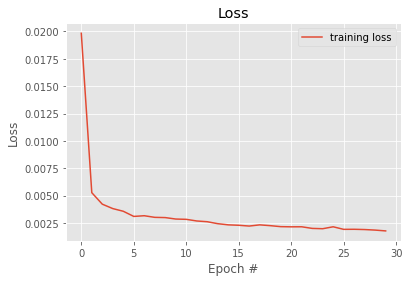

In [ ]:
model = Sequential()
model.add(LSTM(1000,input_shape = (trainX.shape[1],1),return_sequences=True))
model.add(Dropout(0.5))
model.add(BatchNormalization())

model.add(LSTM(624,return_sequences=False))
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(Dense(32,activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1,activation='sigmoid'))

opt = SGD(learning_rate = 0.05)
model.compile(loss = 'mean_squared_error', optimizer = opt)

# train the model
maxEpoch = 30
H = model.fit(trainX, trainY, epochs = maxEpoch, batch_size = 32)


print('Test accuracy')



# plot the loss through training
plt.style.use('ggplot')
plt.figure()

plt.plot(range(maxEpoch), H.history['loss'], label = 'training loss')


plt.title('Loss')
plt.xlabel('Epoch #')
plt.ylabel('Loss')
plt.legend()

48/48 [==============================] - 1s 10ms/step


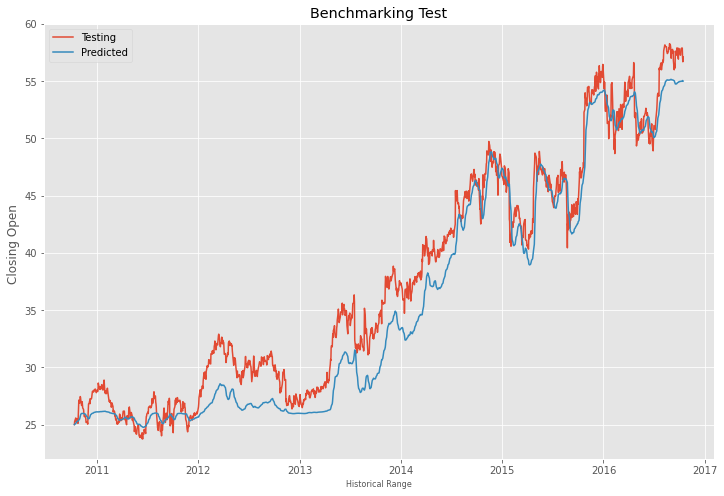

2.0590312387954297

In [ ]:
predictedClose = model.predict(testX) #create prediction outputs

predictedClose = Scaler.inverse_transform(predictedClose) #undo scaling to find actual CHF values

time_train = data[:train]
time_prediction = data[train:]
time_prediction = time_prediction[30:]
time_prediction['Predicted Open Price'] = predictedClose
plt.style.use('ggplot')
plt.figure(figsize=(12,8))
plt.title('Benchmarking Test')
plt.xlabel('Historical Range', fontsize=8)
plt.ylabel('Closing Open ', fontsize=12)
#plt.plot(time_train['Close'])
plt.plot(time_prediction[['Open', 'Predicted Open Price']])
plt.legend(['Testing', 'Predicted'], loc='upper left')
plt.show()

time_prediction['diff'] = pd.Series.abs(time_prediction['Open'] - time_prediction['Predicted Open Price'])
time_prediction
time_prediction['diff'].mean()

##b. Second Model

Epoch 1/30
192/192 [==============================] - 57s 16ms/step - loss: 0.0124
Epoch 2/30
192/192 [==============================] - 3s 14ms/step - loss: 0.0054
Epoch 3/30
192/192 [==============================] - 3s 14ms/step - loss: 0.0040
Epoch 4/30
192/192 [==============================] - 2s 12ms/step - loss: 0.0040
Epoch 5/30
192/192 [==============================] - 2s 12ms/step - loss: 0.0036
Epoch 6/30
192/192 [==============================] - 2s 12ms/step - loss: 0.0034
Epoch 7/30
192/192 [==============================] - 2s 12ms/step - loss: 0.0032
Epoch 8/30
192/192 [==============================] - 2s 12ms/step - loss: 0.0032
Epoch 9/30
192/192 [==============================] - 2s 12ms/step - loss: 0.0030
Epoch 10/30
192/192 [==============================] - 3s 16ms/step - loss: 0.0030
Epoch 11/30
192/192 [==============================] - 3s 15ms/step - loss: 0.0029
Epoch 12/30
192/192 [==============================] - 3s 14ms/step - loss: 0.0028
Epoch 13/30


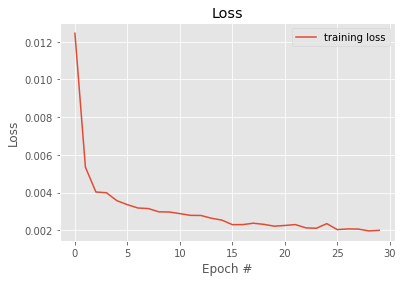

In [ ]:
model2 = Sequential()
model2.add(LSTM(256,input_shape = (trainX.shape[1],1),return_sequences=True))
model2.add(Dropout(0.2))
model2.add(BatchNormalization())

model2.add(LSTM(256,return_sequences=True))
model2.add(Dropout(0.2))
model2.add(BatchNormalization())

model2.add(LSTM(256,return_sequences=False))
model2.add(Dropout(0.2))
model2.add(BatchNormalization())

model2.add(Dense(32,activation='relu'))
model2.add(Dropout(0.2))
model2.add(Dense(1,activation='sigmoid'))

opt = SGD(learning_rate = 0.05)
model2.compile(loss = 'mean_squared_error', optimizer = opt)

# train the model
maxEpoch = 30
H = model2.fit(trainX, trainY, epochs = maxEpoch, batch_size = 32)


print('Test accuracy')



# plot the loss through training
plt.style.use('ggplot')
plt.figure()

plt.plot(range(maxEpoch), H.history['loss'], label = 'training loss')


plt.title('Loss')
plt.xlabel('Epoch #')
plt.ylabel('Loss')
plt.legend()

48/48 [==============================] - 1s 6ms/step


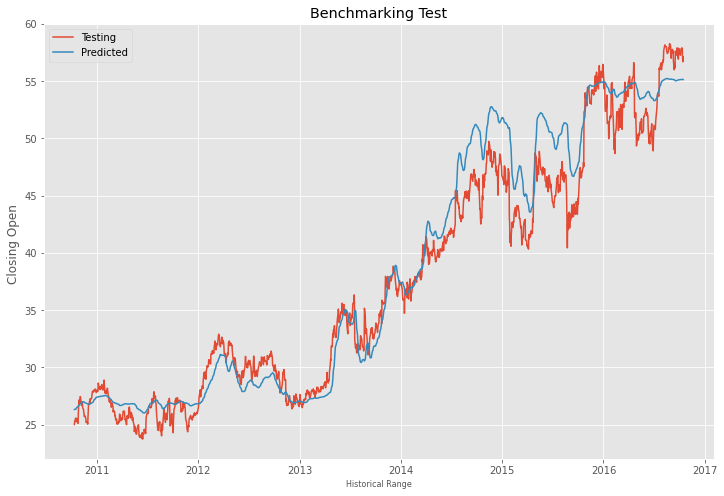

1.8555067784724768

In [ ]:
predictedClose = model2.predict(testX) #create prediction outputs

predictedClose = Scaler.inverse_transform(predictedClose) #undo scaling to find actual CHF values

time_train = data[:train]
time_prediction = data[train:]
time_prediction = time_prediction[30:]
time_prediction['Predicted Open Price'] = predictedClose
plt.style.use('ggplot')
plt.figure(figsize=(12,8))
plt.title('Benchmarking Test')
plt.xlabel('Historical Range', fontsize=8)
plt.ylabel('Closing Open ', fontsize=12)
#plt.plot(time_train['Close'])
plt.plot(time_prediction[['Open', 'Predicted Open Price']])
plt.legend(['Testing', 'Predicted'], loc='upper left')
plt.show()

time_prediction['diff'] = pd.Series.abs(time_prediction['Open'] - time_prediction['Predicted Open Price'])
time_prediction
time_prediction['diff'].mean()

In [ ]:
# We added more layers and reduced the layer inputs a bit, which worked and the model got better metrics.

##c. Third Model

In [1]:
# Let's run the same model, same architecture, same parameters but now with GRU for comparison purposes.

Epoch 1/30
192/192 [==============================] - 7s 12ms/step - loss: 0.0116
Epoch 2/30
192/192 [==============================] - 2s 12ms/step - loss: 0.0056
Epoch 3/30
192/192 [==============================] - 2s 13ms/step - loss: 0.0045
Epoch 4/30
192/192 [==============================] - 3s 15ms/step - loss: 0.0043
Epoch 5/30
192/192 [==============================] - 3s 14ms/step - loss: 0.0037
Epoch 6/30
192/192 [==============================] - 3s 16ms/step - loss: 0.0037
Epoch 7/30
192/192 [==============================] - 3s 15ms/step - loss: 0.0035
Epoch 8/30
192/192 [==============================] - 2s 12ms/step - loss: 0.0032
Epoch 9/30
192/192 [==============================] - 2s 12ms/step - loss: 0.0030
Epoch 10/30
192/192 [==============================] - 2s 12ms/step - loss: 0.0031
Epoch 11/30
192/192 [==============================] - 2s 12ms/step - loss: 0.0028
Epoch 12/30
192/192 [==============================] - 2s 12ms/step - loss: 0.0029
Epoch 13/30
1

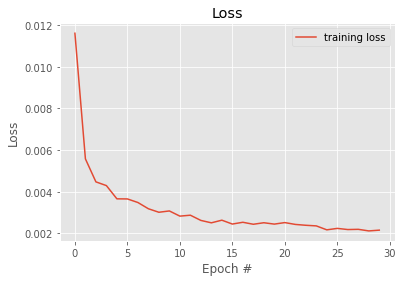

In [ ]:
model3 = Sequential()
model3.add(GRU(256,input_shape = (trainX.shape[1],1),return_sequences=True))
model3.add(Dropout(0.2))
model3.add(BatchNormalization())

model3.add(GRU(256,return_sequences=True))
model3.add(Dropout(0.2))
model3.add(BatchNormalization())

model3.add(GRU(256,return_sequences=False))
model3.add(Dropout(0.2))
model3.add(BatchNormalization())

model3.add(Dense(32,activation='relu'))
model3.add(Dropout(0.2))
model3.add(Dense(1,activation='sigmoid'))

opt = SGD(learning_rate = 0.05)
model3.compile(loss = 'mean_squared_error', optimizer = opt)

# train the model
maxEpoch = 30
H = model3.fit(trainX, trainY, epochs = maxEpoch, batch_size = 32)


print('Test accuracy')



# plot the loss through training
plt.style.use('ggplot')
plt.figure()

plt.plot(range(maxEpoch), H.history['loss'], label = 'training loss')


plt.title('Loss')
plt.xlabel('Epoch #')
plt.ylabel('Loss')
plt.legend()

48/48 [==============================] - 1s 5ms/step


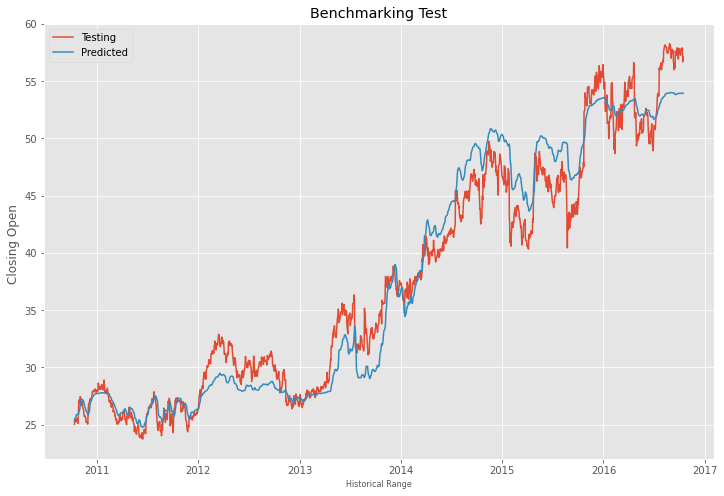

1.7706260088651447

In [ ]:
predictedClose = model3.predict(testX) #create prediction outputs

predictedClose = Scaler.inverse_transform(predictedClose) #undo scaling to find actual CHF values

time_train = data[:train]
time_prediction = data[train:]
time_prediction = time_prediction[30:]
time_prediction['Predicted Open Price'] = predictedClose
plt.style.use('ggplot')
plt.figure(figsize=(12,8))
plt.title('Benchmarking Test')
plt.xlabel('Historical Range', fontsize=8)
plt.ylabel('Closing Open ', fontsize=12)
#plt.plot(time_train['Close'])
plt.plot(time_prediction[['Open', 'Predicted Open Price']])
plt.legend(['Testing', 'Predicted'], loc='upper left')
plt.show()

time_prediction['diff'] = pd.Series.abs(time_prediction['Open'] - time_prediction['Predicted Open Price'])
time_prediction
time_prediction['diff'].mean()

In [ ]:
# We got better results with GRU

##d. Fourth Model

In [ ]:
#Let's try with huber loss

Epoch 1/30
192/192 [==============================] - 7s 13ms/step - loss: 0.0082
Epoch 2/30
192/192 [==============================] - 2s 13ms/step - loss: 0.0037
Epoch 3/30
192/192 [==============================] - 3s 15ms/step - loss: 0.0029
Epoch 4/30
192/192 [==============================] - 2s 13ms/step - loss: 0.0025
Epoch 5/30
192/192 [==============================] - 2s 13ms/step - loss: 0.0023
Epoch 6/30
192/192 [==============================] - 2s 13ms/step - loss: 0.0022
Epoch 7/30
192/192 [==============================] - 2s 13ms/step - loss: 0.0021
Epoch 8/30
192/192 [==============================] - 2s 13ms/step - loss: 0.0020
Epoch 9/30
192/192 [==============================] - 2s 12ms/step - loss: 0.0018
Epoch 10/30
192/192 [==============================] - 2s 13ms/step - loss: 0.0018
Epoch 11/30
192/192 [==============================] - 2s 13ms/step - loss: 0.0017
Epoch 12/30
192/192 [==============================] - 2s 13ms/step - loss: 0.0016
Epoch 13/30
1

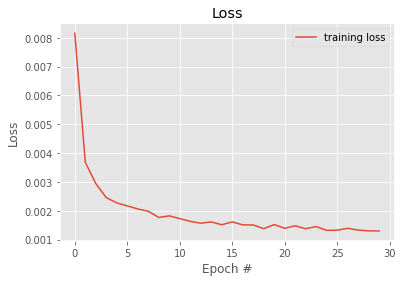

In [ ]:
model4 = Sequential()
model4.add(GRU(256,input_shape = (trainX.shape[1],1),return_sequences=True))
model4.add(Dropout(0.2))
model4.add(BatchNormalization())

model4.add(GRU(256,return_sequences=True))
model4.add(Dropout(0.2))
model4.add(BatchNormalization())

model4.add(GRU(256,return_sequences=False))
model4.add(Dropout(0.2))
model4.add(BatchNormalization())

model4.add(Dense(32,activation='relu'))
model4.add(Dropout(0.2))
model4.add(Dense(1,activation='sigmoid'))

opt = SGD(learning_rate = 0.05)
model4.compile(loss = 'huber_loss', optimizer = opt)

# train the model
maxEpoch = 30
H = model4.fit(trainX, trainY, epochs = maxEpoch, batch_size = 32)


print('Test accuracy')



# plot the loss through training
plt.style.use('ggplot')
plt.figure()

plt.plot(range(maxEpoch), H.history['loss'], label = 'training loss')


plt.title('Loss')
plt.xlabel('Epoch #')
plt.ylabel('Loss')
plt.legend()

48/48 [==============================] - 1s 5ms/step


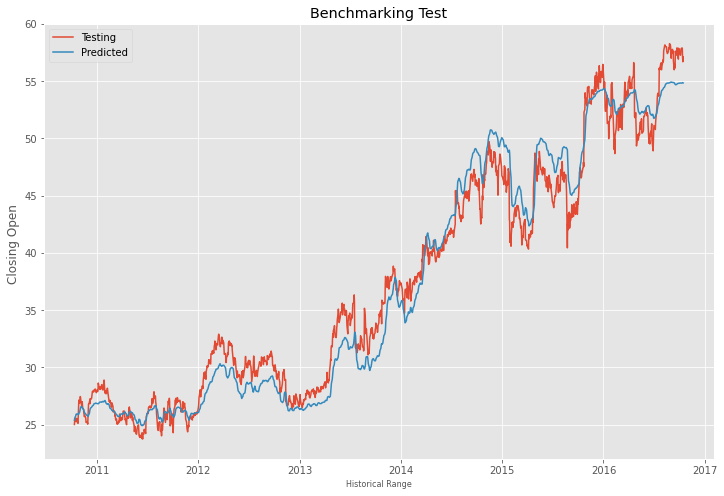

1.5440319878174151

In [ ]:
predictedClose = model4.predict(testX) #create prediction outputs

predictedClose = Scaler.inverse_transform(predictedClose) #undo scaling to find actual CHF values

time_train = data[:train]
time_prediction = data[train:]
time_prediction = time_prediction[30:]
time_prediction['Predicted Open Price'] = predictedClose
plt.style.use('ggplot')
plt.figure(figsize=(12,8))
plt.title('Benchmarking Test')
plt.xlabel('Historical Range', fontsize=8)
plt.ylabel('Closing Open ', fontsize=12)
#plt.plot(time_train['Close'])
plt.plot(time_prediction[['Open', 'Predicted Open Price']])
plt.legend(['Testing', 'Predicted'], loc='upper left')
plt.show()

time_prediction['diff'] = pd.Series.abs(time_prediction['Open'] - time_prediction['Predicted Open Price'])
time_prediction
time_prediction['diff'].mean()

In [ ]:
# Apparently we got better results! But we are still not satisfied, we are going to continue until at least we have a value less than 0.5.

## e. Fifth Model

In [ ]:
# Let's change the inputs of the layers. 

Epoch 1/30
192/192 [==============================] - 7s 16ms/step - loss: 0.0401
Epoch 2/30
192/192 [==============================] - 3s 16ms/step - loss: 0.0308
Epoch 3/30
192/192 [==============================] - 3s 16ms/step - loss: 0.0282
Epoch 4/30
192/192 [==============================] - 3s 16ms/step - loss: 0.0266
Epoch 5/30
192/192 [==============================] - 3s 16ms/step - loss: 0.0254
Epoch 6/30
192/192 [==============================] - 3s 16ms/step - loss: 0.0239
Epoch 7/30
192/192 [==============================] - 3s 16ms/step - loss: 0.0222
Epoch 8/30
192/192 [==============================] - 3s 16ms/step - loss: 0.0201
Epoch 9/30
192/192 [==============================] - 3s 16ms/step - loss: 0.0175
Epoch 10/30
192/192 [==============================] - 3s 16ms/step - loss: 0.0149
Epoch 11/30
192/192 [==============================] - 3s 16ms/step - loss: 0.0123
Epoch 12/30
192/192 [==============================] - 3s 16ms/step - loss: 0.0103
Epoch 13/30
1

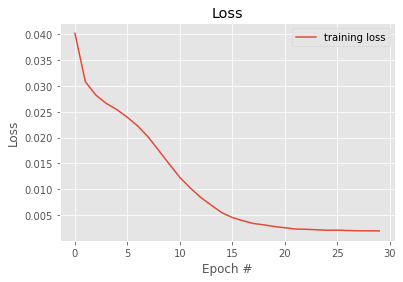

In [ ]:
model5 = Sequential()
model5.add(GRU(1000,input_shape = (trainX.shape[1],1),return_sequences=True))
model5.add(Dropout(0.2))

model5.add(GRU(256,return_sequences=True))
model5.add(Dropout(0.2))

model5.add(GRU(64,return_sequences=False))
model5.add(Dropout(0.2))

model5.add(Dense(32,activation='relu'))
model5.add(Dropout(0.2))
model5.add(Dense(1,activation='sigmoid'))

opt = SGD(learning_rate = 0.01)
model5.compile(loss = 'huber_loss', optimizer = opt)

# train the model
maxEpoch = 30
H = model5.fit(trainX, trainY, epochs = maxEpoch, batch_size = 32)


print('Test accuracy')



# plot the loss through training
plt.style.use('ggplot')
plt.figure()

plt.plot(range(maxEpoch), H.history['loss'], label = 'training loss')


plt.title('Loss')
plt.xlabel('Epoch #')
plt.ylabel('Loss')
plt.legend()

48/48 [==============================] - 1s 7ms/step


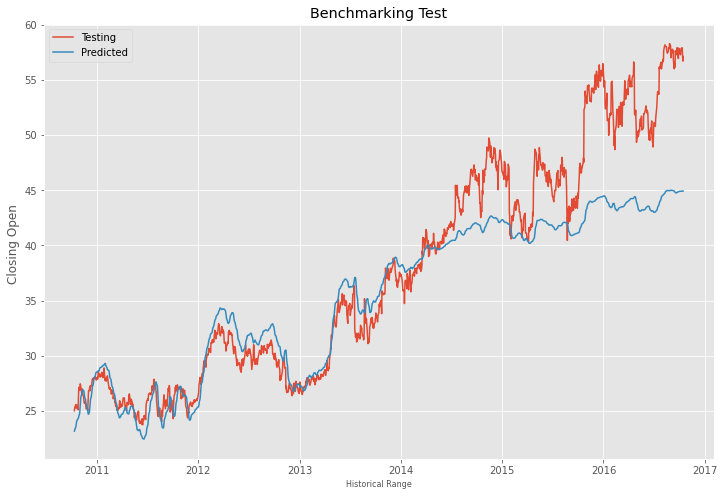

3.1466699941853222

In [ ]:
predictedClose = model5.predict(testX) #create prediction outputs

predictedClose = Scaler.inverse_transform(predictedClose) #undo scaling to find actual CHF values

time_train = data[:train]
time_prediction = data[train:]
time_prediction = time_prediction[30:]
time_prediction['Predicted Open Price'] = predictedClose
plt.style.use('ggplot')
plt.figure(figsize=(12,8))
plt.title('Benchmarking Test')
plt.xlabel('Historical Range', fontsize=8)
plt.ylabel('Closing Open ', fontsize=12)
#plt.plot(time_train['Close'])
plt.plot(time_prediction[['Open', 'Predicted Open Price']])
plt.legend(['Testing', 'Predicted'], loc='upper left')
plt.show()

time_prediction['diff'] = pd.Series.abs(time_prediction['Open'] - time_prediction['Predicted Open Price'])
time_prediction
time_prediction['diff'].mean()

In [ ]:
# Worst values. Let's stay with an architecture similar to the previous model.

## f. Sixth Model

Epoch 1/30
192/192 [==============================] - 5s 13ms/step - loss: 0.0430
Epoch 2/30
192/192 [==============================] - 2s 12ms/step - loss: 0.0325
Epoch 3/30
192/192 [==============================] - 2s 13ms/step - loss: 0.0281
Epoch 4/30
192/192 [==============================] - 2s 13ms/step - loss: 0.0257
Epoch 5/30
192/192 [==============================] - 2s 13ms/step - loss: 0.0242
Epoch 6/30
192/192 [==============================] - 2s 13ms/step - loss: 0.0227
Epoch 7/30
192/192 [==============================] - 2s 13ms/step - loss: 0.0210
Epoch 8/30
192/192 [==============================] - 2s 13ms/step - loss: 0.0194
Epoch 9/30
192/192 [==============================] - 2s 13ms/step - loss: 0.0177
Epoch 10/30
192/192 [==============================] - 2s 13ms/step - loss: 0.0159
Epoch 11/30
192/192 [==============================] - 2s 13ms/step - loss: 0.0140
Epoch 12/30
192/192 [==============================] - 2s 13ms/step - loss: 0.0125
Epoch 13/30
1

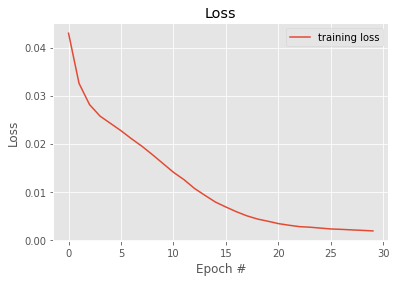

In [ ]:
model6 = Sequential()
model6.add(GRU(1000,input_shape = (trainX.shape[1],1),return_sequences=True))
model6.add(GRU(64,return_sequences=False))
model6.add(Dense(32,activation='relu'))
model6.add(Dropout(0.2))
model6.add(Dense(1,activation='sigmoid'))

opt = SGD(learning_rate = 0.01)
model6.compile(loss = 'huber_loss', optimizer = opt)

# train the model
maxEpoch = 30
H = model6.fit(trainX, trainY, epochs = maxEpoch, batch_size = 32)


print('Test accuracy')



# plot the loss through training
plt.style.use('ggplot')
plt.figure()

plt.plot(range(maxEpoch), H.history['loss'], label = 'training loss')


plt.title('Loss')
plt.xlabel('Epoch #')
plt.ylabel('Loss')
plt.legend()

48/48 [==============================] - 1s 7ms/step


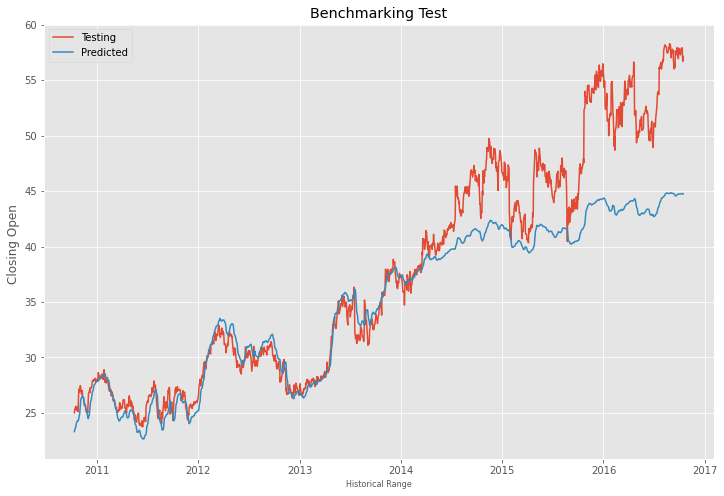

3.0843590208811236

In [ ]:
predictedClose = model6.predict(testX) #create prediction outputs

predictedClose = Scaler.inverse_transform(predictedClose) #undo scaling to find actual CHF values

time_train = data[:train]
time_prediction = data[train:]
time_prediction = time_prediction[30:]
time_prediction['Predicted Open Price'] = predictedClose
plt.style.use('ggplot')
plt.figure(figsize=(12,8))
plt.title('Benchmarking Test')
plt.xlabel('Historical Range', fontsize=8)
plt.ylabel('Closing Open ', fontsize=12)
#plt.plot(time_train['Close'])
plt.plot(time_prediction[['Open', 'Predicted Open Price']])
plt.legend(['Testing', 'Predicted'], loc='upper left')
plt.show()

time_prediction['diff'] = pd.Series.abs(time_prediction['Open'] - time_prediction['Predicted Open Price'])
time_prediction
time_prediction['diff'].mean()

## g. Seventh Model

In [ ]:
#It seems that mean square error helps us to have better results than huber.

Epoch 1/30
192/192 [==============================] - 12s 36ms/step - loss: 0.0115
Epoch 2/30
192/192 [==============================] - 7s 35ms/step - loss: 0.0057
Epoch 3/30
192/192 [==============================] - 7s 35ms/step - loss: 0.0046
Epoch 4/30
192/192 [==============================] - 7s 35ms/step - loss: 0.0042
Epoch 5/30
192/192 [==============================] - 7s 36ms/step - loss: 0.0042
Epoch 6/30
192/192 [==============================] - 7s 35ms/step - loss: 0.0040
Epoch 7/30
192/192 [==============================] - 7s 34ms/step - loss: 0.0036
Epoch 8/30
192/192 [==============================] - 7s 35ms/step - loss: 0.0035
Epoch 9/30
192/192 [==============================] - 7s 35ms/step - loss: 0.0032
Epoch 10/30
192/192 [==============================] - 7s 34ms/step - loss: 0.0030
Epoch 11/30
192/192 [==============================] - 7s 34ms/step - loss: 0.0029
Epoch 12/30
192/192 [==============================] - 7s 34ms/step - loss: 0.0030
Epoch 13/30


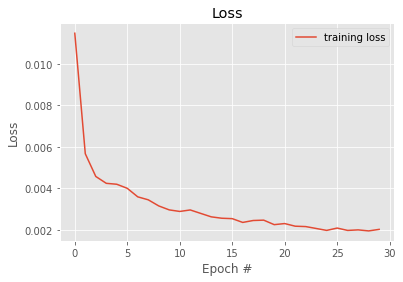

In [ ]:
model7 = Sequential()
model7.add(LSTM(1000,input_shape = (trainX.shape[1],1),return_sequences=True))
model7.add(Dropout(0.5))
model7.add(BatchNormalization())

model7.add(Bidirectional(LSTM(624,return_sequences=False)))
model7.add(Dropout(0.2))
model7.add(BatchNormalization())

model7.add(Dense(32,activation='relu'))
model7.add(Dropout(0.2))
model7.add(Dense(1,activation='sigmoid'))

opt = SGD(learning_rate = 0.05)
model7.compile(loss = 'mean_squared_error', optimizer = opt)

# train the model
maxEpoch = 30
H = model7.fit(trainX, trainY, epochs = maxEpoch, batch_size = 32)


print('Test accuracy')



# plot the loss through training
plt.style.use('ggplot')
plt.figure()

plt.plot(range(maxEpoch), H.history['loss'], label = 'training loss')


plt.title('Loss')
plt.xlabel('Epoch #')
plt.ylabel('Loss')
plt.legend()

48/48 [==============================] - 2s 12ms/step


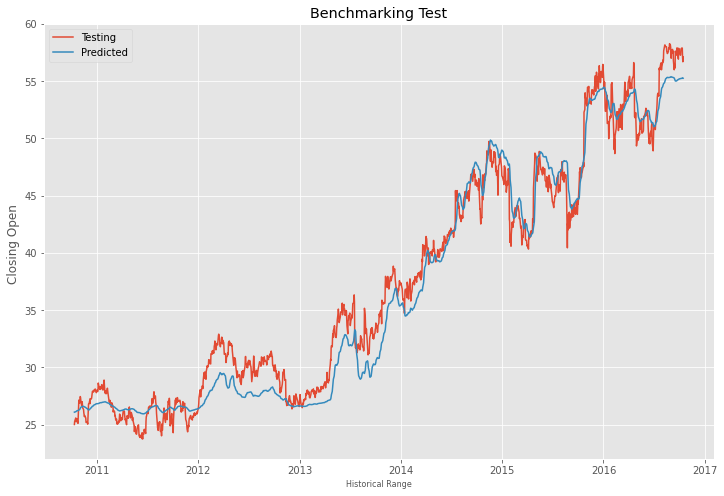

1.494853730085112

In [ ]:
predictedClose = model7.predict(testX) #create prediction outputs

predictedClose = Scaler.inverse_transform(predictedClose) #undo scaling to find actual CHF values

time_train = data[:train]
time_prediction = data[train:]
time_prediction = time_prediction[30:]
time_prediction['Predicted Open Price'] = predictedClose
plt.style.use('ggplot')
plt.figure(figsize=(12,8))
plt.title('Benchmarking Test')
plt.xlabel('Historical Range', fontsize=8)
plt.ylabel('Closing Open ', fontsize=12)
#plt.plot(time_train['Close'])
plt.plot(time_prediction[['Open', 'Predicted Open Price']])
plt.legend(['Testing', 'Predicted'], loc='upper left')
plt.show()

time_prediction['diff'] = pd.Series.abs(time_prediction['Open'] - time_prediction['Predicted Open Price'])
time_prediction
time_prediction['diff'].mean()

## h. Eighth Model

In [ ]:
#Let's add Bidirectional

Epoch 1/30
192/192 [==============================] - 9s 19ms/step - loss: 0.0511
Epoch 2/30
192/192 [==============================] - 4s 19ms/step - loss: 0.0225
Epoch 3/30
192/192 [==============================] - 4s 19ms/step - loss: 0.0164
Epoch 4/30
192/192 [==============================] - 4s 19ms/step - loss: 0.0138
Epoch 5/30
192/192 [==============================] - 4s 19ms/step - loss: 0.0125
Epoch 6/30
192/192 [==============================] - 4s 19ms/step - loss: 0.0122
Epoch 7/30
192/192 [==============================] - 4s 19ms/step - loss: 0.0114
Epoch 8/30
192/192 [==============================] - 4s 19ms/step - loss: 0.0110
Epoch 9/30
192/192 [==============================] - 4s 19ms/step - loss: 0.0108
Epoch 10/30
192/192 [==============================] - 4s 19ms/step - loss: 0.0104
Epoch 11/30
192/192 [==============================] - 4s 19ms/step - loss: 0.0104
Epoch 12/30
192/192 [==============================] - 4s 19ms/step - loss: 0.0101
Epoch 13/30
1

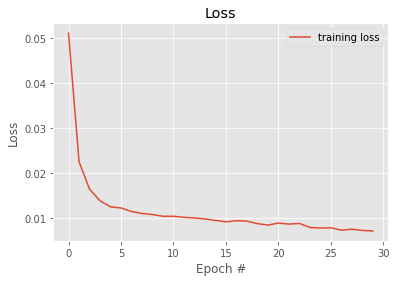

In [ ]:
model8 = Sequential()
model8.add(GRU(1000,input_shape = (trainX.shape[1],1),return_sequences=True))
model8.add(Dropout(0.5))
model8.add(BatchNormalization())

model8.add(Bidirectional(GRU(256,return_sequences=False)))
model8.add(Dropout(0.2))
model8.add(BatchNormalization())

model8.add(Dense(64,activation='relu'))
model8.add(Dropout(0.2))
model8.add(Dense(32,activation='relu'))
model8.add(Dropout(0.2))
model8.add(Dense(10,activation='relu'))
model8.add(Dropout(0.2))
model8.add(Dense(1,activation='sigmoid'))

opt = SGD(learning_rate = 0.01)
model8.compile(loss = 'mean_squared_error', optimizer = opt)

# train the model
maxEpoch = 30
H = model8.fit(trainX, trainY, epochs = maxEpoch, batch_size = 32)


print('Test accuracy')



# plot the loss through training
plt.style.use('ggplot')
plt.figure()

plt.plot(range(maxEpoch), H.history['loss'], label = 'training loss')


plt.title('Loss')
plt.xlabel('Epoch #')
plt.ylabel('Loss')
plt.legend()

48/48 [==============================] - 1s 9ms/step


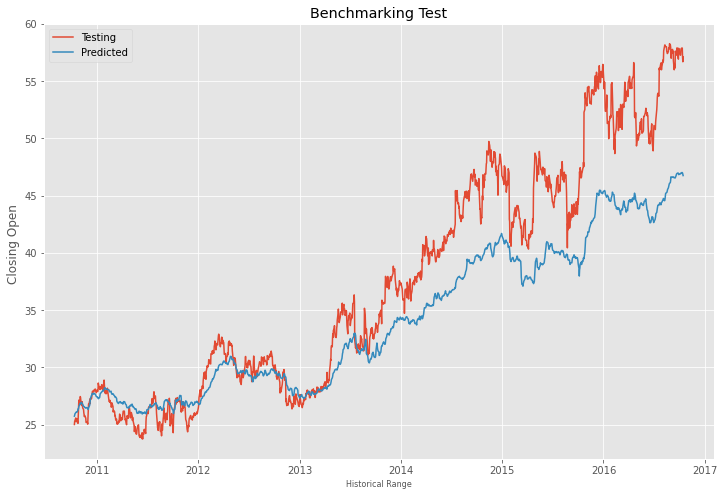

3.830931393105859

In [ ]:
predictedClose = model8.predict(testX) #create prediction outputs

predictedClose = Scaler.inverse_transform(predictedClose) #undo scaling to find actual CHF values

time_train = data[:train]
time_prediction = data[train:]
time_prediction = time_prediction[30:]
time_prediction['Predicted Open Price'] = predictedClose
plt.style.use('ggplot')
plt.figure(figsize=(12,8))
plt.title('Benchmarking Test')
plt.xlabel('Historical Range', fontsize=8)
plt.ylabel('Closing Open ', fontsize=12)
#plt.plot(time_train['Close'])
plt.plot(time_prediction[['Open', 'Predicted Open Price']])
plt.legend(['Testing', 'Predicted'], loc='upper left')
plt.show()

time_prediction['diff'] = pd.Series.abs(time_prediction['Open'] - time_prediction['Predicted Open Price'])
time_prediction
time_prediction['diff'].mean()

In [ ]:
# It didn't work as we expected.

## i. Ninth Model

In [ ]:
# Let's run something similar but with LSTM. 

Epoch 1/30
192/192 [==============================] - 16s 65ms/step - loss: 0.3367
Epoch 2/30
192/192 [==============================] - 14s 71ms/step - loss: 0.0567
Epoch 3/30
192/192 [==============================] - 15s 80ms/step - loss: 0.0161
Epoch 4/30
192/192 [==============================] - 13s 69ms/step - loss: 0.0078
Epoch 5/30
192/192 [==============================] - 12s 62ms/step - loss: 0.0059
Epoch 6/30
192/192 [==============================] - 12s 62ms/step - loss: 0.0051
Epoch 7/30
192/192 [==============================] - 15s 78ms/step - loss: 0.0051
Epoch 8/30
192/192 [==============================] - 13s 70ms/step - loss: 0.0045
Epoch 9/30
192/192 [==============================] - 12s 60ms/step - loss: 0.0045
Epoch 10/30
192/192 [==============================] - 12s 61ms/step - loss: 0.0044
Epoch 11/30
192/192 [==============================] - 12s 61ms/step - loss: 0.0044
Epoch 12/30
192/192 [==============================] - 12s 61ms/step - loss: 0.0043
E

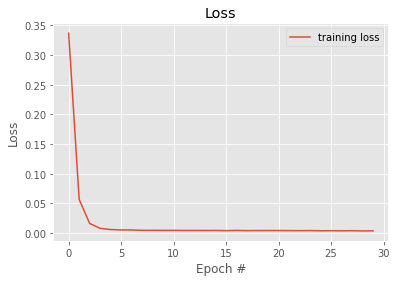

In [ ]:
model9 = Sequential()
model9.add(LSTM(1000,input_shape = (trainX.shape[1],1),return_sequences=True))
model9.add(Dropout(0.2))
model9.add(BatchNormalization())

model9.add(Bidirectional(SimpleRNN(256,return_sequences=False)))
model9.add(Dropout(0.2))
model9.add(BatchNormalization())

model9.add(Dense(64,activation='relu'))
model9.add(Dropout(0.2))
model9.add(BatchNormalization())
model9.add(Dense(32,activation='relu'))
model9.add(Dropout(0.2))
model9.add(BatchNormalization())
model9.add(Dense(1,activation='linear'))

opt = SGD(learning_rate = 0.01)
model9.compile(loss = 'huber_loss', optimizer = opt)

# train the model
maxEpoch = 30
H = model9.fit(trainX, trainY, epochs = maxEpoch, batch_size = 32)


print('Test accuracy')



# plot the loss through training
plt.style.use('ggplot')
plt.figure()

plt.plot(range(maxEpoch), H.history['loss'], label = 'training loss')


plt.title('Loss')
plt.xlabel('Epoch #')
plt.ylabel('Loss')
plt.legend()

48/48 [==============================] - 1s 12ms/step


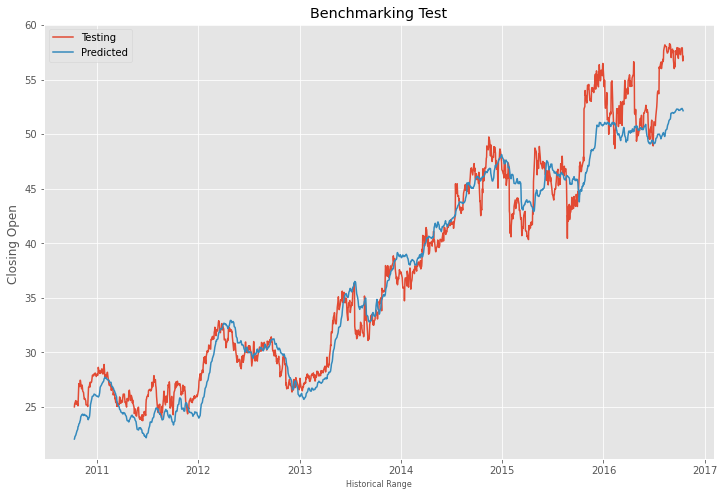

1.7971921153046482

In [ ]:
predictedClose = model9.predict(testX) #create prediction outputs

predictedClose = Scaler.inverse_transform(predictedClose) #undo scaling to find actual CHF values

time_train = data[:train]
time_prediction = data[train:]
time_prediction = time_prediction[30:]
time_prediction['Predicted Open Price'] = predictedClose
plt.style.use('ggplot')
plt.figure(figsize=(12,8))
plt.title('Benchmarking Test')
plt.xlabel('Historical Range', fontsize=8)
plt.ylabel('Closing Open ', fontsize=12)
#plt.plot(time_train['Close'])
plt.plot(time_prediction[['Open', 'Predicted Open Price']])
plt.legend(['Testing', 'Predicted'], loc='upper left')
plt.show()

time_prediction['diff'] = pd.Series.abs(time_prediction['Open'] - time_prediction['Predicted Open Price'])
time_prediction
time_prediction['diff'].mean()

In [ ]:
# Better, but still not the best model. 

## j. Tenth Model

Epoch 1/30
192/192 [==============================] - 8s 24ms/step - loss: 0.0135
Epoch 2/30
192/192 [==============================] - 5s 24ms/step - loss: 0.0051
Epoch 3/30
192/192 [==============================] - 5s 24ms/step - loss: 0.0043
Epoch 4/30
192/192 [==============================] - 5s 24ms/step - loss: 0.0039
Epoch 5/30
192/192 [==============================] - 5s 24ms/step - loss: 0.0036
Epoch 6/30
192/192 [==============================] - 5s 25ms/step - loss: 0.0035
Epoch 7/30
192/192 [==============================] - 5s 24ms/step - loss: 0.0032
Epoch 8/30
192/192 [==============================] - 5s 24ms/step - loss: 0.0031
Epoch 9/30
192/192 [==============================] - 5s 24ms/step - loss: 0.0031
Epoch 10/30
192/192 [==============================] - 5s 24ms/step - loss: 0.0029
Epoch 11/30
192/192 [==============================] - 5s 24ms/step - loss: 0.0029
Epoch 12/30
192/192 [==============================] - 5s 24ms/step - loss: 0.0027
Epoch 13/30
1

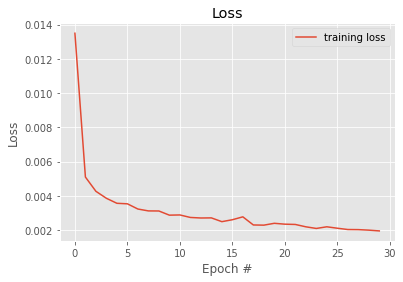

In [ ]:
model10 = Sequential()
model10.add(LSTM(1000,input_shape = (trainX.shape[1],1),return_sequences=True))
model10.add(Dropout(0.5))
model10.add(BatchNormalization())

model10.add(LSTM(624,return_sequences=False))
model10.add(Dropout(0.2))
model10.add(BatchNormalization())

model10.add(Dense(32,activation='relu'))
model10.add(Dropout(0.2))
model10.add(Dense(1,activation='sigmoid'))

opt = SGD(learning_rate = 0.05)
model10.compile(loss = 'mean_squared_error', optimizer = opt)

# train the model
maxEpoch = 30
H = model10.fit(trainX, trainY, epochs = maxEpoch, batch_size = 32)


print('Test accuracy')



# plot the loss through training
plt.style.use('ggplot')
plt.figure()

plt.plot(range(maxEpoch), H.history['loss'], label = 'training loss')


plt.title('Loss')
plt.xlabel('Epoch #')
plt.ylabel('Loss')
plt.legend()

48/48 [==============================] - 1s 9ms/step


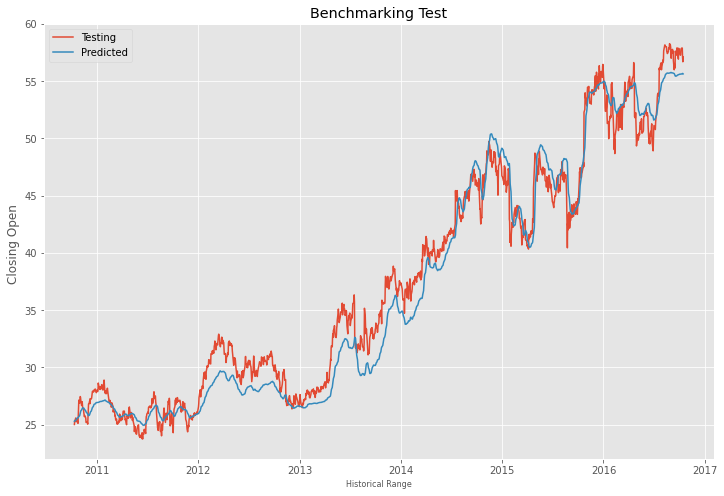

1.471695204720305

In [ ]:
predictedClose = model10.predict(testX) #create prediction outputs

predictedClose = Scaler.inverse_transform(predictedClose) #undo scaling to find actual CHF values

time_train = data[:train]
time_prediction = data[train:]
time_prediction = time_prediction[30:]
time_prediction['Predicted Open Price'] = predictedClose
plt.style.use('ggplot')
plt.figure(figsize=(12,8))
plt.title('Benchmarking Test')
plt.xlabel('Historical Range', fontsize=8)
plt.ylabel('Closing Open ', fontsize=12)
#plt.plot(time_train['Close'])
plt.plot(time_prediction[['Open', 'Predicted Open Price']])
plt.legend(['Testing', 'Predicted'], loc='upper left')
plt.show()

time_prediction['diff'] = pd.Series.abs(time_prediction['Open'] - time_prediction['Predicted Open Price'])
time_prediction
time_prediction['diff'].mean()

In [ ]:
# So far the best model. Let's keep trying.

## k. Eleventh Model

Epoch 1/30
192/192 [==============================] - 7s 23ms/step - loss: 0.0413
Epoch 2/30
192/192 [==============================] - 4s 23ms/step - loss: 0.0035
Epoch 3/30
192/192 [==============================] - 4s 23ms/step - loss: 0.0021
Epoch 4/30
192/192 [==============================] - 4s 23ms/step - loss: 0.0019
Epoch 5/30
192/192 [==============================] - 4s 23ms/step - loss: 0.0018
Epoch 6/30
192/192 [==============================] - 4s 23ms/step - loss: 0.0017
Epoch 7/30
192/192 [==============================] - 4s 23ms/step - loss: 0.0015
Epoch 8/30
192/192 [==============================] - 4s 23ms/step - loss: 0.0014
Epoch 9/30
192/192 [==============================] - 4s 23ms/step - loss: 0.0013
Epoch 10/30
192/192 [==============================] - 4s 23ms/step - loss: 0.0013
Epoch 11/30
192/192 [==============================] - 4s 23ms/step - loss: 0.0012
Epoch 12/30
192/192 [==============================] - 4s 23ms/step - loss: 0.0011
Epoch 13/30
1

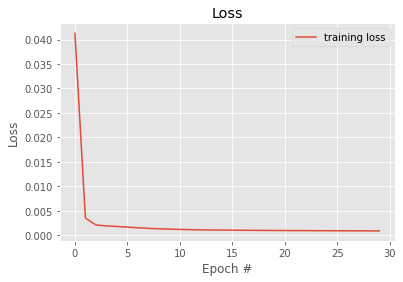

In [ ]:
model11 = Sequential()
model11.add(LSTM(1000,input_shape = (trainX.shape[1],1),return_sequences=True))
model11.add(LSTM(624,return_sequences=False))
model11.add(Dense(32,activation='relu'))
model11.add(Dense(1,activation='sigmoid'))

opt = SGD(learning_rate = 0.05)
model11.compile(loss = 'mean_squared_error', optimizer = opt)

# train the model
maxEpoch = 30
H = model11.fit(trainX, trainY, epochs = maxEpoch, batch_size = 32)


print('Test accuracy')



# plot the loss through training
plt.style.use('ggplot')
plt.figure()

plt.plot(range(maxEpoch), H.history['loss'], label = 'training loss')


plt.title('Loss')
plt.xlabel('Epoch #')
plt.ylabel('Loss')
plt.legend()

48/48 [==============================] - 1s 8ms/step


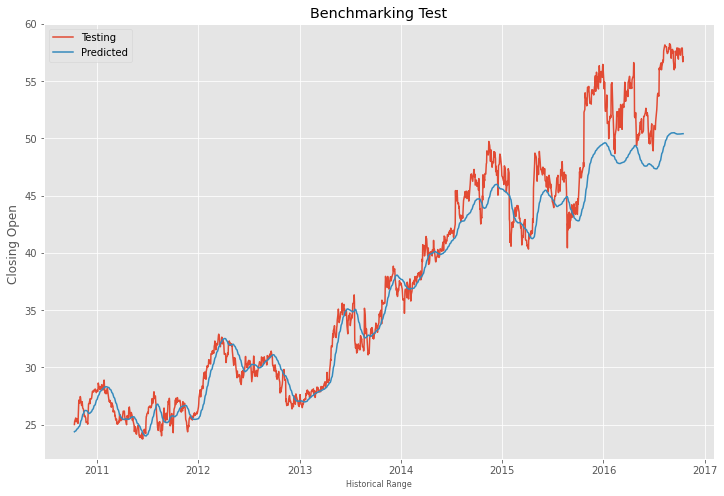

1.8024352931535095

In [ ]:
predictedClose = model11.predict(testX) #create prediction outputs

predictedClose = Scaler.inverse_transform(predictedClose) #undo scaling to find actual CHF values

time_train = data[:train]
time_prediction = data[train:]
time_prediction = time_prediction[30:]
time_prediction['Predicted Open Price'] = predictedClose
plt.style.use('ggplot')
plt.figure(figsize=(12,8))
plt.title('Benchmarking Test')
plt.xlabel('Historical Range', fontsize=8)
plt.ylabel('Closing Open ', fontsize=12)
#plt.plot(time_train['Close'])
plt.plot(time_prediction[['Open', 'Predicted Open Price']])
plt.legend(['Testing', 'Predicted'], loc='upper left')
plt.show()

time_prediction['diff'] = pd.Series.abs(time_prediction['Open'] - time_prediction['Predicted Open Price'])
time_prediction
time_prediction['diff'].mean()

## l. Twelfth Model

In [ ]:
# Let's try to run something without RNN

Epoch 1/30
192/192 [==============================] - 1s 2ms/step - loss: 0.0386
Epoch 2/30
192/192 [==============================] - 0s 2ms/step - loss: 7.2479e-04
Epoch 3/30
192/192 [==============================] - 0s 2ms/step - loss: 6.2364e-04
Epoch 4/30
192/192 [==============================] - 0s 2ms/step - loss: 6.0282e-04
Epoch 5/30
192/192 [==============================] - 0s 2ms/step - loss: 5.1635e-04
Epoch 6/30
192/192 [==============================] - 0s 2ms/step - loss: 5.0570e-04
Epoch 7/30
192/192 [==============================] - 0s 2ms/step - loss: 4.5430e-04
Epoch 8/30
192/192 [==============================] - 0s 2ms/step - loss: 4.3698e-04
Epoch 9/30
192/192 [==============================] - 0s 2ms/step - loss: 4.2800e-04
Epoch 10/30
192/192 [==============================] - 0s 2ms/step - loss: 3.8982e-04
Epoch 11/30
192/192 [==============================] - 0s 2ms/step - loss: 4.0572e-04
Epoch 12/30
192/192 [==============================] - 0s 2ms/step 

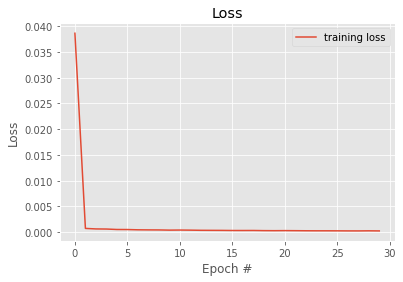

In [ ]:
model12 = Sequential()
model12.add(Dense(100, input_shape = (trainX.shape[1],),kernel_initializer = HeUniform(), bias_initializer = HeUniform() ,activation = 'sigmoid'))
model12.add(Dense(16,kernel_initializer = HeUniform(), bias_initializer = HeUniform(),  activation = 'tanh'))
model12.add(Dense(1,activation = 'linear'))
opt = SGD(learning_rate = 0.015, momentum = 0.9)
model12.compile(loss = 'mean_squared_error', optimizer = opt)





# train the model
maxEpoch = 30
H = model12.fit(trainX, trainY, epochs = maxEpoch, batch_size = 32)


print('Test accuracy')



# plot the loss through training
plt.style.use('ggplot')
plt.figure()

plt.plot(range(maxEpoch), H.history['loss'], label = 'training loss')


plt.title('Loss')
plt.xlabel('Epoch #')
plt.ylabel('Loss')
plt.legend()

48/48 [==============================] - 0s 1ms/step


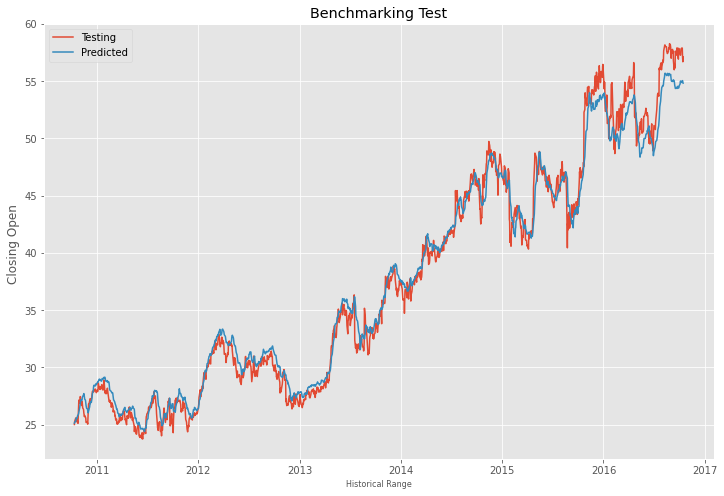

0.9511460759981689

In [ ]:
predictedClose = model12.predict(testX) #create prediction outputs
predictedClose = Scaler.inverse_transform(predictedClose) #undo scaling to find actual CHF values

time_train = data[:train]
time_prediction = data[train:]
time_prediction = time_prediction[30:]
time_prediction['Predicted Open Price'] = predictedClose
plt.style.use('ggplot')
plt.figure(figsize=(12,8))
plt.title('Benchmarking Test')
plt.xlabel('Historical Range', fontsize=8)
plt.ylabel('Closing Open ', fontsize=12)
#plt.plot(time_train['Close'])
plt.plot(time_prediction[['Open', 'Predicted Open Price']])
plt.legend(['Testing', 'Predicted'], loc='upper left')
plt.show()

time_prediction['diff'] = pd.Series.abs(time_prediction['Open'] - time_prediction['Predicted Open Price'])
time_prediction
time_prediction['diff'].mean()

In [ ]:
# Better, but we need to keep improving.
# Let's run something with a similar architecture to the other models.

## m. Thirteenth Model

Epoch 1/30
192/192 [==============================] - 1s 3ms/step - loss: 0.0061
Epoch 2/30
192/192 [==============================] - 1s 3ms/step - loss: 1.3215e-04
Epoch 3/30
192/192 [==============================] - 1s 3ms/step - loss: 1.2203e-04
Epoch 4/30
192/192 [==============================] - 1s 3ms/step - loss: 1.1095e-04
Epoch 5/30
192/192 [==============================] - 1s 3ms/step - loss: 1.6609e-04
Epoch 6/30
192/192 [==============================] - 1s 3ms/step - loss: 8.4385e-05
Epoch 7/30
192/192 [==============================] - 1s 3ms/step - loss: 9.7527e-05
Epoch 8/30
192/192 [==============================] - 1s 3ms/step - loss: 8.5863e-05
Epoch 9/30
192/192 [==============================] - 1s 3ms/step - loss: 8.9878e-05
Epoch 10/30
192/192 [==============================] - 1s 3ms/step - loss: 6.9723e-05
Epoch 11/30
192/192 [==============================] - 1s 3ms/step - loss: 6.2296e-05
Epoch 12/30
192/192 [==============================] - 1s 3ms/step 

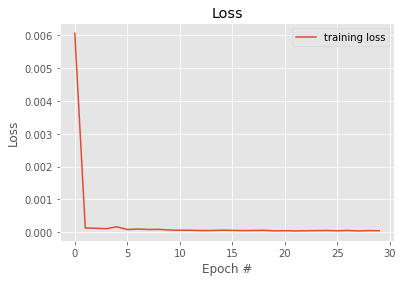

In [ ]:
model13 = Sequential()
model13.add(Dense(1000, input_shape = (trainX.shape[1],),kernel_initializer = HeUniform(), bias_initializer = HeUniform() ,activation = 'relu'))
model13.add(Dense(500,kernel_initializer = HeUniform(), bias_initializer = HeUniform(), activation = 'relu'))
model13.add(Dense(250, kernel_initializer = HeUniform(), bias_initializer = HeUniform(), activation = 'relu'))
model13.add(Dense(125,kernel_initializer = HeUniform(), bias_initializer = HeUniform(),  activation = 'relu'))
model13.add(Dense(60,kernel_initializer = HeUniform(), bias_initializer = HeUniform(),  activation = 'relu'))
model13.add(Dense(1,activation = 'linear'))
opt = SGD(learning_rate = 0.015, momentum = 0.9)
model13.compile(loss = 'huber_loss', optimizer = opt)





# train the model
maxEpoch = 30
H = model13.fit(trainX, trainY, epochs = maxEpoch, batch_size = 32)


print('Test accuracy')



# plot the loss through training
plt.style.use('ggplot')
plt.figure()

plt.plot(range(maxEpoch), H.history['loss'], label = 'training loss')


plt.title('Loss')
plt.xlabel('Epoch #')
plt.ylabel('Loss')
plt.legend()

48/48 [==============================] - 0s 1ms/step


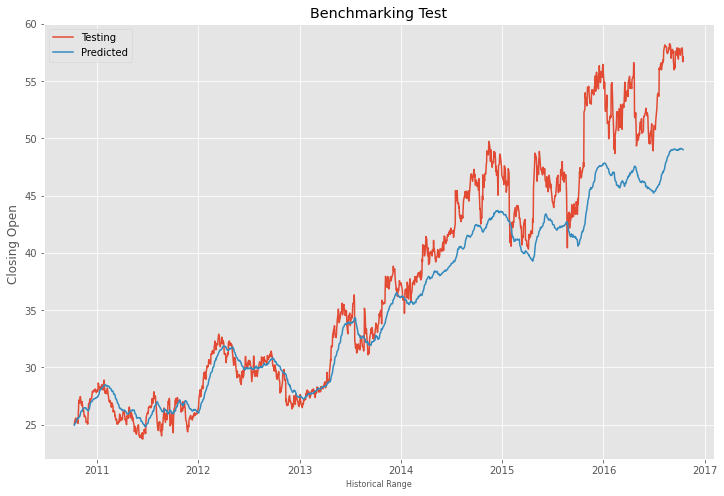

2.5834002687059643

In [ ]:
predictedClose = model13.predict(testX) #create prediction outputs
predictedClose = Scaler.inverse_transform(predictedClose) #undo scaling to find actual CHF values

time_train = data[:train]
time_prediction = data[train:]
time_prediction = time_prediction[30:]
time_prediction['Predicted Open Price'] = predictedClose
plt.style.use('ggplot')
plt.figure(figsize=(12,8))
plt.title('Benchmarking Test')
plt.xlabel('Historical Range', fontsize=8)
plt.ylabel('Closing Open ', fontsize=12)
#plt.plot(time_train['Close'])
plt.plot(time_prediction[['Open', 'Predicted Open Price']])
plt.legend(['Testing', 'Predicted'], loc='upper left')
plt.show()

time_prediction['diff'] = pd.Series.abs(time_prediction['Open'] - time_prediction['Predicted Open Price'])
time_prediction
time_prediction['diff'].mean()

In [ ]:
# Not a good decision.

## n.  Fourteenth Model

In [ ]:
# It seems that simpler models without drop or batchNormalization get better results.

Epoch 1/30
192/192 [==============================] - 15s 61ms/step - loss: 0.0077
Epoch 2/30
192/192 [==============================] - 12s 61ms/step - loss: 0.0011
Epoch 3/30
192/192 [==============================] - 12s 62ms/step - loss: 6.7068e-04
Epoch 4/30
192/192 [==============================] - 12s 61ms/step - loss: 4.3829e-04
Epoch 5/30
192/192 [==============================] - 12s 61ms/step - loss: 2.9345e-04
Epoch 6/30
192/192 [==============================] - 12s 61ms/step - loss: 2.9086e-04
Epoch 7/30
192/192 [==============================] - 12s 61ms/step - loss: 2.3859e-04
Epoch 8/30
192/192 [==============================] - 12s 62ms/step - loss: 2.2279e-04
Epoch 9/30
192/192 [==============================] - 12s 61ms/step - loss: 1.7869e-04
Epoch 10/30
192/192 [==============================] - 12s 61ms/step - loss: 1.8123e-04
Epoch 11/30
192/192 [==============================] - 12s 62ms/step - loss: 1.4838e-04
Epoch 12/30
192/192 [============================

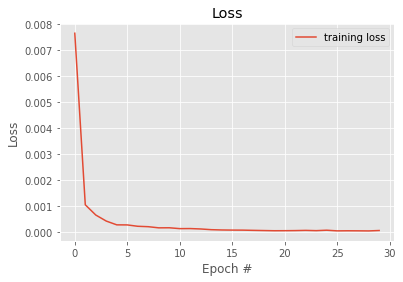

In [ ]:
model14 = Sequential()
model14.add(LSTM(1000,input_shape = (trainX.shape[1],1),return_sequences=True))
model14.add(LSTM(624,return_sequences=True, activation= 'relu'))
model14.add(LSTM(624,return_sequences=False))
model14.add(Dense(32,activation='relu'))
model14.add(Dense(1,activation='sigmoid'))

opt = 'adam'
model14.compile(loss = 'mean_squared_error', optimizer = opt)

# train the model
maxEpoch = 30
H = model14.fit(trainX, trainY, epochs = maxEpoch, batch_size = 32)


print('Test accuracy')



# plot the loss through training
plt.style.use('ggplot')
plt.figure()

plt.plot(range(maxEpoch), H.history['loss'], label = 'training loss')


plt.title('Loss')
plt.xlabel('Epoch #')
plt.ylabel('Loss')
plt.legend()

48/48 [==============================] - 2s 14ms/step


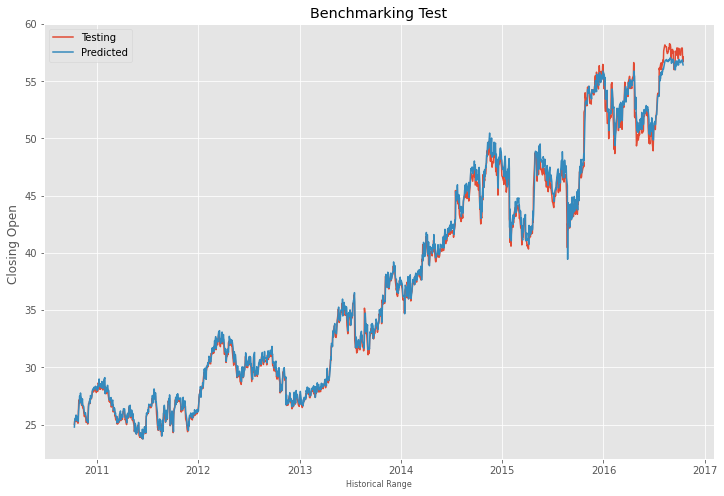

0.5047087533853737

In [ ]:
predictedClose = model14.predict(testX) #create prediction outputs

predictedClose = Scaler.inverse_transform(predictedClose) #undo scaling to find actual CHF values

time_train = data[:train]
time_prediction = data[train:]
time_prediction = time_prediction[30:]
time_prediction['Predicted Open Price'] = predictedClose
plt.style.use('ggplot')
plt.figure(figsize=(12,8))
plt.title('Benchmarking Test')
plt.xlabel('Historical Range', fontsize=8)
plt.ylabel('Closing Open ', fontsize=12)
#plt.plot(time_train['Close'])
plt.plot(time_prediction[['Open', 'Predicted Open Price']])
plt.legend(['Testing', 'Predicted'], loc='upper left')
plt.show()

time_prediction['diff'] = pd.Series.abs(time_prediction['Open'] - time_prediction['Predicted Open Price'])
time_prediction
time_prediction['diff'].mean()

In [ ]:
# Yes! # Let's keep trying without adding Drop or BatchNormalization.

## o. Fifteenth Model

In [ ]:
# Let's compare GRU with LSTM. So, Let's run the same model but with GRU. 

Epoch 1/30
192/192 [==============================] - 16s 68ms/step - loss: 0.0033
Epoch 2/30
192/192 [==============================] - 13s 68ms/step - loss: 2.8254e-04
Epoch 3/30
192/192 [==============================] - 13s 68ms/step - loss: 1.8117e-04
Epoch 4/30
192/192 [==============================] - 13s 67ms/step - loss: 1.8348e-04
Epoch 5/30
192/192 [==============================] - 13s 68ms/step - loss: 1.2327e-04
Epoch 6/30
192/192 [==============================] - 13s 67ms/step - loss: 1.1401e-04
Epoch 7/30
192/192 [==============================] - 13s 67ms/step - loss: 1.3400e-04
Epoch 8/30
192/192 [==============================] - 13s 67ms/step - loss: 1.0625e-04
Epoch 9/30
192/192 [==============================] - 13s 67ms/step - loss: 8.8959e-05
Epoch 10/30
192/192 [==============================] - 13s 70ms/step - loss: 1.1506e-04
Epoch 11/30
192/192 [==============================] - 13s 67ms/step - loss: 7.0794e-05
Epoch 12/30
192/192 [========================

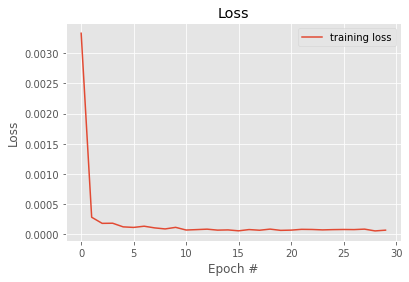

In [ ]:
model15 = Sequential()
model15.add(GRU(1000,input_shape = (trainX.shape[1],1),return_sequences=True))
model15.add(GRU(624,return_sequences=True, activation= 'relu'))
model15.add(GRU(624,return_sequences=False))
model15.add(Dense(32,activation='relu'))
model15.add(Dense(1,activation='sigmoid'))

opt = 'adam'
model15.compile(loss = 'mean_squared_error', optimizer = opt)

# train the model
maxEpoch = 30
H = model15.fit(trainX, trainY, epochs = maxEpoch, batch_size = 32)


print('Test accuracy')



# plot the loss through training
plt.style.use('ggplot')
plt.figure()

plt.plot(range(maxEpoch), H.history['loss'], label = 'training loss')


plt.title('Loss')
plt.xlabel('Epoch #')
plt.ylabel('Loss')
plt.legend()

48/48 [==============================] - 1s 11ms/step


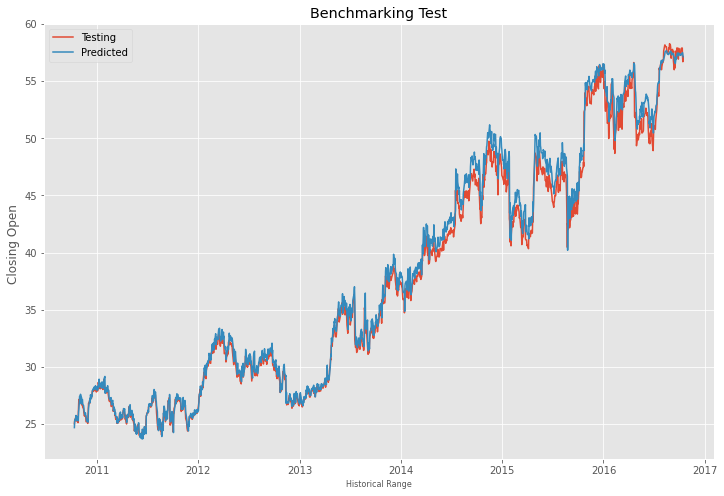

0.7488775663003966

In [ ]:
predictedClose = model15.predict(testX) #create prediction outputs

predictedClose = Scaler.inverse_transform(predictedClose) #undo scaling to find actual CHF values

time_train = data[:train]
time_prediction = data[train:]
time_prediction = time_prediction[30:]
time_prediction['Predicted Open Price'] = predictedClose
plt.style.use('ggplot')
plt.figure(figsize=(12,8))
plt.title('Benchmarking Test')
plt.xlabel('Historical Range', fontsize=8)
plt.ylabel('Closing Open ', fontsize=12)
#plt.plot(time_train['Close'])
plt.plot(time_prediction[['Open', 'Predicted Open Price']])
plt.legend(['Testing', 'Predicted'], loc='upper left')
plt.show()

time_prediction['diff'] = pd.Series.abs(time_prediction['Open'] - time_prediction['Predicted Open Price'])
time_prediction
time_prediction['diff'].mean()

In [ ]:
# Better results with LSTM

## p. Sixteenth Model

Epoch 1/30
192/192 [==============================] - 31s 136ms/step - loss: 0.0104
Epoch 2/30
192/192 [==============================] - 26s 136ms/step - loss: 0.0012
Epoch 3/30
192/192 [==============================] - 26s 136ms/step - loss: 4.2646e-04
Epoch 4/30
192/192 [==============================] - 26s 137ms/step - loss: 2.7578e-04
Epoch 5/30
192/192 [==============================] - 26s 136ms/step - loss: 2.5792e-04
Epoch 6/30
192/192 [==============================] - 26s 136ms/step - loss: 2.3037e-04
Epoch 7/30
192/192 [==============================] - 26s 136ms/step - loss: 1.9591e-04
Epoch 8/30
192/192 [==============================] - 26s 135ms/step - loss: 1.5580e-04
Epoch 9/30
192/192 [==============================] - 26s 136ms/step - loss: 1.5119e-04
Epoch 10/30
192/192 [==============================] - 26s 136ms/step - loss: 1.3603e-04
Epoch 11/30
192/192 [==============================] - 26s 135ms/step - loss: 1.3294e-04
Epoch 12/30
192/192 [=================

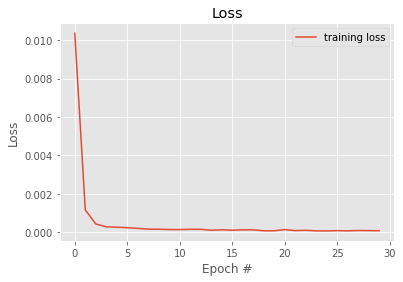

In [ ]:
model16 = Sequential()
model16.add(LSTM(1000,input_shape = (trainX.shape[1],1),return_sequences=True))
model16.add(Bidirectional(LSTM(624,return_sequences=True, activation= 'relu')))
model16.add(SimpleRNN(624,return_sequences=True, activation= 'relu'))
model16.add(LSTM(624,return_sequences=False))
model16.add(Dense(32,activation='relu'))
model16.add(Dense(1,activation='sigmoid'))

opt = 'adam'
model16.compile(loss = 'mean_squared_error', optimizer = opt)

# train the model
maxEpoch = 30
H = model16.fit(trainX, trainY, epochs = maxEpoch, batch_size = 32)


print('Test accuracy')



# plot the loss through training
plt.style.use('ggplot')
plt.figure()

plt.plot(range(maxEpoch), H.history['loss'], label = 'training loss')


plt.title('Loss')
plt.xlabel('Epoch #')
plt.ylabel('Loss')
plt.legend()

In [ ]:
model16.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 30, 1000)          4008000   
                                                                 
 bidirectional (Bidirectiona  (None, 30, 1248)         8112000   
 l)                                                              
                                                                 
 simple_rnn (SimpleRNN)      (None, 30, 624)           1168752   
                                                                 
 lstm_5 (LSTM)               (None, 624)               3117504   
                                                                 
 dense_4 (Dense)             (None, 32)                20000     
                                                                 
 dense_5 (Dense)             (None, 1)                 33        
                                                      

48/48 [==============================] - 2s 19ms/step


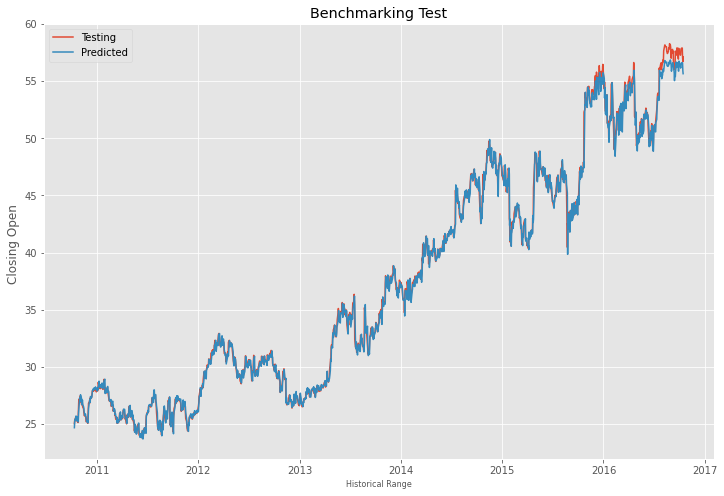

0.43215117798053265

In [ ]:
predictedClose = model16.predict(testX) #create prediction outputs

predictedClose = Scaler.inverse_transform(predictedClose) #undo scaling to find actual CHF values

time_train = data[:train]
time_prediction = data[train:]
time_prediction = time_prediction[30:]
time_prediction['Predicted Open Price'] = predictedClose
plt.style.use('ggplot')
plt.figure(figsize=(12,8))
plt.title('Benchmarking Test')
plt.xlabel('Historical Range', fontsize=8)
plt.ylabel('Closing Open ', fontsize=12)
#plt.plot(time_train['Close'])
plt.plot(time_prediction[['Open', 'Predicted Open Price']])
plt.legend(['Testing', 'Predicted'], loc='upper left')
plt.show()

time_prediction['diff'] = pd.Series.abs(time_prediction['Open'] - time_prediction['Predicted Open Price'])
time_prediction
time_prediction['diff'].mean()

In [ ]:
# Good combination between SimpleRNN, Bidirectional, and LSTM. It is less than 0.5. 

## q. Seventeenth Model

In [ ]:
#Best model with 10

Epoch 1/10
192/192 [==============================] - 38s 155ms/step - loss: 0.0048
Epoch 2/10
192/192 [==============================] - 29s 151ms/step - loss: 3.7543e-04
Epoch 3/10
192/192 [==============================] - 29s 151ms/step - loss: 4.1637e-04
Epoch 4/10
192/192 [==============================] - 29s 150ms/step - loss: 2.0974e-04
Epoch 5/10
192/192 [==============================] - 29s 152ms/step - loss: 1.6424e-04
Epoch 6/10
192/192 [==============================] - 29s 151ms/step - loss: 1.9092e-04
Epoch 7/10
192/192 [==============================] - 29s 152ms/step - loss: 1.8235e-04
Epoch 8/10
192/192 [==============================] - 29s 152ms/step - loss: 1.6071e-04
Epoch 9/10
192/192 [==============================] - 29s 151ms/step - loss: 1.0907e-04
Epoch 10/10
192/192 [==============================] - 29s 154ms/step - loss: 1.1632e-04
Test accuracy


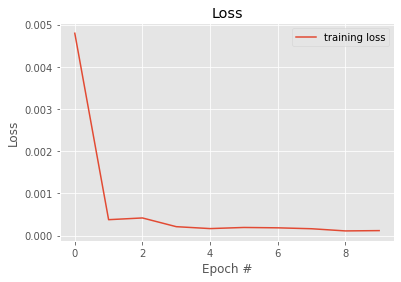

In [ ]:
model17 = Sequential()
model17.add(LSTM(1000,input_shape = (trainX.shape[1],1),return_sequences=True))
model17.add(Bidirectional(LSTM(624,return_sequences=True, activation= 'relu')))
model17.add(SimpleRNN(624,return_sequences=True, activation= 'relu'))
model17.add(Bidirectional(LSTM(624,return_sequences=False)))
model17.add(Dense(32,activation='relu'))
model17.add(Dense(1,activation='sigmoid'))

opt = 'adam'
model17.compile(loss = 'mean_squared_error', optimizer = opt)

# train the model
maxEpoch = 10
H = model17.fit(trainX, trainY, epochs = maxEpoch, batch_size = 32)


print('Test accuracy')



# plot the loss through training
plt.style.use('ggplot')
plt.figure()

plt.plot(range(maxEpoch), H.history['loss'], label = 'training loss')


plt.title('Loss')
plt.xlabel('Epoch #')
plt.ylabel('Loss')
plt.legend()

48/48 [==============================] - 2s 24ms/step


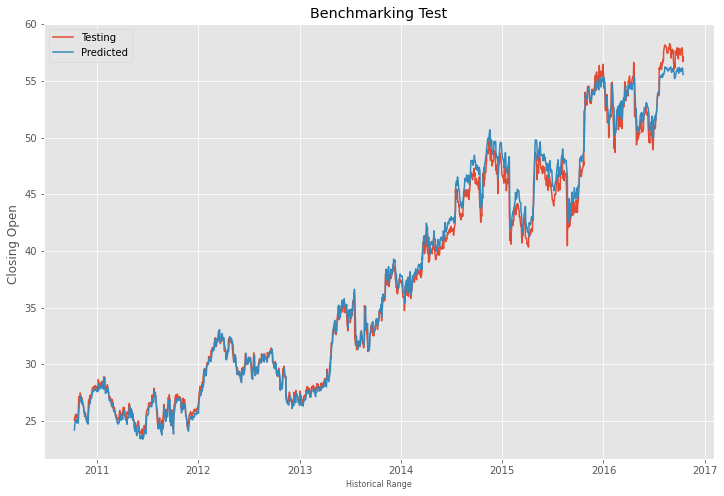

0.6763992410421529

In [ ]:
predictedClose = model17.predict(testX) #create prediction outputs

predictedClose = Scaler.inverse_transform(predictedClose) #undo scaling to find actual CHF values

time_train = data[:train]
time_prediction = data[train:]
time_prediction = time_prediction[30:]
time_prediction['Predicted Open Price'] = predictedClose
plt.style.use('ggplot')
plt.figure(figsize=(12,8))
plt.title('Benchmarking Test')
plt.xlabel('Historical Range', fontsize=8)
plt.ylabel('Closing Open ', fontsize=12)
#plt.plot(time_train['Close'])
plt.plot(time_prediction[['Open', 'Predicted Open Price']])
plt.legend(['Testing', 'Predicted'], loc='upper left')
plt.show()

time_prediction['diff'] = pd.Series.abs(time_prediction['Open'] - time_prediction['Predicted Open Price'])
time_prediction
time_prediction['diff'].mean()

In [ ]:
# Not bad, but we will continue with 30 epochs.

## r. Eighteenth Model

Epoch 1/30
192/192 [==============================] - 39s 157ms/step - loss: 0.0056
Epoch 2/30
192/192 [==============================] - 29s 153ms/step - loss: 6.6636e-04
Epoch 3/30
192/192 [==============================] - 29s 152ms/step - loss: 2.4665e-04
Epoch 4/30
192/192 [==============================] - 30s 154ms/step - loss: 2.7480e-04
Epoch 5/30
192/192 [==============================] - 30s 158ms/step - loss: 1.7960e-04
Epoch 6/30
192/192 [==============================] - 30s 158ms/step - loss: 1.8003e-04
Epoch 7/30
192/192 [==============================] - 30s 156ms/step - loss: 1.2097e-04
Epoch 8/30
192/192 [==============================] - 30s 156ms/step - loss: 1.2504e-04
Epoch 9/30
192/192 [==============================] - 29s 153ms/step - loss: 9.1664e-05
Epoch 10/30
192/192 [==============================] - 30s 157ms/step - loss: 7.9268e-05
Epoch 11/30
192/192 [==============================] - 30s 155ms/step - loss: 9.1870e-05
Epoch 12/30
192/192 [=============

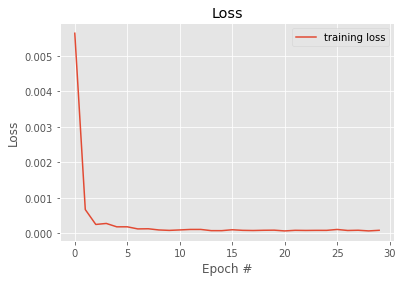

In [ ]:
model18 = Sequential()
model18.add(LSTM(1000,input_shape = (trainX.shape[1],1),return_sequences=True))
model18.add(Bidirectional(LSTM(624,return_sequences=True, activation= 'relu')))
model18.add(SimpleRNN(624,return_sequences=True, activation= 'relu'))
model18.add(Bidirectional(LSTM(624,return_sequences=False)))
model18.add(Dense(32,activation='relu'))
model18.add(Dense(1,activation='sigmoid'))

opt = 'adam'
model18.compile(loss = 'mean_squared_error', optimizer = opt)

# train the model
maxEpoch = 30
H = model18.fit(trainX, trainY, epochs = maxEpoch, batch_size = 32)


print('Test accuracy')



# plot the loss through training
plt.style.use('ggplot')
plt.figure()

plt.plot(range(maxEpoch), H.history['loss'], label = 'training loss')


plt.title('Loss')
plt.xlabel('Epoch #')
plt.ylabel('Loss')
plt.legend()

48/48 [==============================] - 1s 24ms/step


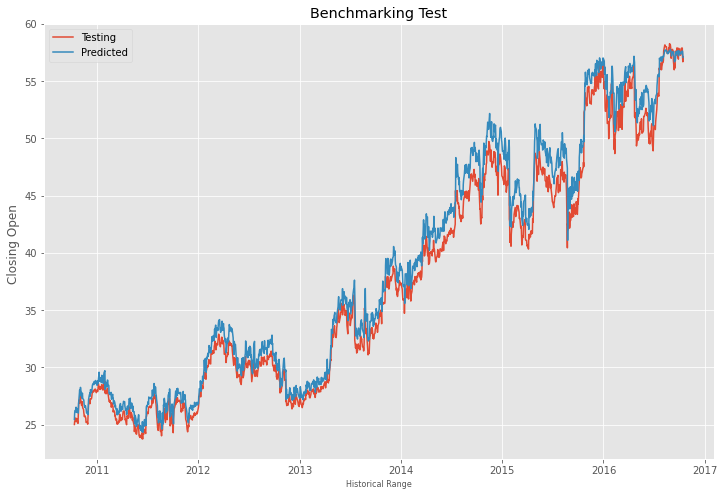

1.3473812640304212

In [ ]:
predictedClose = model18.predict(testX) #create prediction outputs

predictedClose = Scaler.inverse_transform(predictedClose) #undo scaling to find actual CHF values

time_train = data[:train]
time_prediction = data[train:]
time_prediction = time_prediction[30:]
time_prediction['Predicted Open Price'] = predictedClose
plt.style.use('ggplot')
plt.figure(figsize=(12,8))
plt.title('Benchmarking Test')
plt.xlabel('Historical Range', fontsize=8)
plt.ylabel('Closing Open ', fontsize=12)
#plt.plot(time_train['Close'])
plt.plot(time_prediction[['Open', 'Predicted Open Price']])
plt.legend(['Testing', 'Predicted'], loc='upper left')
plt.show()

time_prediction['diff'] = pd.Series.abs(time_prediction['Open'] - time_prediction['Predicted Open Price'])
time_prediction
time_prediction['diff'].mean()

## s. Nineteenth Model

Epoch 1/30
192/192 [==============================] - 18s 73ms/step - loss: 0.0121
Epoch 2/30
192/192 [==============================] - 13s 68ms/step - loss: 4.6447e-04
Epoch 3/30
192/192 [==============================] - 13s 69ms/step - loss: 3.4575e-04
Epoch 4/30
192/192 [==============================] - 13s 69ms/step - loss: 2.9247e-04
Epoch 5/30
192/192 [==============================] - 13s 68ms/step - loss: 2.2411e-04
Epoch 6/30
192/192 [==============================] - 13s 68ms/step - loss: 2.0536e-04
Epoch 7/30
192/192 [==============================] - 13s 69ms/step - loss: 1.9271e-04
Epoch 8/30
192/192 [==============================] - 13s 68ms/step - loss: 1.8868e-04
Epoch 9/30
192/192 [==============================] - 13s 68ms/step - loss: 1.6391e-04
Epoch 10/30
192/192 [==============================] - 13s 68ms/step - loss: 1.6441e-04
Epoch 11/30
192/192 [==============================] - 13s 68ms/step - loss: 1.5672e-04
Epoch 12/30
192/192 [========================

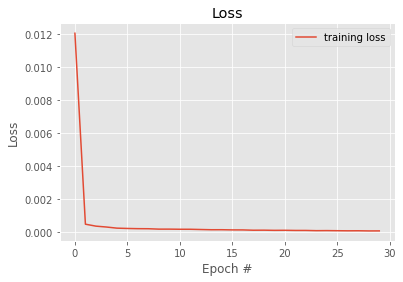

In [ ]:
model19 = Sequential()
model19.add(GRU(1000,input_shape = (trainX.shape[1],1),return_sequences=True))
model19.add(GRU(624,return_sequences=True, activation= 'relu'))
model19.add(GRU(624,return_sequences=False))
model19.add(Dense(32,activation='relu'))
model19.add(Dense(1,activation='sigmoid'))

opt = keras.optimizers.Adam(learning_rate=0.0001)
#opt = 'adam'
model19.compile(loss = 'mean_squared_error', optimizer = opt)

# train the model
maxEpoch = 30
H = model19.fit(trainX, trainY, epochs = maxEpoch, batch_size = 32)


print('Test accuracy')



# plot the loss through training
plt.style.use('ggplot')
plt.figure()

plt.plot(range(maxEpoch), H.history['loss'], label = 'training loss')


plt.title('Loss')
plt.xlabel('Epoch #')
plt.ylabel('Loss')
plt.legend()

48/48 [==============================] - 1s 13ms/step


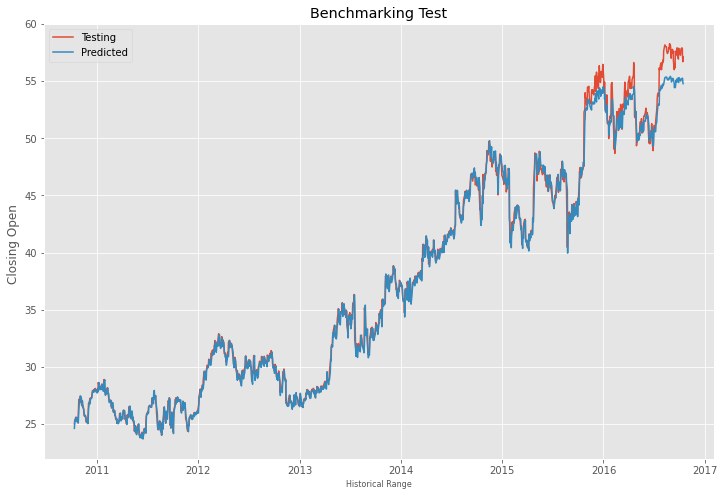

0.5273747630097263

In [ ]:
predictedClose = model19.predict(testX) #create prediction outputs

predictedClose = Scaler.inverse_transform(predictedClose) #undo scaling to find actual CHF values

time_train = data[:train]
time_prediction = data[train:]
time_prediction = time_prediction[30:]
time_prediction['Predicted Open Price'] = predictedClose
plt.style.use('ggplot')
plt.figure(figsize=(12,8))
plt.title('Benchmarking Test')
plt.xlabel('Historical Range', fontsize=8)
plt.ylabel('Closing Open ', fontsize=12)
#plt.plot(time_train['Close'])
plt.plot(time_prediction[['Open', 'Predicted Open Price']])
plt.legend(['Testing', 'Predicted'], loc='upper left')
plt.show()

time_prediction['diff'] = pd.Series.abs(time_prediction['Open'] - time_prediction['Predicted Open Price'])
time_prediction
time_prediction['diff'].mean()

## t. Twentieth Model

In [ ]:
# Let's try ensemble!

In [ ]:
P1 = model14.predict(testX) #create prediction outputs
P2 = model15.predict(testX)
P3 = model16.predict(testX)

Y1 = Scaler.inverse_transform(P1) #undo scaling to find actual CHF values
Y2 = Scaler.inverse_transform(P2)
Y3 = Scaler.inverse_transform(P3)



ensemble = []

for i in range(0,len(testX)):
    ensemble.append((Y1[i]+Y2[i]+ Y3[i])/3)
ensemble = np.array(ensemble)
#ensemble = ensemble.argmax(axis=1)


48/48 [==============================] - 1s 19ms/step


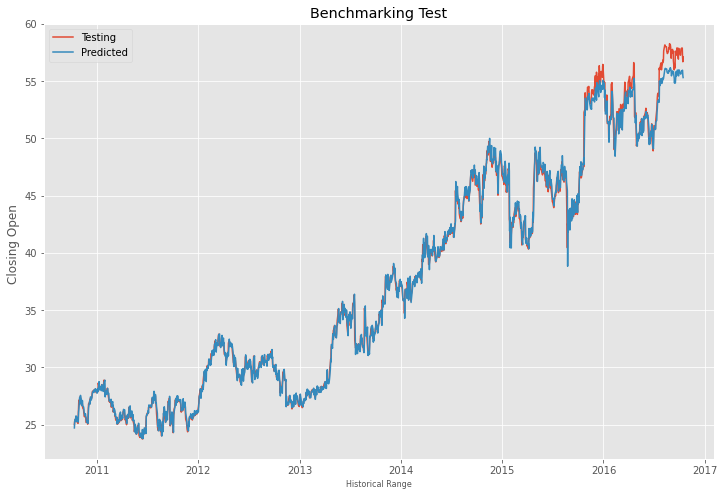

0.482521939577051

In [ ]:

time_train = data[:train]
time_prediction = data[train:]
time_prediction = time_prediction[30:]
time_prediction['Predicted Open Price'] = ensemble
plt.style.use('ggplot')
plt.figure(figsize=(12,8))
plt.title('Benchmarking Test')
plt.xlabel('Historical Range', fontsize=8)
plt.ylabel('Closing Open ', fontsize=12)
#plt.plot(time_train['Close'])
plt.plot(time_prediction[['Open', 'Predicted Open Price']])
plt.legend(['Testing', 'Predicted'], loc='upper left')
plt.show()

time_prediction['diff'] = pd.Series.abs(time_prediction['Open'] - time_prediction['Predicted Open Price'])
time_prediction
time_prediction['diff'].mean()

In [ ]:
# Good results, but let's try to deal with the best models, of different architectures.

In [ ]:
P1 = model14.predict(testX) #create prediction outputs
P2 = model16.predict(testX)
P3 = model19.predict(testX)

Y1 = Scaler.inverse_transform(P1) #undo scaling to find actual CHF values
Y2 = Scaler.inverse_transform(P2)
Y3 = Scaler.inverse_transform(P3)



ensemble = []

for i in range(0,len(testX)):
    ensemble.append((Y1[i]+Y2[i]+ Y3[i])/3)
ensemble = np.array(ensemble)
#ensemble = ensemble.argmax(axis=1)

48/48 [==============================] - 1s 12ms/step


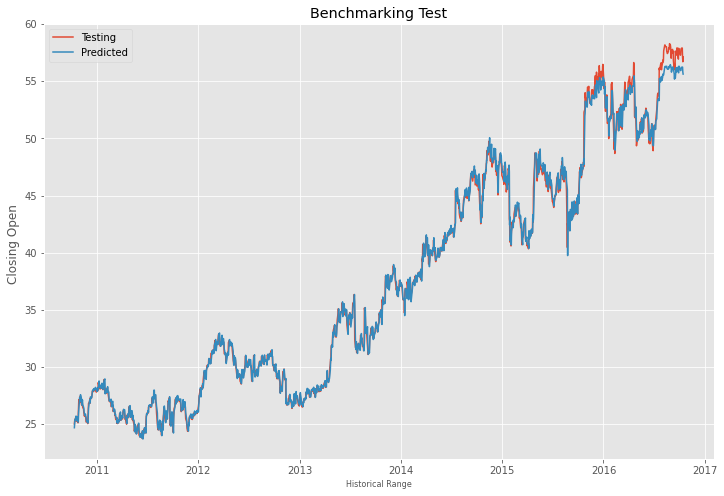

0.4494212970620185

In [ ]:

time_train = data[:train]
time_prediction = data[train:]
time_prediction = time_prediction[30:]
time_prediction['Predicted Open Price'] = ensemble
plt.style.use('ggplot')
plt.figure(figsize=(12,8))
plt.title('Benchmarking Test')
plt.xlabel('Historical Range', fontsize=8)
plt.ylabel('Closing Open ', fontsize=12)
#plt.plot(time_train['Close'])
plt.plot(time_prediction[['Open', 'Predicted Open Price']])
plt.legend(['Testing', 'Predicted'], loc='upper left')
plt.show()

time_prediction['diff'] = pd.Series.abs(time_prediction['Open'] - time_prediction['Predicted Open Price'])
time_prediction
time_prediction['diff'].mean()

In [ ]:
# Ensemble along with model 16, were the best models in terms of Tunning Hyperparameters.

# IV.  Finding Historical Portfolio Volatility Values


 For finding portfolio volatility, we normalize the prices and then construct a new array of returns, which is then used to find the asset's variance. From here, we use each asset's volatility and weight into the portfolio volatility formula found in our report.

 Resources for this section of code: http://www.arngarden.com/2013/06/02/calculating-volatility-of-multi-asset-portfolio-example-using-python/

 https://financetrainingcourse.com/education/2011/04/market-risk-metrics-portfolio-volatility/

 For portfolio weights see: https://www.portfoliovisualizer.com/optimize-portfolio#analysisResults

### i. Tech Sector Portfolio

In [ ]:
# MSFT Data

In [4]:
data = yf.download("MSFT", start="2012-08-04", end="2016-12-31") #takes data from Yahoo Finance
data.to_csv('Nestle CSV')
data= data.dropna() #remove null and check again
print(data.isna().sum())
#data = data[['Close']]
data
data1 = data[['Close', 'Open', 'High', 'Low']] #filter out other column data
data1['Average'] = (data1['Close'] + data1['Open'] + data1['High'] + data1['Low'])/4
data1  = data1[['Average']]
data2 = data[['Open']]
AvgVals = data1.values #turn our data to numpy array for manipulation
AvgVals2 = data2.values
#scaledVals
train = math.floor(len(AvgVals)* 0.80) # 80% training data length, notice floor is used to round integer (decimal time stamp doesn't make any sense) #took me forever to figure out this was a glaring problem
testY =  AvgVals2[train : , : ]  #list for data from the end of training timestamp to end of test timestamp, i.e. 20%

[*********************100%***********************]  1 of 1 completed
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64


In [ ]:
len(testY)

222

In [5]:
normalized_prices1 = (testY) / testY[0]
daily_ret1 = [0.0]
for i in range(1, len(normalized_prices1)):
  daily_ret1.append((normalized_prices1[i] / normalized_prices1[i-1] - 1)[0])
volatility1 = np.var(daily_ret1)

In [ ]:
# FTNT Data

In [ ]:
data = yf.download("FTNT", start="2012-08-04", end="2016-12-31") #takes data from Yahoo Finance
data.to_csv('Nestle CSV')
data= data.dropna() #remove null and check again
print(data.isna().sum())
#data = data[['Close']]
data
data1 = data[['Close', 'Open', 'High', 'Low']] #filter out other column data
data1['Average'] = (data1['Close'] + data1['Open'] + data1['High'] + data1['Low'])/4
data1  = data1[['Average']]
data2 = data[['Open']]
AvgVals = data1.values #turn our data to numpy array for manipulation
AvgVals2 = data2.values
#scaledVals
train = math.floor(len(AvgVals)* 0.80) # 80% training data length, notice floor is used to round integer (decimal time stamp doesn't make any sense) #took me forever to figure out this was a glaring problem
testY =  AvgVals2[train : , : ]  #list for data from the end of training timestamp to end of test timestamp, i.e. 20%

[*********************100%***********************]  1 of 1 completed
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64


In [ ]:
len(testY)

222

In [ ]:
normalized_prices2 = (testY) / testY[0]
daily_ret2 = [0.0]
for i in range(1, len(normalized_prices2)):
  daily_ret2.append((normalized_prices2[i] / normalized_prices2[i-1] - 1)[0])
volatility2 = np.var(daily_ret2)

In [ ]:
# ADBE Data

In [ ]:
data = yf.download("ADBE", start="2012-08-04", end="2016-12-31") #takes data from Yahoo Finance
data.to_csv('Nestle CSV')
data= data.dropna() #remove null and check again
print(data.isna().sum())
#data = data[['Close']]
data
data1 = data[['Close', 'Open', 'High', 'Low']] #filter out other column data
data1['Average'] = (data1['Close'] + data1['Open'] + data1['High'] + data1['Low'])/4
data1  = data1[['Average']]
data2 = data[['Open']]
AvgVals = data1.values #turn our data to numpy array for manipulation
AvgVals2 = data2.values
#scaledVals
train = math.floor(len(AvgVals)* 0.80) # 80% training data length, notice floor is used to round integer (decimal time stamp doesn't make any sense) #took me forever to figure out this was a glaring problem
testY =  AvgVals2[train : , : ]  #list for data from the end of training timestamp to end of test timestamp, i.e. 20%

[*********************100%***********************]  1 of 1 completed
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64


In [ ]:
normalized_prices3 = (testY) / testY[0]
daily_ret3 = [0.0]
for i in range(1, len(normalized_prices3)):
  daily_ret3.append((normalized_prices3[i] / normalized_prices3[i-1] - 1)[0])
volatility3 = np.var(daily_ret3)

In [ ]:
len(testY)

222

In [ ]:
# SNPS Data

In [ ]:
data = yf.download("SNPS", start="2012-08-04", end="2016-12-31") #takes data from Yahoo Finance
data.to_csv('Nestle CSV')
data= data.dropna() #remove null and check again
print(data.isna().sum())
#data = data[['Close']]
data
data1 = data[['Close', 'Open', 'High', 'Low']] #filter out other column data
data1['Average'] = (data1['Close'] + data1['Open'] + data1['High'] + data1['Low'])/4
data1  = data1[['Average']]
data2 = data[['Open']]
AvgVals = data1.values #turn our data to numpy array for manipulation
AvgVals2 = data2.values
#scaledVals
train = math.floor(len(AvgVals)* 0.80) # 80% training data length, notice floor is used to round integer (decimal time stamp doesn't make any sense) #took me forever to figure out this was a glaring problem
testY =  AvgVals2[train : , : ]  #list for data from the end of training timestamp to end of test timestamp, i.e. 20%

[*********************100%***********************]  1 of 1 completed
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64


In [ ]:
normalized_prices4 = (testY) / testY[0]
daily_ret4 = [0.0]
for i in range(1, len(normalized_prices4)):
  daily_ret4.append((normalized_prices4[i] / normalized_prices4[i-1] - 1)[0])
volatility4 = np.var(daily_ret4)

In [ ]:
len(testY)

222

In [ ]:
# PANW Data

In [ ]:
data = yf.download("PANW", start="2013-06-25", end="2016-12-31") #takes data from Yahoo Finance
data.to_csv('Nestle CSV')
data= data.dropna() #remove null and check again
print(data.isna().sum())
#data = data[['Close']]
data
data1 = data[['Close', 'Open', 'High', 'Low']] #filter out other column data
data1['Average'] = (data1['Close'] + data1['Open'] + data1['High'] + data1['Low'])/4
data1  = data1[['Average']]
data2 = data[['Open']]
AvgVals = data1.values #turn our data to numpy array for manipulation
AvgVals2 = data2.values
#scaledVals
train = math.floor(len(AvgVals)* 0.75) # 80% training data length, notice floor is used to round integer (decimal time stamp doesn't make any sense) #took me forever to figure out this was a glaring problem
testY =  AvgVals2[train : , : ]  #list for data from the end of training timestamp to end of test timestamp, i.e. 20%

[*********************100%***********************]  1 of 1 completed
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64


In [ ]:
normalized_prices5 = (testY) / testY[0]
daily_ret5 = [0.0]
for i in range(1, len(normalized_prices5)):
  daily_ret5.append((normalized_prices5[i] / normalized_prices5[i-1] - 1)[0])
volatility5 = np.var(daily_ret5)

In [ ]:
len(testY)

222

In [ ]:
w1 = 0.3212
w2 = 0.0462
w3 = 0.3622
w4 = 0.2230
w5 = 0.0474

In [ ]:
portfolio_volatility_tech = np.sqrt(w1**2*volatility1+w2**2*volatility2+w3**2*volatility3+w4**2*volatility4+w5**2*volatility5)

In [ ]:
portfolio_volatility_tech

0.06297438165469797

### ii. Metals Sector Portfolio

In [ ]:
# FNV Data

In [ ]:
data = yf.download("FNV", start="2012-08-04", end="2016-12-31") #takes data from Yahoo Finance
data.to_csv('Nestle CSV')
data= data.dropna() #remove null and check again
print(data.isna().sum())
#data = data[['Close']]
data
data1 = data[['Close', 'Open', 'High', 'Low']] #filter out other column data
data1['Average'] = (data1['Close'] + data1['Open'] + data1['High'] + data1['Low'])/4
data1  = data1[['Average']]
data2 = data[['Open']]
AvgVals = data1.values #turn our data to numpy array for manipulation
AvgVals2 = data2.values
#scaledVals
train = math.floor(len(AvgVals)* 0.80) # 80% training data length, notice floor is used to round integer (decimal time stamp doesn't make any sense) #took me forever to figure out this was a glaring problem
testY =  AvgVals2[train : , : ]  #list for data from the end of training timestamp to end of test timestamp, i.e. 20%

[*********************100%***********************]  1 of 1 completed
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64


In [ ]:
len(testY)

222

In [ ]:
normalized_prices1 = (testY) / testY[0]
daily_ret1 = [0.0]
for i in range(1, len(normalized_prices1)):
  daily_ret1.append((normalized_prices1[i] / normalized_prices1[i-1] - 1)[0])
volatility1 = np.var(daily_ret1)

In [ ]:
# KALU Data

In [ ]:
data = yf.download("KALU", start="2012-08-04", end="2016-12-31") #takes data from Yahoo Finance
data.to_csv('Nestle CSV')
data= data.dropna() #remove null and check again
print(data.isna().sum())
#data = data[['Close']]
data
data1 = data[['Close', 'Open', 'High', 'Low']] #filter out other column data
data1['Average'] = (data1['Close'] + data1['Open'] + data1['High'] + data1['Low'])/4
data1  = data1[['Average']]
data2 = data[['Open']]
AvgVals = data1.values #turn our data to numpy array for manipulation
AvgVals2 = data2.values
#scaledVals
train = math.floor(len(AvgVals)* 0.80) # 80% training data length, notice floor is used to round integer (decimal time stamp doesn't make any sense) #took me forever to figure out this was a glaring problem
testY =  AvgVals2[train : , : ]  #list for data from the end of training timestamp to end of test timestamp, i.e. 20%

[*********************100%***********************]  1 of 1 completed
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64


In [ ]:
len(testY)

222

In [ ]:
normalized_prices2 = (testY) / testY[0]
daily_ret2 = [0.0]
for i in range(1, len(normalized_prices2)):
  daily_ret2.append((normalized_prices2[i] / normalized_prices2[i-1] - 1)[0])
volatility2 = np.var(daily_ret2)

In [ ]:
# RGLD Data

In [ ]:
data = yf.download("RGLD", start="2012-08-04", end="2016-12-31") #takes data from Yahoo Finance
data.to_csv('Nestle CSV')
data= data.dropna() #remove null and check again
print(data.isna().sum())
#data = data[['Close']]
data
data1 = data[['Close', 'Open', 'High', 'Low']] #filter out other column data
data1['Average'] = (data1['Close'] + data1['Open'] + data1['High'] + data1['Low'])/4
data1  = data1[['Average']]
data2 = data[['Open']]
AvgVals = data1.values #turn our data to numpy array for manipulation
AvgVals2 = data2.values
#scaledVals
train = math.floor(len(AvgVals)* 0.80) # 80% training data length, notice floor is used to round integer (decimal time stamp doesn't make any sense) #took me forever to figure out this was a glaring problem
testY =  AvgVals2[train : , : ]  #list for data from the end of training timestamp to end of test timestamp, i.e. 20%

[*********************100%***********************]  1 of 1 completed
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64


In [ ]:
len(testY)

222

In [ ]:
normalized_prices3 = (testY) / testY[0]
daily_ret3 = [0.0]
for i in range(1, len(normalized_prices3)):
  daily_ret3.append((normalized_prices3[i] / normalized_prices3[i-1] - 1)[0])
volatility3 = np.var(daily_ret3)

In [ ]:
# STLD Data

In [ ]:
data = yf.download("STLD", start="2012-08-04", end="2016-12-31") #takes data from Yahoo Finance
data.to_csv('Nestle CSV')
data= data.dropna() #remove null and check again
print(data.isna().sum())
#data = data[['Close']]
data
data1 = data[['Close', 'Open', 'High', 'Low']] #filter out other column data
data1['Average'] = (data1['Close'] + data1['Open'] + data1['High'] + data1['Low'])/4
data1  = data1[['Average']]
data2 = data[['Open']]
AvgVals = data1.values #turn our data to numpy array for manipulation
AvgVals2 = data2.values
#scaledVals
train = math.floor(len(AvgVals)* 0.80) # 80% training data length, notice floor is used to round integer (decimal time stamp doesn't make any sense) #took me forever to figure out this was a glaring problem
testY =  AvgVals2[train : , : ]  #list for data from the end of training timestamp to end of test timestamp, i.e. 20%

[*********************100%***********************]  1 of 1 completed
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64


In [ ]:
len(testY)

222

In [ ]:
normalized_prices4 = (testY) / testY[0]
daily_ret4 = [0.0]
for i in range(1, len(normalized_prices4)):
  daily_ret4.append((normalized_prices4[i] / normalized_prices4[i-1] - 1)[0])
volatility4 = np.var(daily_ret4)

In [ ]:
w1 = 0.6903
w2 = 0.0160
w3 = 0.0746
w4 = 0.2191

In [ ]:
portfolio_volatility_metals = np.sqrt(w1**2*volatility1+w2**2*volatility2+w3**2*volatility3+w4**2*volatility4)

In [ ]:
portfolio_volatility_metals

0.11614058335100441

### iii. Healthcare Sector Portfolio

In [ ]:
# JNJ Data

In [ ]:
data = yf.download("JNJ", start="2012-08-04", end="2016-12-31") #takes data from Yahoo Finance
data.to_csv('Nestle CSV')
data= data.dropna() #remove null and check again
print(data.isna().sum())
#data = data[['Close']]
data
data1 = data[['Close', 'Open', 'High', 'Low']] #filter out other column data
data1['Average'] = (data1['Close'] + data1['Open'] + data1['High'] + data1['Low'])/4
data1  = data1[['Average']]
data2 = data[['Open']]
AvgVals = data1.values #turn our data to numpy array for manipulation
AvgVals2 = data2.values
#scaledVals
train = math.floor(len(AvgVals)* 0.80) # 80% training data length, notice floor is used to round integer (decimal time stamp doesn't make any sense) #took me forever to figure out this was a glaring problem
testY =  AvgVals2[train : , : ]  #list for data from the end of training timestamp to end of test timestamp, i.e. 20%

[*********************100%***********************]  1 of 1 completed
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64


In [ ]:
len(testY)

222

In [ ]:
normalized_prices1 = (testY) / testY[0]
daily_ret1 = [0.0]
for i in range(1, len(normalized_prices1)):
  daily_ret1.append((normalized_prices1[i] / normalized_prices1[i-1] - 1)[0])
volatility1 = np.var(daily_ret1)

In [ ]:
# LLY Data

In [ ]:
data = yf.download("LLY", start="2012-08-04", end="2016-12-31") #takes data from Yahoo Finance
data.to_csv('Nestle CSV')
data= data.dropna() #remove null and check again
print(data.isna().sum())
#data = data[['Close']]
data
data1 = data[['Close', 'Open', 'High', 'Low']] #filter out other column data
data1['Average'] = (data1['Close'] + data1['Open'] + data1['High'] + data1['Low'])/4
data1  = data1[['Average']]
data2 = data[['Open']]
AvgVals = data1.values #turn our data to numpy array for manipulation
AvgVals2 = data2.values
#scaledVals
train = math.floor(len(AvgVals)* 0.80) # 80% training data length, notice floor is used to round integer (decimal time stamp doesn't make any sense) #took me forever to figure out this was a glaring problem
testY =  AvgVals2[train : , : ]  #list for data from the end of training timestamp to end of test timestamp, i.e. 20%

[*********************100%***********************]  1 of 1 completed
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64


In [ ]:
len(testY)

222

In [ ]:
normalized_prices2 = (testY) / testY[0]
daily_ret2 = [0.0]
for i in range(1, len(normalized_prices2)):
  daily_ret2.append((normalized_prices2[i] / normalized_prices2[i-1] - 1)[0])
volatility2 = np.var(daily_ret2)

In [ ]:
# MRK Data

In [ ]:
data = yf.download("MRK", start="2012-08-04", end="2016-12-31") #takes data from Yahoo Finance
data.to_csv('Nestle CSV')
data= data.dropna() #remove null and check again
print(data.isna().sum())
#data = data[['Close']]
data
data1 = data[['Close', 'Open', 'High', 'Low']] #filter out other column data
data1['Average'] = (data1['Close'] + data1['Open'] + data1['High'] + data1['Low'])/4
data1  = data1[['Average']]
data2 = data[['Open']]
AvgVals = data1.values #turn our data to numpy array for manipulation
AvgVals2 = data2.values
#scaledVals
train = math.floor(len(AvgVals)* 0.80) # 80% training data length, notice floor is used to round integer (decimal time stamp doesn't make any sense) #took me forever to figure out this was a glaring problem
testY =  AvgVals2[train : , : ]  #list for data from the end of training timestamp to end of test timestamp, i.e. 20%

[*********************100%***********************]  1 of 1 completed
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64


In [ ]:
len(testY)

222

In [ ]:
normalized_prices3 = (testY) / testY[0]
daily_ret3 = [0.0]
for i in range(1, len(normalized_prices3)):
  daily_ret3.append((normalized_prices3[i] / normalized_prices3[i-1] - 1)[0])
volatility3 = np.var(daily_ret3)

In [ ]:
# ABBV Data

In [ ]:
data = yf.download("ABBV", start="2014-1-29", end="2016-12-31") #takes data from Yahoo Finance
data.to_csv('Nestle CSV')
data= data.dropna() #remove null and check again
print(data.isna().sum())
#data = data[['Close']]
data
data1 = data[['Close', 'Open', 'High', 'Low']] #filter out other column data
data1['Average'] = (data1['Close'] + data1['Open'] + data1['High'] + data1['Low'])/4
data1  = data1[['Average']]
data2 = data[['Open']]
AvgVals = data1.values #turn our data to numpy array for manipulation
AvgVals2 = data2.values
#scaledVals
train = math.floor(len(AvgVals)* 0.70) # 80% training data length, notice floor is used to round integer (decimal time stamp doesn't make any sense) #took me forever to figure out this was a glaring problem
testY =  AvgVals2[train : , : ]  #list for data from the end of training timestamp to end of test timestamp, i.e. 20%

[*********************100%***********************]  1 of 1 completed
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64


In [ ]:
len(testY)

222

In [ ]:
normalized_prices4 = (testY) / testY[0]
daily_ret4 = [0.0]
for i in range(1, len(normalized_prices4)):
  daily_ret4.append((normalized_prices4[i] / normalized_prices4[i-1] - 1)[0])
volatility4 = np.var(daily_ret4)

In [ ]:
w1 = 0.5297
w2 = 0.2293
w3 = 0.2071
w4 = 0.0338

In [ ]:
portfolio_volatility_healthcare = np.sqrt(w1**2*volatility1+w2**2*volatility2+w3**2*volatility3+w4**2*volatility4)

In [ ]:
portfolio_volatility_healthcare

0.05897654047046601

# V. Finding Predicted Portfolio Volatility Values



## a. Ensemble Model

### i. Tech Sector Portfolio

In [ ]:
#MSFT Data

In [ ]:
data = yf.download("MSFT", start="2012-01-01", end="2016-12-31") #takes data from Yahoo Finance
data.to_csv('Nestle CSV')

data= data.dropna() #remove null and check again
print(data.isna().sum())

#data = data[['Close']]
data

data1 = data[['Close', 'Open', 'High', 'Low']] #filter out other column data
data1['Average'] = (data1['Close'] + data1['Open'] + data1['High'] + data1['Low'])/4
data1  = data1[['Average']]

data2 = data[['Open']]

AvgVals = data1.values #turn our data to numpy array for manipulation
AvgVals2 = data2.values
Scaler = MinMaxScaler(feature_range=(0,1)) #define range of scale 
scaledVals = Scaler.fit_transform(AvgVals) #scale data to help with gradient descent
scaledVals2 = Scaler.fit_transform(AvgVals2) #scale data to help with gradient descent

#scaledVals

train = math.floor(len(AvgVals)* 0.80) # 80% training data length, notice floor is used to round integer (decimal time stamp doesn't make any sense) #took me forever to figure out this was a glaring problem

seqdays = 30  #number of days used to construct next day price

monthTrain = scaledVals[0:train  , : ]          #take scaled rows from zero to length of train row , colon is all columns data ; takes first timestep to last in training along with all closing prices
monthTrain2 = scaledVals2[0:train  , : ] 
#monthTest = scaledVals[train: , : ]   #, scaled rows from end of training period minus sequence trading days to end of testing period (the last day of trading data) with all closing prices
monthTest = scaledVals2[train: , : ]


trainX = [] #create list for append functions; lists can grow dynamically, but we will need a numpy array soon
trainY = []
testX = []
testY =  AvgVals2[train : , : ]  #list for data from the end of training timestamp to end of test timestamp, i.e. 20%

for i in range(seqdays, len(monthTrain)):       #30 to length of  training rows (4347)
    trainX.append(monthTrain[i-seqdays:i, 0])   #append monthTrain values to trainX for 30 day training sequence , take close column of 0 with us
    trainY.append(monthTrain2[i, 0])             
    
for i in range(seqdays,len(monthTest)):         #30 to length of testing
    testX.append(monthTest[i-seqdays:i,0])      #append testX 

trainX, trainY = np.array(trainX), np.array(trainY)              # makes lists numpy arrays
testX = np.array(testX)
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1]))  # reshape to 2d array for feed-forward NN; first coord is reshaping x_train, second coord reshapes to proper rows and columns for our model's input requirements
testX = np.reshape(testX, (testX.shape[0],testX.shape[1]))       #same thing for our testing

[*********************100%***********************]  1 of 1 completed
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64


In [ ]:
len(testY)

252

In [ ]:
len(testX)

222

In [ ]:
P1 = model14.predict(testX) #create prediction outputs
P2 = model16.predict(testX)
P3 = model19.predict(testX)

Y1 = Scaler.inverse_transform(P1) #undo scaling to find actual CHF values
Y2 = Scaler.inverse_transform(P2)
Y3 = Scaler.inverse_transform(P3)



ensemble = []

for i in range(0,len(testX)):
    ensemble.append((Y1[i]+Y2[i]+ Y3[i])/3)
ensemble = np.array(ensemble)

7/7 [==============================] - 0s 12ms/step


In [ ]:
normalized_prices1p = (ensemble) / ensemble[0]

In [ ]:
normalized_prices1p = (normalized_prices1p) / normalized_prices1p[0]
daily_ret1p = [0.0]
for i in range(1, len(normalized_prices1p)):
  daily_ret1p.append((normalized_prices1p[i] / normalized_prices1p[i-1] - 1)[0])
volatility1p = np.var(daily_ret1p)

In [ ]:
# FTNT Data

In [ ]:
data = yf.download("FTNT", start="2012-01-01", end="2016-12-31") #takes data from Yahoo Finance
data.to_csv('Nestle CSV')

data= data.dropna() #remove null and check again
print(data.isna().sum())

#data = data[['Close']]
data

data1 = data[['Close', 'Open', 'High', 'Low']] #filter out other column data
data1['Average'] = (data1['Close'] + data1['Open'] + data1['High'] + data1['Low'])/4
data1  = data1[['Average']]

data2 = data[['Open']]

AvgVals = data1.values #turn our data to numpy array for manipulation
AvgVals2 = data2.values
Scaler = MinMaxScaler(feature_range=(0,1)) #define range of scale 
scaledVals = Scaler.fit_transform(AvgVals) #scale data to help with gradient descent
scaledVals2 = Scaler.fit_transform(AvgVals2) #scale data to help with gradient descent

#scaledVals

train = math.floor(len(AvgVals)* 0.80) # 80% training data length, notice floor is used to round integer (decimal time stamp doesn't make any sense) #took me forever to figure out this was a glaring problem

seqdays = 30  #number of days used to construct next day price

monthTrain = scaledVals[0:train  , : ]          #take scaled rows from zero to length of train row , colon is all columns data ; takes first timestep to last in training along with all closing prices
monthTrain2 = scaledVals2[0:train  , : ] 
#monthTest = scaledVals[train: , : ]   #, scaled rows from end of training period minus sequence trading days to end of testing period (the last day of trading data) with all closing prices
monthTest = scaledVals2[train: , : ]


trainX = [] #create list for append functions; lists can grow dynamically, but we will need a numpy array soon
trainY = []
testX = []
testY =  AvgVals2[train : , : ]  #list for data from the end of training timestamp to end of test timestamp, i.e. 20%

for i in range(seqdays, len(monthTrain)):       #30 to length of  training rows (4347)
    trainX.append(monthTrain[i-seqdays:i, 0])   #append monthTrain values to trainX for 30 day training sequence , take close column of 0 with us
    trainY.append(monthTrain2[i, 0])             
    
for i in range(seqdays,len(monthTest)):         #30 to length of testing
    testX.append(monthTest[i-seqdays:i,0])      #append testX 

trainX, trainY = np.array(trainX), np.array(trainY)              # makes lists numpy arrays
testX = np.array(testX)
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1]))  # reshape to 2d array for feed-forward NN; first coord is reshaping x_train, second coord reshapes to proper rows and columns for our model's input requirements
testX = np.reshape(testX, (testX.shape[0],testX.shape[1]))       #same thing for our testing

[*********************100%***********************]  1 of 1 completed
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64


In [ ]:
len(testX)

222

In [ ]:
len(testY)

252

In [ ]:
P1 = model14.predict(testX) #create prediction outputs
P2 = model16.predict(testX)
P3 = model19.predict(testX)

Y1 = Scaler.inverse_transform(P1) #undo scaling to find actual CHF values
Y2 = Scaler.inverse_transform(P2)
Y3 = Scaler.inverse_transform(P3)



ensemble = []

for i in range(0,len(testX)):
    ensemble.append((Y1[i]+Y2[i]+ Y3[i])/3)
ensemble = np.array(ensemble)

7/7 [==============================] - 0s 11ms/step


In [ ]:
normalized_prices2p = (ensemble) / ensemble[0]

In [ ]:
normalized_prices2p = (normalized_prices2p) / normalized_prices2p[0]
daily_ret2p = [0.0]
for i in range(1, len(normalized_prices2p)):
  daily_ret2p.append((normalized_prices2p[i] / normalized_prices2p[i-1] - 1)[0])
volatility2p = np.var(daily_ret2p)

In [ ]:
# ADBE Data

In [ ]:
data = yf.download("ADBE", start="2012-01-01", end="2016-12-31") #takes data from Yahoo Finance
data.to_csv('Nestle CSV')

data= data.dropna() #remove null and check again
print(data.isna().sum())

#data = data[['Close']]
data

data1 = data[['Close', 'Open', 'High', 'Low']] #filter out other column data
data1['Average'] = (data1['Close'] + data1['Open'] + data1['High'] + data1['Low'])/4
data1  = data1[['Average']]

data2 = data[['Open']]

AvgVals = data1.values #turn our data to numpy array for manipulation
AvgVals2 = data2.values
Scaler = MinMaxScaler(feature_range=(0,1)) #define range of scale 
scaledVals = Scaler.fit_transform(AvgVals) #scale data to help with gradient descent
scaledVals2 = Scaler.fit_transform(AvgVals2) #scale data to help with gradient descent

#scaledVals

train = math.floor(len(AvgVals)* 0.80) # 80% training data length, notice floor is used to round integer (decimal time stamp doesn't make any sense) #took me forever to figure out this was a glaring problem

seqdays = 30  #number of days used to construct next day price

monthTrain = scaledVals[0:train  , : ]          #take scaled rows from zero to length of train row , colon is all columns data ; takes first timestep to last in training along with all closing prices
monthTrain2 = scaledVals2[0:train  , : ] 
#monthTest = scaledVals[train: , : ]   #, scaled rows from end of training period minus sequence trading days to end of testing period (the last day of trading data) with all closing prices
monthTest = scaledVals2[train: , : ]


trainX = [] #create list for append functions; lists can grow dynamically, but we will need a numpy array soon
trainY = []
testX = []
testY =  AvgVals2[train : , : ]  #list for data from the end of training timestamp to end of test timestamp, i.e. 20%

for i in range(seqdays, len(monthTrain)):       #30 to length of  training rows (4347)
    trainX.append(monthTrain[i-seqdays:i, 0])   #append monthTrain values to trainX for 30 day training sequence , take close column of 0 with us
    trainY.append(monthTrain2[i, 0])             
    
for i in range(seqdays,len(monthTest)):         #30 to length of testing
    testX.append(monthTest[i-seqdays:i,0])      #append testX 

trainX, trainY = np.array(trainX), np.array(trainY)              # makes lists numpy arrays
testX = np.array(testX)
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1]))  # reshape to 2d array for feed-forward NN; first coord is reshaping x_train, second coord reshapes to proper rows and columns for our model's input requirements
testX = np.reshape(testX, (testX.shape[0],testX.shape[1]))       #same thing for our testing

[*********************100%***********************]  1 of 1 completed
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64


In [ ]:
len(testX)

222

In [ ]:
P1 = model14.predict(testX) #create prediction outputs
P2 = model16.predict(testX)
P3 = model19.predict(testX)

Y1 = Scaler.inverse_transform(P1) #undo scaling to find actual CHF values
Y2 = Scaler.inverse_transform(P2)
Y3 = Scaler.inverse_transform(P3)



ensemble = []

for i in range(0,len(testX)):
    ensemble.append((Y1[i]+Y2[i]+ Y3[i])/3)
ensemble = np.array(ensemble)

7/7 [==============================] - 0s 12ms/step


In [ ]:
normalized_prices3p = (ensemble) / ensemble[0]

In [ ]:
normalized_prices3p = (normalized_prices3p) / normalized_prices3p[0]
daily_ret3p = [0.0]
for i in range(1, len(normalized_prices3p)):
  daily_ret3p.append((normalized_prices3p[i] / normalized_prices3p[i-1] - 1)[0])
volatility3p = np.var(daily_ret3p)

In [ ]:
# SNPS Data

In [ ]:
data = yf.download("SNPS", start="2012-01-01", end="2016-12-31") #takes data from Yahoo Finance
data.to_csv('Nestle CSV')

data= data.dropna() #remove null and check again
print(data.isna().sum())

#data = data[['Close']]
data

data1 = data[['Close', 'Open', 'High', 'Low']] #filter out other column data
data1['Average'] = (data1['Close'] + data1['Open'] + data1['High'] + data1['Low'])/4
data1  = data1[['Average']]

data2 = data[['Open']]

AvgVals = data1.values #turn our data to numpy array for manipulation
AvgVals2 = data2.values
Scaler = MinMaxScaler(feature_range=(0,1)) #define range of scale 
scaledVals = Scaler.fit_transform(AvgVals) #scale data to help with gradient descent
scaledVals2 = Scaler.fit_transform(AvgVals2) #scale data to help with gradient descent

#scaledVals

train = math.floor(len(AvgVals)* 0.80) # 80% training data length, notice floor is used to round integer (decimal time stamp doesn't make any sense) #took me forever to figure out this was a glaring problem

seqdays = 30  #number of days used to construct next day price

monthTrain = scaledVals[0:train  , : ]          #take scaled rows from zero to length of train row , colon is all columns data ; takes first timestep to last in training along with all closing prices
monthTrain2 = scaledVals2[0:train  , : ] 
#monthTest = scaledVals[train: , : ]   #, scaled rows from end of training period minus sequence trading days to end of testing period (the last day of trading data) with all closing prices
monthTest = scaledVals2[train: , : ]


trainX = [] #create list for append functions; lists can grow dynamically, but we will need a numpy array soon
trainY = []
testX = []
testY =  AvgVals2[train : , : ]  #list for data from the end of training timestamp to end of test timestamp, i.e. 20%

for i in range(seqdays, len(monthTrain)):       #30 to length of  training rows (4347)
    trainX.append(monthTrain[i-seqdays:i, 0])   #append monthTrain values to trainX for 30 day training sequence , take close column of 0 with us
    trainY.append(monthTrain2[i, 0])             
    
for i in range(seqdays,len(monthTest)):         #30 to length of testing
    testX.append(monthTest[i-seqdays:i,0])      #append testX 

trainX, trainY = np.array(trainX), np.array(trainY)              # makes lists numpy arrays
testX = np.array(testX)
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1]))  # reshape to 2d array for feed-forward NN; first coord is reshaping x_train, second coord reshapes to proper rows and columns for our model's input requirements
testX = np.reshape(testX, (testX.shape[0],testX.shape[1]))       #same thing for our testing

[*********************100%***********************]  1 of 1 completed
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64


In [ ]:
len(testX)

222

In [ ]:
P1 = model14.predict(testX) #create prediction outputs
P2 = model16.predict(testX)
P3 = model19.predict(testX)

Y1 = Scaler.inverse_transform(P1) #undo scaling to find actual CHF values
Y2 = Scaler.inverse_transform(P2)
Y3 = Scaler.inverse_transform(P3)



ensemble = []

for i in range(0,len(testX)):
    ensemble.append((Y1[i]+Y2[i]+ Y3[i])/3)
ensemble = np.array(ensemble)

7/7 [==============================] - 0s 13ms/step


In [ ]:
normalized_prices4p = (ensemble) / ensemble[0]

In [ ]:
normalized_prices4p = (normalized_prices4p) / normalized_prices4p[0]
daily_ret4p = [0.0]
for i in range(1, len(normalized_prices4p)):
  daily_ret4p.append((normalized_prices4p[i] / normalized_prices4p[i-1] - 1)[0])
volatility4p = np.var(daily_ret4p)

In [ ]:
# PANW Data

In [ ]:
data = yf.download("PANW", start="2013-08-31", end="2016-12-31") #takes data from Yahoo Finance
data.to_csv('Nestle CSV')

data= data.dropna() #remove null and check again
print(data.isna().sum())

#data = data[['Close']]
data

data1 = data[['Close', 'Open', 'High', 'Low']] #filter out other column data
data1['Average'] = (data1['Close'] + data1['Open'] + data1['High'] + data1['Low'])/4
data1  = data1[['Average']]

data2 = data[['Open']]

AvgVals = data1.values #turn our data to numpy array for manipulation
AvgVals2 = data2.values
Scaler = MinMaxScaler(feature_range=(0,1)) #define range of scale 
scaledVals = Scaler.fit_transform(AvgVals) #scale data to help with gradient descent
scaledVals2 = Scaler.fit_transform(AvgVals2) #scale data to help with gradient descent

#scaledVals

train = math.floor(len(AvgVals)* 0.70) # 80% training data length, notice floor is used to round integer (decimal time stamp doesn't make any sense) #took me forever to figure out this was a glaring problem

seqdays = 30  #number of days used to construct next day price

monthTrain = scaledVals[0:train  , : ]          #take scaled rows from zero to length of train row , colon is all columns data ; takes first timestep to last in training along with all closing prices
monthTrain2 = scaledVals2[0:train  , : ] 
#monthTest = scaledVals[train: , : ]   #, scaled rows from end of training period minus sequence trading days to end of testing period (the last day of trading data) with all closing prices
monthTest = scaledVals2[train: , : ]


trainX = [] #create list for append functions; lists can grow dynamically, but we will need a numpy array soon
trainY = []
testX = []
testY =  AvgVals2[train : , : ]  #list for data from the end of training timestamp to end of test timestamp, i.e. 20%

for i in range(seqdays, len(monthTrain)):       #30 to length of  training rows (4347)
    trainX.append(monthTrain[i-seqdays:i, 0])   #append monthTrain values to trainX for 30 day training sequence , take close column of 0 with us
    trainY.append(monthTrain2[i, 0])             
    
for i in range(seqdays,len(monthTest)):         #30 to length of testing
    testX.append(monthTest[i-seqdays:i,0])      #append testX 

trainX, trainY = np.array(trainX), np.array(trainY)              # makes lists numpy arrays
testX = np.array(testX)
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1]))  # reshape to 2d array for feed-forward NN; first coord is reshaping x_train, second coord reshapes to proper rows and columns for our model's input requirements
testX = np.reshape(testX, (testX.shape[0],testX.shape[1]))       #same thing for our testing

[*********************100%***********************]  1 of 1 completed
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64


In [ ]:
len(testX)

222

In [ ]:
P1 = model14.predict(testX) #create prediction outputs
P2 = model16.predict(testX)
P3 = model19.predict(testX)

Y1 = Scaler.inverse_transform(P1) #undo scaling to find actual CHF values
Y2 = Scaler.inverse_transform(P2)
Y3 = Scaler.inverse_transform(P3)



ensemble = []

for i in range(0,len(testX)):
    ensemble.append((Y1[i]+Y2[i]+ Y3[i])/3)
ensemble = np.array(ensemble)

7/7 [==============================] - 0s 11ms/step


In [ ]:
normalized_prices5p = (ensemble) / ensemble[0]

In [ ]:
normalized_prices5p = (normalized_prices5p) / normalized_prices5p[0]
daily_ret5p = [0.0]
for i in range(1, len(normalized_prices5p)):
  daily_ret5p.append((normalized_prices5p[i] / normalized_prices5p[i-1] - 1)[0])
volatility5p = np.var(daily_ret5p)

In [ ]:
w1 = 0.3212
w2 = 0.0462
w3 = 0.3622
w4 = 0.2230
w5 = 0.0474

In [ ]:
pred_portfolio_volatility_tech = np.sqrt(w1**2*volatility1p+w2**2*volatility2p+w3**2*volatility3p+w4**2*volatility4p+w5**2*volatility5p)

In [ ]:
pred_portfolio_volatility_tech

### ii. Metals Sector Portfolio

In [ ]:
# FNV Data

In [ ]:
data = yf.download("FNV", start="2012-01-01", end="2016-12-31") #takes data from Yahoo Finance
data.to_csv('Nestle CSV')

data= data.dropna() #remove null and check again
print(data.isna().sum())

#data = data[['Close']]
data

data1 = data[['Close', 'Open', 'High', 'Low']] #filter out other column data
data1['Average'] = (data1['Close'] + data1['Open'] + data1['High'] + data1['Low'])/4
data1  = data1[['Average']]

data2 = data[['Open']]

AvgVals = data1.values #turn our data to numpy array for manipulation
AvgVals2 = data2.values
Scaler = MinMaxScaler(feature_range=(0,1)) #define range of scale 
scaledVals = Scaler.fit_transform(AvgVals) #scale data to help with gradient descent
scaledVals2 = Scaler.fit_transform(AvgVals2) #scale data to help with gradient descent

#scaledVals

train = math.floor(len(AvgVals)* 0.80) # 80% training data length, notice floor is used to round integer (decimal time stamp doesn't make any sense) #took me forever to figure out this was a glaring problem

seqdays = 30  #number of days used to construct next day price

monthTrain = scaledVals[0:train  , : ]          #take scaled rows from zero to length of train row , colon is all columns data ; takes first timestep to last in training along with all closing prices
monthTrain2 = scaledVals2[0:train  , : ] 
#monthTest = scaledVals[train: , : ]   #, scaled rows from end of training period minus sequence trading days to end of testing period (the last day of trading data) with all closing prices
monthTest = scaledVals2[train: , : ]


trainX = [] #create list for append functions; lists can grow dynamically, but we will need a numpy array soon
trainY = []
testX = []
testY =  AvgVals2[train : , : ]  #list for data from the end of training timestamp to end of test timestamp, i.e. 20%

for i in range(seqdays, len(monthTrain)):       #30 to length of  training rows (4347)
    trainX.append(monthTrain[i-seqdays:i, 0])   #append monthTrain values to trainX for 30 day training sequence , take close column of 0 with us
    trainY.append(monthTrain2[i, 0])             
    
for i in range(seqdays,len(monthTest)):         #30 to length of testing
    testX.append(monthTest[i-seqdays:i,0])      #append testX 

trainX, trainY = np.array(trainX), np.array(trainY)              # makes lists numpy arrays
testX = np.array(testX)
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1]))  # reshape to 2d array for feed-forward NN; first coord is reshaping x_train, second coord reshapes to proper rows and columns for our model's input requirements
testX = np.reshape(testX, (testX.shape[0],testX.shape[1]))       #same thing for our testing

[*********************100%***********************]  1 of 1 completed
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64


In [ ]:
len(testX)

222

In [ ]:
P1 = model14.predict(testX) #create prediction outputs
P2 = model16.predict(testX)
P3 = model19.predict(testX)

Y1 = Scaler.inverse_transform(P1) #undo scaling to find actual CHF values
Y2 = Scaler.inverse_transform(P2)
Y3 = Scaler.inverse_transform(P3)



ensemble = []

for i in range(0,len(testX)):
    ensemble.append((Y1[i]+Y2[i]+ Y3[i])/3)
ensemble = np.array(ensemble)

7/7 [==============================] - 0s 12ms/step


In [ ]:
normalized_prices1p = (ensemble) / ensemble[0]

In [ ]:
normalized_prices1p = (normalized_prices1p) / normalized_prices1p[0]
daily_ret1p = [0.0]
for i in range(1, len(normalized_prices1p)):
  daily_ret1p.append((normalized_prices1p[i] / normalized_prices1p[i-1] - 1)[0])
volatility1p = np.var(daily_ret1p)

In [ ]:
# KALU data

In [ ]:
data = yf.download("KALU", start="2012-01-01", end="2016-12-31") #takes data from Yahoo Finance
data.to_csv('Nestle CSV')

data= data.dropna() #remove null and check again
print(data.isna().sum())

#data = data[['Close']]
data

data1 = data[['Close', 'Open', 'High', 'Low']] #filter out other column data
data1['Average'] = (data1['Close'] + data1['Open'] + data1['High'] + data1['Low'])/4
data1  = data1[['Average']]

data2 = data[['Open']]

AvgVals = data1.values #turn our data to numpy array for manipulation
AvgVals2 = data2.values
Scaler = MinMaxScaler(feature_range=(0,1)) #define range of scale 
scaledVals = Scaler.fit_transform(AvgVals) #scale data to help with gradient descent
scaledVals2 = Scaler.fit_transform(AvgVals2) #scale data to help with gradient descent

#scaledVals

train = math.floor(len(AvgVals)* 0.80) # 80% training data length, notice floor is used to round integer (decimal time stamp doesn't make any sense) #took me forever to figure out this was a glaring problem

seqdays = 30  #number of days used to construct next day price

monthTrain = scaledVals[0:train  , : ]          #take scaled rows from zero to length of train row , colon is all columns data ; takes first timestep to last in training along with all closing prices
monthTrain2 = scaledVals2[0:train  , : ] 
#monthTest = scaledVals[train: , : ]   #, scaled rows from end of training period minus sequence trading days to end of testing period (the last day of trading data) with all closing prices
monthTest = scaledVals2[train: , : ]


trainX = [] #create list for append functions; lists can grow dynamically, but we will need a numpy array soon
trainY = []
testX = []
testY =  AvgVals2[train : , : ]  #list for data from the end of training timestamp to end of test timestamp, i.e. 20%

for i in range(seqdays, len(monthTrain)):       #30 to length of  training rows (4347)
    trainX.append(monthTrain[i-seqdays:i, 0])   #append monthTrain values to trainX for 30 day training sequence , take close column of 0 with us
    trainY.append(monthTrain2[i, 0])             
    
for i in range(seqdays,len(monthTest)):         #30 to length of testing
    testX.append(monthTest[i-seqdays:i,0])      #append testX 

trainX, trainY = np.array(trainX), np.array(trainY)              # makes lists numpy arrays
testX = np.array(testX)
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1]))  # reshape to 2d array for feed-forward NN; first coord is reshaping x_train, second coord reshapes to proper rows and columns for our model's input requirements
testX = np.reshape(testX, (testX.shape[0],testX.shape[1]))       #same thing for our testing

[*********************100%***********************]  1 of 1 completed
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64


In [ ]:
len(testX)

222

In [ ]:
P1 = model14.predict(testX) #create prediction outputs
P2 = model16.predict(testX)
P3 = model19.predict(testX)

Y1 = Scaler.inverse_transform(P1) #undo scaling to find actual CHF values
Y2 = Scaler.inverse_transform(P2)
Y3 = Scaler.inverse_transform(P3)



ensemble = []

for i in range(0,len(testX)):
    ensemble.append((Y1[i]+Y2[i]+ Y3[i])/3)
ensemble = np.array(ensemble)

7/7 [==============================] - 0s 12ms/step


In [ ]:
normalized_prices2p = (ensemble) / ensemble[0]

In [ ]:
normalized_prices2p = (normalized_prices2p) / normalized_prices2p[0]
daily_ret2p = [0.0]
for i in range(1, len(normalized_prices2p)):
  daily_ret2p.append((normalized_prices2p[i] / normalized_prices2p[i-1] - 1)[0])
volatility2p = np.var(daily_ret2p)

In [ ]:
# RGLD Data

In [ ]:
data = yf.download("RGLD", start="2012-01-01", end="2016-12-31") #takes data from Yahoo Finance
data.to_csv('Nestle CSV')

data= data.dropna() #remove null and check again
print(data.isna().sum())

#data = data[['Close']]
data

data1 = data[['Close', 'Open', 'High', 'Low']] #filter out other column data
data1['Average'] = (data1['Close'] + data1['Open'] + data1['High'] + data1['Low'])/4
data1  = data1[['Average']]

data2 = data[['Open']]

AvgVals = data1.values #turn our data to numpy array for manipulation
AvgVals2 = data2.values
Scaler = MinMaxScaler(feature_range=(0,1)) #define range of scale 
scaledVals = Scaler.fit_transform(AvgVals) #scale data to help with gradient descent
scaledVals2 = Scaler.fit_transform(AvgVals2) #scale data to help with gradient descent

#scaledVals

train = math.floor(len(AvgVals)* 0.80) # 80% training data length, notice floor is used to round integer (decimal time stamp doesn't make any sense) #took me forever to figure out this was a glaring problem

seqdays = 30  #number of days used to construct next day price

monthTrain = scaledVals[0:train  , : ]          #take scaled rows from zero to length of train row , colon is all columns data ; takes first timestep to last in training along with all closing prices
monthTrain2 = scaledVals2[0:train  , : ] 
#monthTest = scaledVals[train: , : ]   #, scaled rows from end of training period minus sequence trading days to end of testing period (the last day of trading data) with all closing prices
monthTest = scaledVals2[train: , : ]


trainX = [] #create list for append functions; lists can grow dynamically, but we will need a numpy array soon
trainY = []
testX = []
testY =  AvgVals2[train : , : ]  #list for data from the end of training timestamp to end of test timestamp, i.e. 20%

for i in range(seqdays, len(monthTrain)):       #30 to length of  training rows (4347)
    trainX.append(monthTrain[i-seqdays:i, 0])   #append monthTrain values to trainX for 30 day training sequence , take close column of 0 with us
    trainY.append(monthTrain2[i, 0])             
    
for i in range(seqdays,len(monthTest)):         #30 to length of testing
    testX.append(monthTest[i-seqdays:i,0])      #append testX 

trainX, trainY = np.array(trainX), np.array(trainY)              # makes lists numpy arrays
testX = np.array(testX)
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1]))  # reshape to 2d array for feed-forward NN; first coord is reshaping x_train, second coord reshapes to proper rows and columns for our model's input requirements
testX = np.reshape(testX, (testX.shape[0],testX.shape[1]))       #same thing for our testing

[*********************100%***********************]  1 of 1 completed
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64


In [ ]:
len(testX)

222

In [ ]:
P1 = model14.predict(testX) #create prediction outputs
P2 = model16.predict(testX)
P3 = model19.predict(testX)

Y1 = Scaler.inverse_transform(P1) #undo scaling to find actual CHF values
Y2 = Scaler.inverse_transform(P2)
Y3 = Scaler.inverse_transform(P3)



ensemble = []

for i in range(0,len(testX)):
    ensemble.append((Y1[i]+Y2[i]+ Y3[i])/3)
ensemble = np.array(ensemble)

7/7 [==============================] - 0s 12ms/step


In [ ]:
normalized_prices3p = (ensemble) / ensemble[0]

In [ ]:
normalized_prices3p = (normalized_prices3p) / normalized_prices3p[0]
daily_ret3p = [0.0]
for i in range(1, len(normalized_prices3p)):
  daily_ret3p.append((normalized_prices3p[i] / normalized_prices3p[i-1] - 1)[0])
volatility3p = np.var(daily_ret3p)

In [ ]:
# STLD Data

In [ ]:
data = yf.download("STLD", start="2012-01-01", end="2016-12-31") #takes data from Yahoo Finance
data.to_csv('Nestle CSV')

data= data.dropna() #remove null and check again
print(data.isna().sum())

#data = data[['Close']]
data

data1 = data[['Close', 'Open', 'High', 'Low']] #filter out other column data
data1['Average'] = (data1['Close'] + data1['Open'] + data1['High'] + data1['Low'])/4
data1  = data1[['Average']]

data2 = data[['Open']]

AvgVals = data1.values #turn our data to numpy array for manipulation
AvgVals2 = data2.values
Scaler = MinMaxScaler(feature_range=(0,1)) #define range of scale 
scaledVals = Scaler.fit_transform(AvgVals) #scale data to help with gradient descent
scaledVals2 = Scaler.fit_transform(AvgVals2) #scale data to help with gradient descent

#scaledVals

train = math.floor(len(AvgVals)* 0.80) # 80% training data length, notice floor is used to round integer (decimal time stamp doesn't make any sense) #took me forever to figure out this was a glaring problem

seqdays = 30  #number of days used to construct next day price

monthTrain = scaledVals[0:train  , : ]          #take scaled rows from zero to length of train row , colon is all columns data ; takes first timestep to last in training along with all closing prices
monthTrain2 = scaledVals2[0:train  , : ] 
#monthTest = scaledVals[train: , : ]   #, scaled rows from end of training period minus sequence trading days to end of testing period (the last day of trading data) with all closing prices
monthTest = scaledVals2[train: , : ]


trainX = [] #create list for append functions; lists can grow dynamically, but we will need a numpy array soon
trainY = []
testX = []
testY =  AvgVals2[train : , : ]  #list for data from the end of training timestamp to end of test timestamp, i.e. 20%

for i in range(seqdays, len(monthTrain)):       #30 to length of  training rows (4347)
    trainX.append(monthTrain[i-seqdays:i, 0])   #append monthTrain values to trainX for 30 day training sequence , take close column of 0 with us
    trainY.append(monthTrain2[i, 0])             
    
for i in range(seqdays,len(monthTest)):         #30 to length of testing
    testX.append(monthTest[i-seqdays:i,0])      #append testX 

trainX, trainY = np.array(trainX), np.array(trainY)              # makes lists numpy arrays
testX = np.array(testX)
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1]))  # reshape to 2d array for feed-forward NN; first coord is reshaping x_train, second coord reshapes to proper rows and columns for our model's input requirements
testX = np.reshape(testX, (testX.shape[0],testX.shape[1]))       #same thing for our testing

[*********************100%***********************]  1 of 1 completed
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64


In [ ]:
len(testX)

222

In [ ]:
P1 = model14.predict(testX) #create prediction outputs
P2 = model16.predict(testX)
P3 = model19.predict(testX)

Y1 = Scaler.inverse_transform(P1) #undo scaling to find actual CHF values
Y2 = Scaler.inverse_transform(P2)
Y3 = Scaler.inverse_transform(P3)



ensemble = []

for i in range(0,len(testX)):
    ensemble.append((Y1[i]+Y2[i]+ Y3[i])/3)
ensemble = np.array(ensemble)

7/7 [==============================] - 0s 12ms/step


In [ ]:
normalized_prices4p = (ensemble) / ensemble[0]

In [ ]:
normalized_prices4p = (normalized_prices4p) / normalized_prices4p[0]
daily_ret4p = [0.0]
for i in range(1, len(normalized_prices4p)):
  daily_ret4p.append((normalized_prices4p[i] / normalized_prices4p[i-1] - 1)[0])
volatility4p = np.var(daily_ret4p)

In [ ]:
w1 = 0.6903
w2 = 0.0160
w3 = 0.0746
w4 = 0.2191

In [ ]:
pred_portfolio_volatility_metals = np.sqrt(w1**2*volatility1p+w2**2*volatility2p+w3**2*volatility3p+w4**2*volatility4p)

In [ ]:
pred_portfolio_volatility_metals

0.12098028071488687

### iii. Healthcare Sector Portfolio

In [ ]:
# JNJ Data

In [ ]:
data = yf.download("JNJ", start="2012-01-01", end="2016-12-31") #takes data from Yahoo Finance
data.to_csv('Nestle CSV')

data= data.dropna() #remove null and check again
print(data.isna().sum())

#data = data[['Close']]
data

data1 = data[['Close', 'Open', 'High', 'Low']] #filter out other column data
data1['Average'] = (data1['Close'] + data1['Open'] + data1['High'] + data1['Low'])/4
data1  = data1[['Average']]

data2 = data[['Open']]

AvgVals = data1.values #turn our data to numpy array for manipulation
AvgVals2 = data2.values
Scaler = MinMaxScaler(feature_range=(0,1)) #define range of scale 
scaledVals = Scaler.fit_transform(AvgVals) #scale data to help with gradient descent
scaledVals2 = Scaler.fit_transform(AvgVals2) #scale data to help with gradient descent

#scaledVals

train = math.floor(len(AvgVals)* 0.80) # 80% training data length, notice floor is used to round integer (decimal time stamp doesn't make any sense) #took me forever to figure out this was a glaring problem

seqdays = 30  #number of days used to construct next day price

monthTrain = scaledVals[0:train  , : ]          #take scaled rows from zero to length of train row , colon is all columns data ; takes first timestep to last in training along with all closing prices
monthTrain2 = scaledVals2[0:train  , : ] 
#monthTest = scaledVals[train: , : ]   #, scaled rows from end of training period minus sequence trading days to end of testing period (the last day of trading data) with all closing prices
monthTest = scaledVals2[train: , : ]


trainX = [] #create list for append functions; lists can grow dynamically, but we will need a numpy array soon
trainY = []
testX = []
testY =  AvgVals2[train : , : ]  #list for data from the end of training timestamp to end of test timestamp, i.e. 20%

for i in range(seqdays, len(monthTrain)):       #30 to length of  training rows (4347)
    trainX.append(monthTrain[i-seqdays:i, 0])   #append monthTrain values to trainX for 30 day training sequence , take close column of 0 with us
    trainY.append(monthTrain2[i, 0])             
    
for i in range(seqdays,len(monthTest)):         #30 to length of testing
    testX.append(monthTest[i-seqdays:i,0])      #append testX 

trainX, trainY = np.array(trainX), np.array(trainY)              # makes lists numpy arrays
testX = np.array(testX)
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1]))  # reshape to 2d array for feed-forward NN; first coord is reshaping x_train, second coord reshapes to proper rows and columns for our model's input requirements
testX = np.reshape(testX, (testX.shape[0],testX.shape[1]))       #same thing for our testing

[*********************100%***********************]  1 of 1 completed
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64


In [ ]:
len(testX)

222

In [ ]:
P1 = model14.predict(testX) #create prediction outputs
P2 = model16.predict(testX)
P3 = model19.predict(testX)

Y1 = Scaler.inverse_transform(P1) #undo scaling to find actual CHF values
Y2 = Scaler.inverse_transform(P2)
Y3 = Scaler.inverse_transform(P3)



ensemble = []

for i in range(0,len(testX)):
    ensemble.append((Y1[i]+Y2[i]+ Y3[i])/3)
ensemble = np.array(ensemble)

7/7 [==============================] - 0s 12ms/step


In [ ]:
normalized_prices1p = (ensemble) / ensemble[0]

In [ ]:
normalized_prices1p = (normalized_prices1p) / normalized_prices1p[0]
daily_ret1p = [0.0]
for i in range(1, len(normalized_prices1p)):
  daily_ret1p.append((normalized_prices1p[i] / normalized_prices1p[i-1] - 1)[0])
volatility1p = np.var(daily_ret1p)

In [ ]:
# LLY data

In [ ]:
data = yf.download("LLY", start="2012-01-01", end="2016-12-31") #takes data from Yahoo Finance
data.to_csv('Nestle CSV')

data= data.dropna() #remove null and check again
print(data.isna().sum())

#data = data[['Close']]
data

data1 = data[['Close', 'Open', 'High', 'Low']] #filter out other column data
data1['Average'] = (data1['Close'] + data1['Open'] + data1['High'] + data1['Low'])/4
data1  = data1[['Average']]

data2 = data[['Open']]

AvgVals = data1.values #turn our data to numpy array for manipulation
AvgVals2 = data2.values
Scaler = MinMaxScaler(feature_range=(0,1)) #define range of scale 
scaledVals = Scaler.fit_transform(AvgVals) #scale data to help with gradient descent
scaledVals2 = Scaler.fit_transform(AvgVals2) #scale data to help with gradient descent

#scaledVals

train = math.floor(len(AvgVals)* 0.80) # 80% training data length, notice floor is used to round integer (decimal time stamp doesn't make any sense) #took me forever to figure out this was a glaring problem

seqdays = 30  #number of days used to construct next day price

monthTrain = scaledVals[0:train  , : ]          #take scaled rows from zero to length of train row , colon is all columns data ; takes first timestep to last in training along with all closing prices
monthTrain2 = scaledVals2[0:train  , : ] 
#monthTest = scaledVals[train: , : ]   #, scaled rows from end of training period minus sequence trading days to end of testing period (the last day of trading data) with all closing prices
monthTest = scaledVals2[train: , : ]


trainX = [] #create list for append functions; lists can grow dynamically, but we will need a numpy array soon
trainY = []
testX = []
testY =  AvgVals2[train : , : ]  #list for data from the end of training timestamp to end of test timestamp, i.e. 20%

for i in range(seqdays, len(monthTrain)):       #30 to length of  training rows (4347)
    trainX.append(monthTrain[i-seqdays:i, 0])   #append monthTrain values to trainX for 30 day training sequence , take close column of 0 with us
    trainY.append(monthTrain2[i, 0])             
    
for i in range(seqdays,len(monthTest)):         #30 to length of testing
    testX.append(monthTest[i-seqdays:i,0])      #append testX 

trainX, trainY = np.array(trainX), np.array(trainY)              # makes lists numpy arrays
testX = np.array(testX)
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1]))  # reshape to 2d array for feed-forward NN; first coord is reshaping x_train, second coord reshapes to proper rows and columns for our model's input requirements
testX = np.reshape(testX, (testX.shape[0],testX.shape[1]))       #same thing for our testing

[*********************100%***********************]  1 of 1 completed
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64


In [ ]:
len(testX)

222

In [ ]:
P1 = model14.predict(testX) #create prediction outputs
P2 = model16.predict(testX)
P3 = model19.predict(testX)

Y1 = Scaler.inverse_transform(P1) #undo scaling to find actual CHF values
Y2 = Scaler.inverse_transform(P2)
Y3 = Scaler.inverse_transform(P3)



ensemble = []

for i in range(0,len(testX)):
    ensemble.append((Y1[i]+Y2[i]+ Y3[i])/3)
ensemble = np.array(ensemble)

7/7 [==============================] - 0s 11ms/step


In [ ]:
normalized_prices2p = (ensemble) / ensemble[0]

In [ ]:
normalized_prices2p = (normalized_prices2p) / normalized_prices2p[0]
daily_ret2p = [0.0]
for i in range(1, len(normalized_prices2p)):
  daily_ret2p.append((normalized_prices2p[i] / normalized_prices2p[i-1] - 1)[0])
volatility2p = np.var(daily_ret2p)

In [ ]:
# MRK Data

In [ ]:
data = yf.download("MRK", start="2012-01-01", end="2016-12-31") #takes data from Yahoo Finance
data.to_csv('Nestle CSV')

data= data.dropna() #remove null and check again
print(data.isna().sum())

#data = data[['Close']]
data

data1 = data[['Close', 'Open', 'High', 'Low']] #filter out other column data
data1['Average'] = (data1['Close'] + data1['Open'] + data1['High'] + data1['Low'])/4
data1  = data1[['Average']]

data2 = data[['Open']]

AvgVals = data1.values #turn our data to numpy array for manipulation
AvgVals2 = data2.values
Scaler = MinMaxScaler(feature_range=(0,1)) #define range of scale 
scaledVals = Scaler.fit_transform(AvgVals) #scale data to help with gradient descent
scaledVals2 = Scaler.fit_transform(AvgVals2) #scale data to help with gradient descent

#scaledVals

train = math.floor(len(AvgVals)* 0.80) # 80% training data length, notice floor is used to round integer (decimal time stamp doesn't make any sense) #took me forever to figure out this was a glaring problem

seqdays = 30  #number of days used to construct next day price

monthTrain = scaledVals[0:train  , : ]          #take scaled rows from zero to length of train row , colon is all columns data ; takes first timestep to last in training along with all closing prices
monthTrain2 = scaledVals2[0:train  , : ] 
#monthTest = scaledVals[train: , : ]   #, scaled rows from end of training period minus sequence trading days to end of testing period (the last day of trading data) with all closing prices
monthTest = scaledVals2[train: , : ]


trainX = [] #create list for append functions; lists can grow dynamically, but we will need a numpy array soon
trainY = []
testX = []
testY =  AvgVals2[train : , : ]  #list for data from the end of training timestamp to end of test timestamp, i.e. 20%

for i in range(seqdays, len(monthTrain)):       #30 to length of  training rows (4347)
    trainX.append(monthTrain[i-seqdays:i, 0])   #append monthTrain values to trainX for 30 day training sequence , take close column of 0 with us
    trainY.append(monthTrain2[i, 0])             
    
for i in range(seqdays,len(monthTest)):         #30 to length of testing
    testX.append(monthTest[i-seqdays:i,0])      #append testX 

trainX, trainY = np.array(trainX), np.array(trainY)              # makes lists numpy arrays
testX = np.array(testX)
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1]))  # reshape to 2d array for feed-forward NN; first coord is reshaping x_train, second coord reshapes to proper rows and columns for our model's input requirements
testX = np.reshape(testX, (testX.shape[0],testX.shape[1]))       #same thing for our testing

[*********************100%***********************]  1 of 1 completed
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64


In [ ]:
len(testX)

222

In [ ]:
P1 = model14.predict(testX) #create prediction outputs
P2 = model16.predict(testX)
P3 = model19.predict(testX)

Y1 = Scaler.inverse_transform(P1) #undo scaling to find actual CHF values
Y2 = Scaler.inverse_transform(P2)
Y3 = Scaler.inverse_transform(P3)



ensemble = []

for i in range(0,len(testX)):
    ensemble.append((Y1[i]+Y2[i]+ Y3[i])/3)
ensemble = np.array(ensemble)

7/7 [==============================] - 0s 12ms/step


In [ ]:
normalized_prices3p = (ensemble) / ensemble[0]

In [ ]:
normalized_prices3p = (normalized_prices3p) / normalized_prices3p[0]
daily_ret3p = [0.0]
for i in range(1, len(normalized_prices3p)):
  daily_ret3p.append((normalized_prices3p[i] / normalized_prices3p[i-1] - 1)[0])
volatility3p = np.var(daily_ret3p)

In [ ]:
# ABBV Data

In [ ]:
data = yf.download("ABBV", start="2013-08-31", end="2016-12-31") #takes data from Yahoo Finance
data.to_csv('Nestle CSV')

data= data.dropna() #remove null and check again
print(data.isna().sum())

#data = data[['Close']]
data

data1 = data[['Close', 'Open', 'High', 'Low']] #filter out other column data
data1['Average'] = (data1['Close'] + data1['Open'] + data1['High'] + data1['Low'])/4
data1  = data1[['Average']]

data2 = data[['Open']]

AvgVals = data1.values #turn our data to numpy array for manipulation
AvgVals2 = data2.values
Scaler = MinMaxScaler(feature_range=(0,1)) #define range of scale 
scaledVals = Scaler.fit_transform(AvgVals) #scale data to help with gradient descent
scaledVals2 = Scaler.fit_transform(AvgVals2) #scale data to help with gradient descent

#scaledVals

train = math.floor(len(AvgVals)* 0.70) # 80% training data length, notice floor is used to round integer (decimal time stamp doesn't make any sense) #took me forever to figure out this was a glaring problem

seqdays = 30  #number of days used to construct next day price

monthTrain = scaledVals[0:train  , : ]          #take scaled rows from zero to length of train row , colon is all columns data ; takes first timestep to last in training along with all closing prices
monthTrain2 = scaledVals2[0:train  , : ] 
#monthTest = scaledVals[train: , : ]   #, scaled rows from end of training period minus sequence trading days to end of testing period (the last day of trading data) with all closing prices
monthTest = scaledVals2[train: , : ]


trainX = [] #create list for append functions; lists can grow dynamically, but we will need a numpy array soon
trainY = []
testX = []
testY =  AvgVals2[train : , : ]  #list for data from the end of training timestamp to end of test timestamp, i.e. 20%

for i in range(seqdays, len(monthTrain)):       #30 to length of  training rows (4347)
    trainX.append(monthTrain[i-seqdays:i, 0])   #append monthTrain values to trainX for 30 day training sequence , take close column of 0 with us
    trainY.append(monthTrain2[i, 0])             
    
for i in range(seqdays,len(monthTest)):         #30 to length of testing
    testX.append(monthTest[i-seqdays:i,0])      #append testX 

trainX, trainY = np.array(trainX), np.array(trainY)              # makes lists numpy arrays
testX = np.array(testX)
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1]))  # reshape to 2d array for feed-forward NN; first coord is reshaping x_train, second coord reshapes to proper rows and columns for our model's input requirements
testX = np.reshape(testX, (testX.shape[0],testX.shape[1]))       #same thing for our testing

[*********************100%***********************]  1 of 1 completed
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64


In [ ]:
len(testX)

222

In [ ]:
P1 = model14.predict(testX) #create prediction outputs
P2 = model16.predict(testX)
P3 = model19.predict(testX)

Y1 = Scaler.inverse_transform(P1) #undo scaling to find actual CHF values
Y2 = Scaler.inverse_transform(P2)
Y3 = Scaler.inverse_transform(P3)



ensemble = []

for i in range(0,len(testX)):
    ensemble.append((Y1[i]+Y2[i]+ Y3[i])/3)
ensemble = np.array(ensemble)

7/7 [==============================] - 0s 11ms/step


In [ ]:
normalized_prices4p = (ensemble) / ensemble[0]

In [ ]:
normalized_prices4p = (normalized_prices4p) / normalized_prices4p[0]
daily_ret4p = [0.0]
for i in range(1, len(normalized_prices4p)):
  daily_ret4p.append((normalized_prices4p[i] / normalized_prices4p[i-1] - 1)[0])
volatility4p = np.var(daily_ret4p)

In [ ]:
w1 = 0.5297
w2 = 0.2293
w3 = 0.2071
w4 = 0.0338

In [ ]:
pred_portfolio_volatility_healthcare = np.sqrt(w1**2*volatility1p+w2**2*volatility2p+w3**2*volatility3p+w4**2*volatility4p)

In [ ]:
pred_portfolio_volatility_healthcare

0.060631861385775185

## b. LSTM 

### i. Tech Sector Portfolio

In [ ]:
# MSFT Data

In [ ]:
data = yf.download("MSFT", start="2012-01-01", end="2016-12-31") #takes data from Yahoo Finance
data.to_csv('Nestle CSV')

data= data.dropna() #remove null and check again
print(data.isna().sum())

#data = data[['Close']]
data

data1 = data[['Close', 'Open', 'High', 'Low']] #filter out other column data
data1['Average'] = (data1['Close'] + data1['Open'] + data1['High'] + data1['Low'])/4
data1  = data1[['Average']]

data2 = data[['Open']]

AvgVals = data1.values #turn our data to numpy array for manipulation
AvgVals2 = data2.values
Scaler = MinMaxScaler(feature_range=(0,1)) #define range of scale 
scaledVals = Scaler.fit_transform(AvgVals) #scale data to help with gradient descent
scaledVals2 = Scaler.fit_transform(AvgVals2) #scale data to help with gradient descent

#scaledVals

train = math.floor(len(AvgVals)* 0.80) # 80% training data length, notice floor is used to round integer (decimal time stamp doesn't make any sense) #took me forever to figure out this was a glaring problem

seqdays = 30  #number of days used to construct next day price

monthTrain = scaledVals[0:train  , : ]          #take scaled rows from zero to length of train row , colon is all columns data ; takes first timestep to last in training along with all closing prices
monthTrain2 = scaledVals2[0:train  , : ] 
#monthTest = scaledVals[train: , : ]   #, scaled rows from end of training period minus sequence trading days to end of testing period (the last day of trading data) with all closing prices
monthTest = scaledVals2[train: , : ]


trainX = [] #create list for append functions; lists can grow dynamically, but we will need a numpy array soon
trainY = []
testX = []
testY =  AvgVals2[train : , : ]  #list for data from the end of training timestamp to end of test timestamp, i.e. 20%

for i in range(seqdays, len(monthTrain)):       #30 to length of  training rows (4347)
    trainX.append(monthTrain[i-seqdays:i, 0])   #append monthTrain values to trainX for 30 day training sequence , take close column of 0 with us
    trainY.append(monthTrain2[i, 0])             
    
for i in range(seqdays,len(monthTest)):         #30 to length of testing
    testX.append(monthTest[i-seqdays:i,0])      #append testX 

trainX, trainY = np.array(trainX), np.array(trainY)              # makes lists numpy arrays
testX = np.array(testX)
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1]))  # reshape to 2d array for feed-forward NN; first coord is reshaping x_train, second coord reshapes to proper rows and columns for our model's input requirements
testX = np.reshape(testX, (testX.shape[0],testX.shape[1]))       #same thing for our testing

[*********************100%***********************]  1 of 1 completed
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64


In [ ]:
len(testY)

252

In [ ]:
len(testX)

222

In [ ]:
predictedClose = model16.predict(testX) #create prediction outputs
predictedClose = Scaler.inverse_transform(predictedClose) #undo scaling to find actual CHF values

7/7 [==============================] - 0s 29ms/step


In [ ]:
normalized_prices1p = (predictedClose) / predictedClose[0]

In [ ]:
normalized_prices1p = (normalized_prices1p) / normalized_prices1p[0]
daily_ret1p = [0.0]
for i in range(1, len(normalized_prices1p)):
  daily_ret1p.append((normalized_prices1p[i] / normalized_prices1p[i-1] - 1)[0])
volatility1p = np.var(daily_ret1p)

In [ ]:
# FTNT Data

In [ ]:
data = yf.download("FTNT", start="2012-01-01", end="2016-12-31") #takes data from Yahoo Finance
data.to_csv('Nestle CSV')

data= data.dropna() #remove null and check again
print(data.isna().sum())

#data = data[['Close']]
data

data1 = data[['Close', 'Open', 'High', 'Low']] #filter out other column data
data1['Average'] = (data1['Close'] + data1['Open'] + data1['High'] + data1['Low'])/4
data1  = data1[['Average']]

data2 = data[['Open']]

AvgVals = data1.values #turn our data to numpy array for manipulation
AvgVals2 = data2.values
Scaler = MinMaxScaler(feature_range=(0,1)) #define range of scale 
scaledVals = Scaler.fit_transform(AvgVals) #scale data to help with gradient descent
scaledVals2 = Scaler.fit_transform(AvgVals2) #scale data to help with gradient descent

#scaledVals

train = math.floor(len(AvgVals)* 0.80) # 80% training data length, notice floor is used to round integer (decimal time stamp doesn't make any sense) #took me forever to figure out this was a glaring problem

seqdays = 30  #number of days used to construct next day price

monthTrain = scaledVals[0:train  , : ]          #take scaled rows from zero to length of train row , colon is all columns data ; takes first timestep to last in training along with all closing prices
monthTrain2 = scaledVals2[0:train  , : ] 
#monthTest = scaledVals[train: , : ]   #, scaled rows from end of training period minus sequence trading days to end of testing period (the last day of trading data) with all closing prices
monthTest = scaledVals2[train: , : ]


trainX = [] #create list for append functions; lists can grow dynamically, but we will need a numpy array soon
trainY = []
testX = []
testY =  AvgVals2[train : , : ]  #list for data from the end of training timestamp to end of test timestamp, i.e. 20%

for i in range(seqdays, len(monthTrain)):       #30 to length of  training rows (4347)
    trainX.append(monthTrain[i-seqdays:i, 0])   #append monthTrain values to trainX for 30 day training sequence , take close column of 0 with us
    trainY.append(monthTrain2[i, 0])             
    
for i in range(seqdays,len(monthTest)):         #30 to length of testing
    testX.append(monthTest[i-seqdays:i,0])      #append testX 

trainX, trainY = np.array(trainX), np.array(trainY)              # makes lists numpy arrays
testX = np.array(testX)
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1]))  # reshape to 2d array for feed-forward NN; first coord is reshaping x_train, second coord reshapes to proper rows and columns for our model's input requirements
testX = np.reshape(testX, (testX.shape[0],testX.shape[1]))       #same thing for our testing

[*********************100%***********************]  1 of 1 completed
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64


In [ ]:
len(testX)

222

In [ ]:
len(testY)

252

In [ ]:
predictedClose = model16.predict(testX) #create prediction outputs
predictedClose = Scaler.inverse_transform(predictedClose) #undo scaling to find actual CHF values

7/7 [==============================] - 0s 31ms/step


In [ ]:
normalized_prices2p = (predictedClose) / predictedClose[0]

In [ ]:
normalized_prices2p = (normalized_prices2p) / normalized_prices2p[0]
daily_ret2p = [0.0]
for i in range(1, len(normalized_prices2p)):
  daily_ret2p.append((normalized_prices2p[i] / normalized_prices2p[i-1] - 1)[0])
volatility2p = np.var(daily_ret2p)

In [ ]:
# ADBE Data

In [ ]:
data = yf.download("ADBE", start="2012-01-01", end="2016-12-31") #takes data from Yahoo Finance
data.to_csv('Nestle CSV')

data= data.dropna() #remove null and check again
print(data.isna().sum())

#data = data[['Close']]
data

data1 = data[['Close', 'Open', 'High', 'Low']] #filter out other column data
data1['Average'] = (data1['Close'] + data1['Open'] + data1['High'] + data1['Low'])/4
data1  = data1[['Average']]

data2 = data[['Open']]

AvgVals = data1.values #turn our data to numpy array for manipulation
AvgVals2 = data2.values
Scaler = MinMaxScaler(feature_range=(0,1)) #define range of scale 
scaledVals = Scaler.fit_transform(AvgVals) #scale data to help with gradient descent
scaledVals2 = Scaler.fit_transform(AvgVals2) #scale data to help with gradient descent

#scaledVals

train = math.floor(len(AvgVals)* 0.80) # 80% training data length, notice floor is used to round integer (decimal time stamp doesn't make any sense) #took me forever to figure out this was a glaring problem

seqdays = 30  #number of days used to construct next day price

monthTrain = scaledVals[0:train  , : ]          #take scaled rows from zero to length of train row , colon is all columns data ; takes first timestep to last in training along with all closing prices
monthTrain2 = scaledVals2[0:train  , : ] 
#monthTest = scaledVals[train: , : ]   #, scaled rows from end of training period minus sequence trading days to end of testing period (the last day of trading data) with all closing prices
monthTest = scaledVals2[train: , : ]


trainX = [] #create list for append functions; lists can grow dynamically, but we will need a numpy array soon
trainY = []
testX = []
testY =  AvgVals2[train : , : ]  #list for data from the end of training timestamp to end of test timestamp, i.e. 20%

for i in range(seqdays, len(monthTrain)):       #30 to length of  training rows (4347)
    trainX.append(monthTrain[i-seqdays:i, 0])   #append monthTrain values to trainX for 30 day training sequence , take close column of 0 with us
    trainY.append(monthTrain2[i, 0])             
    
for i in range(seqdays,len(monthTest)):         #30 to length of testing
    testX.append(monthTest[i-seqdays:i,0])      #append testX 

trainX, trainY = np.array(trainX), np.array(trainY)              # makes lists numpy arrays
testX = np.array(testX)
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1]))  # reshape to 2d array for feed-forward NN; first coord is reshaping x_train, second coord reshapes to proper rows and columns for our model's input requirements
testX = np.reshape(testX, (testX.shape[0],testX.shape[1]))       #same thing for our testing

[*********************100%***********************]  1 of 1 completed
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64


In [ ]:
len(testX)

222

In [ ]:
predictedClose = model16.predict(testX) #create prediction outputs
predictedClose = Scaler.inverse_transform(predictedClose) #undo scaling to find actual CHF values

7/7 [==============================] - 0s 31ms/step


In [ ]:
normalized_prices3p = (predictedClose) / predictedClose[0]

In [ ]:
normalized_prices3p = (normalized_prices3p) / normalized_prices3p[0]
daily_ret3p = [0.0]
for i in range(1, len(normalized_prices3p)):
  daily_ret3p.append((normalized_prices3p[i] / normalized_prices3p[i-1] - 1)[0])
volatility3p = np.var(daily_ret3p)

In [ ]:
# SNPS Data

In [ ]:
data = yf.download("SNPS", start="2012-01-01", end="2016-12-31") #takes data from Yahoo Finance
data.to_csv('Nestle CSV')

data= data.dropna() #remove null and check again
print(data.isna().sum())

#data = data[['Close']]
data

data1 = data[['Close', 'Open', 'High', 'Low']] #filter out other column data
data1['Average'] = (data1['Close'] + data1['Open'] + data1['High'] + data1['Low'])/4
data1  = data1[['Average']]

data2 = data[['Open']]

AvgVals = data1.values #turn our data to numpy array for manipulation
AvgVals2 = data2.values
Scaler = MinMaxScaler(feature_range=(0,1)) #define range of scale 
scaledVals = Scaler.fit_transform(AvgVals) #scale data to help with gradient descent
scaledVals2 = Scaler.fit_transform(AvgVals2) #scale data to help with gradient descent

#scaledVals

train = math.floor(len(AvgVals)* 0.80) # 80% training data length, notice floor is used to round integer (decimal time stamp doesn't make any sense) #took me forever to figure out this was a glaring problem

seqdays = 30  #number of days used to construct next day price

monthTrain = scaledVals[0:train  , : ]          #take scaled rows from zero to length of train row , colon is all columns data ; takes first timestep to last in training along with all closing prices
monthTrain2 = scaledVals2[0:train  , : ] 
#monthTest = scaledVals[train: , : ]   #, scaled rows from end of training period minus sequence trading days to end of testing period (the last day of trading data) with all closing prices
monthTest = scaledVals2[train: , : ]


trainX = [] #create list for append functions; lists can grow dynamically, but we will need a numpy array soon
trainY = []
testX = []
testY =  AvgVals2[train : , : ]  #list for data from the end of training timestamp to end of test timestamp, i.e. 20%

for i in range(seqdays, len(monthTrain)):       #30 to length of  training rows (4347)
    trainX.append(monthTrain[i-seqdays:i, 0])   #append monthTrain values to trainX for 30 day training sequence , take close column of 0 with us
    trainY.append(monthTrain2[i, 0])             
    
for i in range(seqdays,len(monthTest)):         #30 to length of testing
    testX.append(monthTest[i-seqdays:i,0])      #append testX 

trainX, trainY = np.array(trainX), np.array(trainY)              # makes lists numpy arrays
testX = np.array(testX)
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1]))  # reshape to 2d array for feed-forward NN; first coord is reshaping x_train, second coord reshapes to proper rows and columns for our model's input requirements
testX = np.reshape(testX, (testX.shape[0],testX.shape[1]))       #same thing for our testing

[*********************100%***********************]  1 of 1 completed
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64


In [ ]:
len(testX)

222

In [ ]:
predictedClose = model16.predict(testX) #create prediction outputs
predictedClose = Scaler.inverse_transform(predictedClose) #undo scaling to find actual CHF values

7/7 [==============================] - 0s 30ms/step


In [ ]:
normalized_prices4p = (predictedClose) / predictedClose[0]

In [ ]:
normalized_prices4p = (normalized_prices4p) / normalized_prices4p[0]
daily_ret4p = [0.0]
for i in range(1, len(normalized_prices4p)):
  daily_ret4p.append((normalized_prices4p[i] / normalized_prices4p[i-1] - 1)[0])
volatility4p = np.var(daily_ret4p)

In [ ]:
# PANW Data

In [ ]:
data = yf.download("PANW", start="2013-08-31", end="2016-12-31") #takes data from Yahoo Finance
data.to_csv('Nestle CSV')

data= data.dropna() #remove null and check again
print(data.isna().sum())

#data = data[['Close']]
data

data1 = data[['Close', 'Open', 'High', 'Low']] #filter out other column data
data1['Average'] = (data1['Close'] + data1['Open'] + data1['High'] + data1['Low'])/4
data1  = data1[['Average']]

data2 = data[['Open']]

AvgVals = data1.values #turn our data to numpy array for manipulation
AvgVals2 = data2.values
Scaler = MinMaxScaler(feature_range=(0,1)) #define range of scale 
scaledVals = Scaler.fit_transform(AvgVals) #scale data to help with gradient descent
scaledVals2 = Scaler.fit_transform(AvgVals2) #scale data to help with gradient descent

#scaledVals

train = math.floor(len(AvgVals)* 0.70) # 80% training data length, notice floor is used to round integer (decimal time stamp doesn't make any sense) #took me forever to figure out this was a glaring problem

seqdays = 30  #number of days used to construct next day price

monthTrain = scaledVals[0:train  , : ]          #take scaled rows from zero to length of train row , colon is all columns data ; takes first timestep to last in training along with all closing prices
monthTrain2 = scaledVals2[0:train  , : ] 
#monthTest = scaledVals[train: , : ]   #, scaled rows from end of training period minus sequence trading days to end of testing period (the last day of trading data) with all closing prices
monthTest = scaledVals2[train: , : ]


trainX = [] #create list for append functions; lists can grow dynamically, but we will need a numpy array soon
trainY = []
testX = []
testY =  AvgVals2[train : , : ]  #list for data from the end of training timestamp to end of test timestamp, i.e. 20%

for i in range(seqdays, len(monthTrain)):       #30 to length of  training rows (4347)
    trainX.append(monthTrain[i-seqdays:i, 0])   #append monthTrain values to trainX for 30 day training sequence , take close column of 0 with us
    trainY.append(monthTrain2[i, 0])             
    
for i in range(seqdays,len(monthTest)):         #30 to length of testing
    testX.append(monthTest[i-seqdays:i,0])      #append testX 

trainX, trainY = np.array(trainX), np.array(trainY)              # makes lists numpy arrays
testX = np.array(testX)
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1]))  # reshape to 2d array for feed-forward NN; first coord is reshaping x_train, second coord reshapes to proper rows and columns for our model's input requirements
testX = np.reshape(testX, (testX.shape[0],testX.shape[1]))       #same thing for our testing

[*********************100%***********************]  1 of 1 completed
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64


In [ ]:
len(testX)

222

In [ ]:
predictedClose = model16.predict(testX) #create prediction outputs
predictedClose = Scaler.inverse_transform(predictedClose) #undo scaling to find actual CHF values

7/7 [==============================] - 0s 30ms/step


In [ ]:
normalized_prices5p = (predictedClose) / predictedClose[0]

In [ ]:
normalized_prices5p = (normalized_prices5p) / normalized_prices5p[0]
daily_ret5p = [0.0]
for i in range(1, len(normalized_prices5p)):
  daily_ret5p.append((normalized_prices5p[i] / normalized_prices5p[i-1] - 1)[0])
volatility5p = np.var(daily_ret5p)

In [ ]:
w1 = 0.3212
w2 = 0.0462
w3 = 0.3622
w4 = 0.2230
w5 = 0.0474

In [ ]:
pred_portfolio_volatility_tech = np.sqrt(w1**2*volatility1p+w2**2*volatility2p+w3**2*volatility3p+w4**2*volatility4p+w5**2*volatility5p)

In [ ]:
pred_portfolio_volatility_tech

0.06666145692278

### ii. Metals Sector Portfolio

In [ ]:
# FNV Data

In [ ]:
data = yf.download("FNV", start="2012-01-01", end="2016-12-31") #takes data from Yahoo Finance
data.to_csv('Nestle CSV')

data= data.dropna() #remove null and check again
print(data.isna().sum())

#data = data[['Close']]
data

data1 = data[['Close', 'Open', 'High', 'Low']] #filter out other column data
data1['Average'] = (data1['Close'] + data1['Open'] + data1['High'] + data1['Low'])/4
data1  = data1[['Average']]

data2 = data[['Open']]

AvgVals = data1.values #turn our data to numpy array for manipulation
AvgVals2 = data2.values
Scaler = MinMaxScaler(feature_range=(0,1)) #define range of scale 
scaledVals = Scaler.fit_transform(AvgVals) #scale data to help with gradient descent
scaledVals2 = Scaler.fit_transform(AvgVals2) #scale data to help with gradient descent

#scaledVals

train = math.floor(len(AvgVals)* 0.80) # 80% training data length, notice floor is used to round integer (decimal time stamp doesn't make any sense) #took me forever to figure out this was a glaring problem

seqdays = 30  #number of days used to construct next day price

monthTrain = scaledVals[0:train  , : ]          #take scaled rows from zero to length of train row , colon is all columns data ; takes first timestep to last in training along with all closing prices
monthTrain2 = scaledVals2[0:train  , : ] 
#monthTest = scaledVals[train: , : ]   #, scaled rows from end of training period minus sequence trading days to end of testing period (the last day of trading data) with all closing prices
monthTest = scaledVals2[train: , : ]


trainX = [] #create list for append functions; lists can grow dynamically, but we will need a numpy array soon
trainY = []
testX = []
testY =  AvgVals2[train : , : ]  #list for data from the end of training timestamp to end of test timestamp, i.e. 20%

for i in range(seqdays, len(monthTrain)):       #30 to length of  training rows (4347)
    trainX.append(monthTrain[i-seqdays:i, 0])   #append monthTrain values to trainX for 30 day training sequence , take close column of 0 with us
    trainY.append(monthTrain2[i, 0])             
    
for i in range(seqdays,len(monthTest)):         #30 to length of testing
    testX.append(monthTest[i-seqdays:i,0])      #append testX 

trainX, trainY = np.array(trainX), np.array(trainY)              # makes lists numpy arrays
testX = np.array(testX)
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1]))  # reshape to 2d array for feed-forward NN; first coord is reshaping x_train, second coord reshapes to proper rows and columns for our model's input requirements
testX = np.reshape(testX, (testX.shape[0],testX.shape[1]))       #same thing for our testing

[*********************100%***********************]  1 of 1 completed
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64


In [ ]:
len(testX)

222

In [ ]:
predictedClose = model16.predict(testX) #create prediction outputs
predictedClose = Scaler.inverse_transform(predictedClose) #undo scaling to find actual CHF values

7/7 [==============================] - 0s 29ms/step


In [ ]:
normalized_prices1p = (predictedClose) / predictedClose[0]

In [ ]:
normalized_prices1p = (normalized_prices1p) / normalized_prices1p[0]
daily_ret1p = [0.0]
for i in range(1, len(normalized_prices1p)):
  daily_ret1p.append((normalized_prices1p[i] / normalized_prices1p[i-1] - 1)[0])
volatility1p = np.var(daily_ret1p)

In [ ]:
# KALU Data

In [ ]:
data = yf.download("KALU", start="2012-01-01", end="2016-12-31") #takes data from Yahoo Finance
data.to_csv('Nestle CSV')

data= data.dropna() #remove null and check again
print(data.isna().sum())

#data = data[['Close']]
data

data1 = data[['Close', 'Open', 'High', 'Low']] #filter out other column data
data1['Average'] = (data1['Close'] + data1['Open'] + data1['High'] + data1['Low'])/4
data1  = data1[['Average']]

data2 = data[['Open']]

AvgVals = data1.values #turn our data to numpy array for manipulation
AvgVals2 = data2.values
Scaler = MinMaxScaler(feature_range=(0,1)) #define range of scale 
scaledVals = Scaler.fit_transform(AvgVals) #scale data to help with gradient descent
scaledVals2 = Scaler.fit_transform(AvgVals2) #scale data to help with gradient descent

#scaledVals

train = math.floor(len(AvgVals)* 0.80) # 80% training data length, notice floor is used to round integer (decimal time stamp doesn't make any sense) #took me forever to figure out this was a glaring problem

seqdays = 30  #number of days used to construct next day price

monthTrain = scaledVals[0:train  , : ]          #take scaled rows from zero to length of train row , colon is all columns data ; takes first timestep to last in training along with all closing prices
monthTrain2 = scaledVals2[0:train  , : ] 
#monthTest = scaledVals[train: , : ]   #, scaled rows from end of training period minus sequence trading days to end of testing period (the last day of trading data) with all closing prices
monthTest = scaledVals2[train: , : ]


trainX = [] #create list for append functions; lists can grow dynamically, but we will need a numpy array soon
trainY = []
testX = []
testY =  AvgVals2[train : , : ]  #list for data from the end of training timestamp to end of test timestamp, i.e. 20%

for i in range(seqdays, len(monthTrain)):       #30 to length of  training rows (4347)
    trainX.append(monthTrain[i-seqdays:i, 0])   #append monthTrain values to trainX for 30 day training sequence , take close column of 0 with us
    trainY.append(monthTrain2[i, 0])             
    
for i in range(seqdays,len(monthTest)):         #30 to length of testing
    testX.append(monthTest[i-seqdays:i,0])      #append testX 

trainX, trainY = np.array(trainX), np.array(trainY)              # makes lists numpy arrays
testX = np.array(testX)
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1]))  # reshape to 2d array for feed-forward NN; first coord is reshaping x_train, second coord reshapes to proper rows and columns for our model's input requirements
testX = np.reshape(testX, (testX.shape[0],testX.shape[1]))       #same thing for our testing

[*********************100%***********************]  1 of 1 completed
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64


In [ ]:
len(testX)

In [ ]:
predictedClose = model16.predict(testX) #create prediction outputs
predictedClose = Scaler.inverse_transform(predictedClose) #undo scaling to find actual CHF values

7/7 [==============================] - 0s 31ms/step


In [ ]:
normalized_prices2p = (predictedClose) / predictedClose[0]

In [ ]:
normalized_prices2p = (normalized_prices2p) / normalized_prices2p[0]
daily_ret2p = [0.0]
for i in range(1, len(normalized_prices2p)):
  daily_ret2p.append((normalized_prices2p[i] / normalized_prices2p[i-1] - 1)[0])
volatility2p = np.var(daily_ret2p)

In [ ]:
# RGLD Data

In [ ]:
data = yf.download("RGLD", start="2012-01-01", end="2016-12-31") #takes data from Yahoo Finance
data.to_csv('Nestle CSV')

data= data.dropna() #remove null and check again
print(data.isna().sum())

#data = data[['Close']]
data

data1 = data[['Close', 'Open', 'High', 'Low']] #filter out other column data
data1['Average'] = (data1['Close'] + data1['Open'] + data1['High'] + data1['Low'])/4
data1  = data1[['Average']]

data2 = data[['Open']]

AvgVals = data1.values #turn our data to numpy array for manipulation
AvgVals2 = data2.values
Scaler = MinMaxScaler(feature_range=(0,1)) #define range of scale 
scaledVals = Scaler.fit_transform(AvgVals) #scale data to help with gradient descent
scaledVals2 = Scaler.fit_transform(AvgVals2) #scale data to help with gradient descent

#scaledVals

train = math.floor(len(AvgVals)* 0.80) # 80% training data length, notice floor is used to round integer (decimal time stamp doesn't make any sense) #took me forever to figure out this was a glaring problem

seqdays = 30  #number of days used to construct next day price

monthTrain = scaledVals[0:train  , : ]          #take scaled rows from zero to length of train row , colon is all columns data ; takes first timestep to last in training along with all closing prices
monthTrain2 = scaledVals2[0:train  , : ] 
#monthTest = scaledVals[train: , : ]   #, scaled rows from end of training period minus sequence trading days to end of testing period (the last day of trading data) with all closing prices
monthTest = scaledVals2[train: , : ]


trainX = [] #create list for append functions; lists can grow dynamically, but we will need a numpy array soon
trainY = []
testX = []
testY =  AvgVals2[train : , : ]  #list for data from the end of training timestamp to end of test timestamp, i.e. 20%

for i in range(seqdays, len(monthTrain)):       #30 to length of  training rows (4347)
    trainX.append(monthTrain[i-seqdays:i, 0])   #append monthTrain values to trainX for 30 day training sequence , take close column of 0 with us
    trainY.append(monthTrain2[i, 0])             
    
for i in range(seqdays,len(monthTest)):         #30 to length of testing
    testX.append(monthTest[i-seqdays:i,0])      #append testX 

trainX, trainY = np.array(trainX), np.array(trainY)              # makes lists numpy arrays
testX = np.array(testX)
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1]))  # reshape to 2d array for feed-forward NN; first coord is reshaping x_train, second coord reshapes to proper rows and columns for our model's input requirements
testX = np.reshape(testX, (testX.shape[0],testX.shape[1]))       #same thing for our testing

[*********************100%***********************]  1 of 1 completed
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64


In [ ]:
len(testX)

In [ ]:
predictedClose = model16.predict(testX) #create prediction outputs
predictedClose = Scaler.inverse_transform(predictedClose) #undo scaling to find actual CHF values

7/7 [==============================] - 0s 30ms/step


In [ ]:
normalized_prices3p = (predictedClose) / predictedClose[0]

In [ ]:
normalized_prices3p = (normalized_prices3p) / normalized_prices3p[0]
daily_ret3p = [0.0]
for i in range(1, len(normalized_prices3p)):
  daily_ret3p.append((normalized_prices3p[i] / normalized_prices3p[i-1] - 1)[0])
volatility3p = np.var(daily_ret3p)

In [ ]:
# STLD Data

In [ ]:
data = yf.download("STLD", start="2012-01-01", end="2016-12-31") #takes data from Yahoo Finance
data.to_csv('Nestle CSV')

data= data.dropna() #remove null and check again
print(data.isna().sum())

#data = data[['Close']]
data

data1 = data[['Close', 'Open', 'High', 'Low']] #filter out other column data
data1['Average'] = (data1['Close'] + data1['Open'] + data1['High'] + data1['Low'])/4
data1  = data1[['Average']]

data2 = data[['Open']]

AvgVals = data1.values #turn our data to numpy array for manipulation
AvgVals2 = data2.values
Scaler = MinMaxScaler(feature_range=(0,1)) #define range of scale 
scaledVals = Scaler.fit_transform(AvgVals) #scale data to help with gradient descent
scaledVals2 = Scaler.fit_transform(AvgVals2) #scale data to help with gradient descent

#scaledVals

train = math.floor(len(AvgVals)* 0.80) # 80% training data length, notice floor is used to round integer (decimal time stamp doesn't make any sense) #took me forever to figure out this was a glaring problem

seqdays = 30  #number of days used to construct next day price

monthTrain = scaledVals[0:train  , : ]          #take scaled rows from zero to length of train row , colon is all columns data ; takes first timestep to last in training along with all closing prices
monthTrain2 = scaledVals2[0:train  , : ] 
#monthTest = scaledVals[train: , : ]   #, scaled rows from end of training period minus sequence trading days to end of testing period (the last day of trading data) with all closing prices
monthTest = scaledVals2[train: , : ]


trainX = [] #create list for append functions; lists can grow dynamically, but we will need a numpy array soon
trainY = []
testX = []
testY =  AvgVals2[train : , : ]  #list for data from the end of training timestamp to end of test timestamp, i.e. 20%

for i in range(seqdays, len(monthTrain)):       #30 to length of  training rows (4347)
    trainX.append(monthTrain[i-seqdays:i, 0])   #append monthTrain values to trainX for 30 day training sequence , take close column of 0 with us
    trainY.append(monthTrain2[i, 0])             
    
for i in range(seqdays,len(monthTest)):         #30 to length of testing
    testX.append(monthTest[i-seqdays:i,0])      #append testX 

trainX, trainY = np.array(trainX), np.array(trainY)              # makes lists numpy arrays
testX = np.array(testX)
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1]))  # reshape to 2d array for feed-forward NN; first coord is reshaping x_train, second coord reshapes to proper rows and columns for our model's input requirements
testX = np.reshape(testX, (testX.shape[0],testX.shape[1]))       #same thing for our testing

[*********************100%***********************]  1 of 1 completed
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64


In [ ]:
len(testX)

In [ ]:
predictedClose = model16.predict(testX) #create prediction outputs
predictedClose = Scaler.inverse_transform(predictedClose) #undo scaling to find actual CHF values

7/7 [==============================] - 0s 30ms/step


In [ ]:
normalized_prices4p = (predictedClose) / predictedClose[0]

In [ ]:
normalized_prices4p = (normalized_prices4p) / normalized_prices4p[0]
daily_ret4p = [0.0]
for i in range(1, len(normalized_prices4p)):
  daily_ret4p.append((normalized_prices4p[i] / normalized_prices4p[i-1] - 1)[0])
volatility4p = np.var(daily_ret4p)

In [ ]:
w1 = 0.6903
w2 = 0.0160
w3 = 0.0746
w4 = 0.2191

In [ ]:
pred_portfolio_volatility_metals = np.sqrt(w1**2*volatility1p+w2**2*volatility2p+w3**2*volatility3p+w4**2*volatility4p)

In [ ]:
pred_portfolio_volatility_metals

0.12451726572820822

### iii. Healthcare Sector Portfolio

In [ ]:
# JNJ Data

In [ ]:
data = yf.download("JNJ", start="2012-01-01", end="2016-12-31") #takes data from Yahoo Finance
data.to_csv('Nestle CSV')

data= data.dropna() #remove null and check again
print(data.isna().sum())

#data = data[['Close']]
data

data1 = data[['Close', 'Open', 'High', 'Low']] #filter out other column data
data1['Average'] = (data1['Close'] + data1['Open'] + data1['High'] + data1['Low'])/4
data1  = data1[['Average']]

data2 = data[['Open']]

AvgVals = data1.values #turn our data to numpy array for manipulation
AvgVals2 = data2.values
Scaler = MinMaxScaler(feature_range=(0,1)) #define range of scale 
scaledVals = Scaler.fit_transform(AvgVals) #scale data to help with gradient descent
scaledVals2 = Scaler.fit_transform(AvgVals2) #scale data to help with gradient descent

#scaledVals

train = math.floor(len(AvgVals)* 0.80) # 80% training data length, notice floor is used to round integer (decimal time stamp doesn't make any sense) #took me forever to figure out this was a glaring problem

seqdays = 30  #number of days used to construct next day price

monthTrain = scaledVals[0:train  , : ]          #take scaled rows from zero to length of train row , colon is all columns data ; takes first timestep to last in training along with all closing prices
monthTrain2 = scaledVals2[0:train  , : ] 
#monthTest = scaledVals[train: , : ]   #, scaled rows from end of training period minus sequence trading days to end of testing period (the last day of trading data) with all closing prices
monthTest = scaledVals2[train: , : ]


trainX = [] #create list for append functions; lists can grow dynamically, but we will need a numpy array soon
trainY = []
testX = []
testY =  AvgVals2[train : , : ]  #list for data from the end of training timestamp to end of test timestamp, i.e. 20%

for i in range(seqdays, len(monthTrain)):       #30 to length of  training rows (4347)
    trainX.append(monthTrain[i-seqdays:i, 0])   #append monthTrain values to trainX for 30 day training sequence , take close column of 0 with us
    trainY.append(monthTrain2[i, 0])             
    
for i in range(seqdays,len(monthTest)):         #30 to length of testing
    testX.append(monthTest[i-seqdays:i,0])      #append testX 

trainX, trainY = np.array(trainX), np.array(trainY)              # makes lists numpy arrays
testX = np.array(testX)
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1]))  # reshape to 2d array for feed-forward NN; first coord is reshaping x_train, second coord reshapes to proper rows and columns for our model's input requirements
testX = np.reshape(testX, (testX.shape[0],testX.shape[1]))       #same thing for our testing

[*********************100%***********************]  1 of 1 completed
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64


In [ ]:
len(testX)

222

In [ ]:
predictedClose = model16.predict(testX) #create prediction outputs
predictedClose = Scaler.inverse_transform(predictedClose) #undo scaling to find actual CHF values

7/7 [==============================] - 0s 31ms/step


In [ ]:
normalized_prices1p = (predictedClose) / predictedClose[0]

In [ ]:
normalized_prices1p = (normalized_prices1p) / normalized_prices1p[0]
daily_ret1p = [0.0]
for i in range(1, len(normalized_prices1p)):
  daily_ret1p.append((normalized_prices1p[i] / normalized_prices1p[i-1] - 1)[0])
volatility1p = np.var(daily_ret1p)

In [ ]:
# LLY Data

In [ ]:
data = yf.download("LLY", start="2012-01-01", end="2016-12-31") #takes data from Yahoo Finance
data.to_csv('Nestle CSV')

data= data.dropna() #remove null and check again
print(data.isna().sum())

#data = data[['Close']]
data

data1 = data[['Close', 'Open', 'High', 'Low']] #filter out other column data
data1['Average'] = (data1['Close'] + data1['Open'] + data1['High'] + data1['Low'])/4
data1  = data1[['Average']]

data2 = data[['Open']]

AvgVals = data1.values #turn our data to numpy array for manipulation
AvgVals2 = data2.values
Scaler = MinMaxScaler(feature_range=(0,1)) #define range of scale 
scaledVals = Scaler.fit_transform(AvgVals) #scale data to help with gradient descent
scaledVals2 = Scaler.fit_transform(AvgVals2) #scale data to help with gradient descent

#scaledVals

train = math.floor(len(AvgVals)* 0.80) # 80% training data length, notice floor is used to round integer (decimal time stamp doesn't make any sense) #took me forever to figure out this was a glaring problem

seqdays = 30  #number of days used to construct next day price

monthTrain = scaledVals[0:train  , : ]          #take scaled rows from zero to length of train row , colon is all columns data ; takes first timestep to last in training along with all closing prices
monthTrain2 = scaledVals2[0:train  , : ] 
#monthTest = scaledVals[train: , : ]   #, scaled rows from end of training period minus sequence trading days to end of testing period (the last day of trading data) with all closing prices
monthTest = scaledVals2[train: , : ]


trainX = [] #create list for append functions; lists can grow dynamically, but we will need a numpy array soon
trainY = []
testX = []
testY =  AvgVals2[train : , : ]  #list for data from the end of training timestamp to end of test timestamp, i.e. 20%

for i in range(seqdays, len(monthTrain)):       #30 to length of  training rows (4347)
    trainX.append(monthTrain[i-seqdays:i, 0])   #append monthTrain values to trainX for 30 day training sequence , take close column of 0 with us
    trainY.append(monthTrain2[i, 0])             
    
for i in range(seqdays,len(monthTest)):         #30 to length of testing
    testX.append(monthTest[i-seqdays:i,0])      #append testX 

trainX, trainY = np.array(trainX), np.array(trainY)              # makes lists numpy arrays
testX = np.array(testX)
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1]))  # reshape to 2d array for feed-forward NN; first coord is reshaping x_train, second coord reshapes to proper rows and columns for our model's input requirements
testX = np.reshape(testX, (testX.shape[0],testX.shape[1]))       #same thing for our testing

[*********************100%***********************]  1 of 1 completed
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64


In [ ]:
len(testX)

222

In [ ]:
predictedClose = model16.predict(testX) #create prediction outputs
predictedClose = Scaler.inverse_transform(predictedClose) #undo scaling to find actual CHF values

7/7 [==============================] - 0s 36ms/step


In [ ]:
normalized_prices2p = (predictedClose) / predictedClose[0]

In [ ]:
normalized_prices2p = (normalized_prices2p) / normalized_prices2p[0]
daily_ret2p = [0.0]
for i in range(1, len(normalized_prices2p)):
  daily_ret2p.append((normalized_prices2p[i] / normalized_prices2p[i-1] - 1)[0])
volatility2p = np.var(daily_ret2p)

In [ ]:
# MRK Data

In [ ]:
data = yf.download("MRK", start="2012-01-01", end="2016-12-31") #takes data from Yahoo Finance
data.to_csv('Nestle CSV')

data= data.dropna() #remove null and check again
print(data.isna().sum())

#data = data[['Close']]
data

data1 = data[['Close', 'Open', 'High', 'Low']] #filter out other column data
data1['Average'] = (data1['Close'] + data1['Open'] + data1['High'] + data1['Low'])/4
data1  = data1[['Average']]

data2 = data[['Open']]

AvgVals = data1.values #turn our data to numpy array for manipulation
AvgVals2 = data2.values
Scaler = MinMaxScaler(feature_range=(0,1)) #define range of scale 
scaledVals = Scaler.fit_transform(AvgVals) #scale data to help with gradient descent
scaledVals2 = Scaler.fit_transform(AvgVals2) #scale data to help with gradient descent

#scaledVals

train = math.floor(len(AvgVals)* 0.80) # 80% training data length, notice floor is used to round integer (decimal time stamp doesn't make any sense) #took me forever to figure out this was a glaring problem

seqdays = 30  #number of days used to construct next day price

monthTrain = scaledVals[0:train  , : ]          #take scaled rows from zero to length of train row , colon is all columns data ; takes first timestep to last in training along with all closing prices
monthTrain2 = scaledVals2[0:train  , : ] 
#monthTest = scaledVals[train: , : ]   #, scaled rows from end of training period minus sequence trading days to end of testing period (the last day of trading data) with all closing prices
monthTest = scaledVals2[train: , : ]


trainX = [] #create list for append functions; lists can grow dynamically, but we will need a numpy array soon
trainY = []
testX = []
testY =  AvgVals2[train : , : ]  #list for data from the end of training timestamp to end of test timestamp, i.e. 20%

for i in range(seqdays, len(monthTrain)):       #30 to length of  training rows (4347)
    trainX.append(monthTrain[i-seqdays:i, 0])   #append monthTrain values to trainX for 30 day training sequence , take close column of 0 with us
    trainY.append(monthTrain2[i, 0])             
    
for i in range(seqdays,len(monthTest)):         #30 to length of testing
    testX.append(monthTest[i-seqdays:i,0])      #append testX 

trainX, trainY = np.array(trainX), np.array(trainY)              # makes lists numpy arrays
testX = np.array(testX)
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1]))  # reshape to 2d array for feed-forward NN; first coord is reshaping x_train, second coord reshapes to proper rows and columns for our model's input requirements
testX = np.reshape(testX, (testX.shape[0],testX.shape[1]))       #same thing for our testing

[*********************100%***********************]  1 of 1 completed
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64


In [ ]:
len(testX)

222

In [ ]:
predictedClose = model16.predict(testX) #create prediction outputs
predictedClose = Scaler.inverse_transform(predictedClose) #undo scaling to find actual CHF values

7/7 [==============================] - 0s 32ms/step


In [ ]:
normalized_prices3p = (predictedClose) / predictedClose[0]

In [ ]:
normalized_prices3p = (normalized_prices3p) / normalized_prices3p[0]
daily_ret3p = [0.0]
for i in range(1, len(normalized_prices3p)):
  daily_ret3p.append((normalized_prices3p[i] / normalized_prices3p[i-1] - 1)[0])
volatility3p = np.var(daily_ret3p)

In [ ]:
#ABBV Data

In [ ]:
data = yf.download("ABBV", start="2013-08-31", end="2016-12-31") #takes data from Yahoo Finance
data.to_csv('Nestle CSV')

data= data.dropna() #remove null and check again
print(data.isna().sum())

#data = data[['Close']]
data

data1 = data[['Close', 'Open', 'High', 'Low']] #filter out other column data
data1['Average'] = (data1['Close'] + data1['Open'] + data1['High'] + data1['Low'])/4
data1  = data1[['Average']]

data2 = data[['Open']]

AvgVals = data1.values #turn our data to numpy array for manipulation
AvgVals2 = data2.values
Scaler = MinMaxScaler(feature_range=(0,1)) #define range of scale 
scaledVals = Scaler.fit_transform(AvgVals) #scale data to help with gradient descent
scaledVals2 = Scaler.fit_transform(AvgVals2) #scale data to help with gradient descent

#scaledVals

train = math.floor(len(AvgVals)* 0.70) # 80% training data length, notice floor is used to round integer (decimal time stamp doesn't make any sense) #took me forever to figure out this was a glaring problem

seqdays = 30  #number of days used to construct next day price

monthTrain = scaledVals[0:train  , : ]          #take scaled rows from zero to length of train row , colon is all columns data ; takes first timestep to last in training along with all closing prices
monthTrain2 = scaledVals2[0:train  , : ] 
#monthTest = scaledVals[train: , : ]   #, scaled rows from end of training period minus sequence trading days to end of testing period (the last day of trading data) with all closing prices
monthTest = scaledVals2[train: , : ]


trainX = [] #create list for append functions; lists can grow dynamically, but we will need a numpy array soon
trainY = []
testX = []
testY =  AvgVals2[train : , : ]  #list for data from the end of training timestamp to end of test timestamp, i.e. 20%

for i in range(seqdays, len(monthTrain)):       #30 to length of  training rows (4347)
    trainX.append(monthTrain[i-seqdays:i, 0])   #append monthTrain values to trainX for 30 day training sequence , take close column of 0 with us
    trainY.append(monthTrain2[i, 0])             
    
for i in range(seqdays,len(monthTest)):         #30 to length of testing
    testX.append(monthTest[i-seqdays:i,0])      #append testX 

trainX, trainY = np.array(trainX), np.array(trainY)              # makes lists numpy arrays
testX = np.array(testX)
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1]))  # reshape to 2d array for feed-forward NN; first coord is reshaping x_train, second coord reshapes to proper rows and columns for our model's input requirements
testX = np.reshape(testX, (testX.shape[0],testX.shape[1]))       #same thing for our testing

[*********************100%***********************]  1 of 1 completed
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64


In [ ]:
len(testX)

222

In [ ]:
normalized_prices4p = (ensemble) / ensemble[0]

In [ ]:
predictedClose = model16.predict(testX) #create prediction outputs
predictedClose = Scaler.inverse_transform(predictedClose) #undo scaling to find actual CHF values

7/7 [==============================] - 0s 31ms/step


In [ ]:
normalized_prices4p = (predictedClose) / predictedClose[0]

In [ ]:
normalized_prices4p = (normalized_prices4p) / normalized_prices4p[0]
daily_ret4p = [0.0]
for i in range(1, len(normalized_prices4p)):
  daily_ret4p.append((normalized_prices4p[i] / normalized_prices4p[i-1] - 1)[0])
volatility4p = np.var(daily_ret4p)

In [ ]:
w1 = 0.5297
w2 = 0.2293
w3 = 0.2071
w4 = 0.0338

In [ ]:
pred_portfolio_volatility_healthcare = np.sqrt(w1**2*volatility1p+w2**2*volatility2p+w3**2*volatility3p+w4**2*volatility4p)

In [ ]:
pred_portfolio_volatility_healthcare

0.06338005043627687

## c. GRU 

### i. Tech Sector Portfolio

In [ ]:
# MSFT Data

In [ ]:
data = yf.download("MSFT", start="2012-01-01", end="2016-12-31") #takes data from Yahoo Finance
data.to_csv('Nestle CSV')

data= data.dropna() #remove null and check again
print(data.isna().sum())

#data = data[['Close']]
data

data1 = data[['Close', 'Open', 'High', 'Low']] #filter out other column data
data1['Average'] = (data1['Close'] + data1['Open'] + data1['High'] + data1['Low'])/4
data1  = data1[['Average']]

data2 = data[['Open']]

AvgVals = data1.values #turn our data to numpy array for manipulation
AvgVals2 = data2.values
Scaler = MinMaxScaler(feature_range=(0,1)) #define range of scale 
scaledVals = Scaler.fit_transform(AvgVals) #scale data to help with gradient descent
scaledVals2 = Scaler.fit_transform(AvgVals2) #scale data to help with gradient descent

#scaledVals

train = math.floor(len(AvgVals)* 0.80) # 80% training data length, notice floor is used to round integer (decimal time stamp doesn't make any sense) #took me forever to figure out this was a glaring problem

seqdays = 30  #number of days used to construct next day price

monthTrain = scaledVals[0:train  , : ]          #take scaled rows from zero to length of train row , colon is all columns data ; takes first timestep to last in training along with all closing prices
monthTrain2 = scaledVals2[0:train  , : ] 
#monthTest = scaledVals[train: , : ]   #, scaled rows from end of training period minus sequence trading days to end of testing period (the last day of trading data) with all closing prices
monthTest = scaledVals2[train: , : ]


trainX = [] #create list for append functions; lists can grow dynamically, but we will need a numpy array soon
trainY = []
testX = []
testY =  AvgVals2[train : , : ]  #list for data from the end of training timestamp to end of test timestamp, i.e. 20%

for i in range(seqdays, len(monthTrain)):       #30 to length of  training rows (4347)
    trainX.append(monthTrain[i-seqdays:i, 0])   #append monthTrain values to trainX for 30 day training sequence , take close column of 0 with us
    trainY.append(monthTrain2[i, 0])             
    
for i in range(seqdays,len(monthTest)):         #30 to length of testing
    testX.append(monthTest[i-seqdays:i,0])      #append testX 

trainX, trainY = np.array(trainX), np.array(trainY)              # makes lists numpy arrays
testX = np.array(testX)
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1]))  # reshape to 2d array for feed-forward NN; first coord is reshaping x_train, second coord reshapes to proper rows and columns for our model's input requirements
testX = np.reshape(testX, (testX.shape[0],testX.shape[1]))       #same thing for our testing

[*********************100%***********************]  1 of 1 completed
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64


In [ ]:
len(testY)

252

In [ ]:
len(testX)

222

In [ ]:
predictedClose = model19.predict(testX) #create prediction outputs
predictedClose = Scaler.inverse_transform(predictedClose) #undo scaling to find actual CHF values

7/7 [==============================] - 0s 19ms/step


In [ ]:
normalized_prices1p = (predictedClose) / predictedClose[0]

In [ ]:
normalized_prices1p = (normalized_prices1p) / normalized_prices1p[0]
daily_ret1p = [0.0]
for i in range(1, len(normalized_prices1p)):
  daily_ret1p.append((normalized_prices1p[i] / normalized_prices1p[i-1] - 1)[0])
volatility1p = np.var(daily_ret1p)

In [ ]:
# FTNT Data

In [ ]:
data = yf.download("FTNT", start="2012-01-01", end="2016-12-31") #takes data from Yahoo Finance
data.to_csv('Nestle CSV')

data= data.dropna() #remove null and check again
print(data.isna().sum())

#data = data[['Close']]
data

data1 = data[['Close', 'Open', 'High', 'Low']] #filter out other column data
data1['Average'] = (data1['Close'] + data1['Open'] + data1['High'] + data1['Low'])/4
data1  = data1[['Average']]

data2 = data[['Open']]

AvgVals = data1.values #turn our data to numpy array for manipulation
AvgVals2 = data2.values
Scaler = MinMaxScaler(feature_range=(0,1)) #define range of scale 
scaledVals = Scaler.fit_transform(AvgVals) #scale data to help with gradient descent
scaledVals2 = Scaler.fit_transform(AvgVals2) #scale data to help with gradient descent

#scaledVals

train = math.floor(len(AvgVals)* 0.80) # 80% training data length, notice floor is used to round integer (decimal time stamp doesn't make any sense) #took me forever to figure out this was a glaring problem

seqdays = 30  #number of days used to construct next day price

monthTrain = scaledVals[0:train  , : ]          #take scaled rows from zero to length of train row , colon is all columns data ; takes first timestep to last in training along with all closing prices
monthTrain2 = scaledVals2[0:train  , : ] 
#monthTest = scaledVals[train: , : ]   #, scaled rows from end of training period minus sequence trading days to end of testing period (the last day of trading data) with all closing prices
monthTest = scaledVals2[train: , : ]


trainX = [] #create list for append functions; lists can grow dynamically, but we will need a numpy array soon
trainY = []
testX = []
testY =  AvgVals2[train : , : ]  #list for data from the end of training timestamp to end of test timestamp, i.e. 20%

for i in range(seqdays, len(monthTrain)):       #30 to length of  training rows (4347)
    trainX.append(monthTrain[i-seqdays:i, 0])   #append monthTrain values to trainX for 30 day training sequence , take close column of 0 with us
    trainY.append(monthTrain2[i, 0])             
    
for i in range(seqdays,len(monthTest)):         #30 to length of testing
    testX.append(monthTest[i-seqdays:i,0])      #append testX 

trainX, trainY = np.array(trainX), np.array(trainY)              # makes lists numpy arrays
testX = np.array(testX)
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1]))  # reshape to 2d array for feed-forward NN; first coord is reshaping x_train, second coord reshapes to proper rows and columns for our model's input requirements
testX = np.reshape(testX, (testX.shape[0],testX.shape[1]))       #same thing for our testing

[*********************100%***********************]  1 of 1 completed
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64


In [ ]:
len(testX)

222

In [ ]:
len(testY)

252

In [ ]:
predictedClose = model19.predict(testX) #create prediction outputs
predictedClose = Scaler.inverse_transform(predictedClose) #undo scaling to find actual CHF values

7/7 [==============================] - 0s 19ms/step


In [ ]:
normalized_prices2p = (predictedClose) / predictedClose[0]

In [ ]:
normalized_prices2p = (normalized_prices2p) / normalized_prices2p[0]
daily_ret2p = [0.0]
for i in range(1, len(normalized_prices2p)):
  daily_ret2p.append((normalized_prices2p[i] / normalized_prices2p[i-1] - 1)[0])
volatility2p = np.var(daily_ret2p)

In [ ]:
# ADBE Data

In [ ]:
data = yf.download("ADBE", start="2012-01-01", end="2016-12-31") #takes data from Yahoo Finance
data.to_csv('Nestle CSV')

data= data.dropna() #remove null and check again
print(data.isna().sum())

#data = data[['Close']]
data

data1 = data[['Close', 'Open', 'High', 'Low']] #filter out other column data
data1['Average'] = (data1['Close'] + data1['Open'] + data1['High'] + data1['Low'])/4
data1  = data1[['Average']]

data2 = data[['Open']]

AvgVals = data1.values #turn our data to numpy array for manipulation
AvgVals2 = data2.values
Scaler = MinMaxScaler(feature_range=(0,1)) #define range of scale 
scaledVals = Scaler.fit_transform(AvgVals) #scale data to help with gradient descent
scaledVals2 = Scaler.fit_transform(AvgVals2) #scale data to help with gradient descent

#scaledVals

train = math.floor(len(AvgVals)* 0.80) # 80% training data length, notice floor is used to round integer (decimal time stamp doesn't make any sense) #took me forever to figure out this was a glaring problem

seqdays = 30  #number of days used to construct next day price

monthTrain = scaledVals[0:train  , : ]          #take scaled rows from zero to length of train row , colon is all columns data ; takes first timestep to last in training along with all closing prices
monthTrain2 = scaledVals2[0:train  , : ] 
#monthTest = scaledVals[train: , : ]   #, scaled rows from end of training period minus sequence trading days to end of testing period (the last day of trading data) with all closing prices
monthTest = scaledVals2[train: , : ]


trainX = [] #create list for append functions; lists can grow dynamically, but we will need a numpy array soon
trainY = []
testX = []
testY =  AvgVals2[train : , : ]  #list for data from the end of training timestamp to end of test timestamp, i.e. 20%

for i in range(seqdays, len(monthTrain)):       #30 to length of  training rows (4347)
    trainX.append(monthTrain[i-seqdays:i, 0])   #append monthTrain values to trainX for 30 day training sequence , take close column of 0 with us
    trainY.append(monthTrain2[i, 0])             
    
for i in range(seqdays,len(monthTest)):         #30 to length of testing
    testX.append(monthTest[i-seqdays:i,0])      #append testX 

trainX, trainY = np.array(trainX), np.array(trainY)              # makes lists numpy arrays
testX = np.array(testX)
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1]))  # reshape to 2d array for feed-forward NN; first coord is reshaping x_train, second coord reshapes to proper rows and columns for our model's input requirements
testX = np.reshape(testX, (testX.shape[0],testX.shape[1]))       #same thing for our testing

[*********************100%***********************]  1 of 1 completed
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64


In [ ]:
len(testX)

222

In [ ]:
predictedClose = model19.predict(testX) #create prediction outputs
predictedClose = Scaler.inverse_transform(predictedClose) #undo scaling to find actual CHF values

7/7 [==============================] - 0s 19ms/step


In [ ]:
normalized_prices3p = (predictedClose) / predictedClose[0]

In [ ]:
normalized_prices3p = (normalized_prices3p) / normalized_prices3p[0]
daily_ret3p = [0.0]
for i in range(1, len(normalized_prices3p)):
  daily_ret3p.append((normalized_prices3p[i] / normalized_prices3p[i-1] - 1)[0])
volatility3p = np.var(daily_ret3p)

In [ ]:
# SNPS Data

In [ ]:
data = yf.download("SNPS", start="2012-01-01", end="2016-12-31") #takes data from Yahoo Finance
data.to_csv('Nestle CSV')

data= data.dropna() #remove null and check again
print(data.isna().sum())

#data = data[['Close']]
data

data1 = data[['Close', 'Open', 'High', 'Low']] #filter out other column data
data1['Average'] = (data1['Close'] + data1['Open'] + data1['High'] + data1['Low'])/4
data1  = data1[['Average']]

data2 = data[['Open']]

AvgVals = data1.values #turn our data to numpy array for manipulation
AvgVals2 = data2.values
Scaler = MinMaxScaler(feature_range=(0,1)) #define range of scale 
scaledVals = Scaler.fit_transform(AvgVals) #scale data to help with gradient descent
scaledVals2 = Scaler.fit_transform(AvgVals2) #scale data to help with gradient descent

#scaledVals

train = math.floor(len(AvgVals)* 0.80) # 80% training data length, notice floor is used to round integer (decimal time stamp doesn't make any sense) #took me forever to figure out this was a glaring problem

seqdays = 30  #number of days used to construct next day price

monthTrain = scaledVals[0:train  , : ]          #take scaled rows from zero to length of train row , colon is all columns data ; takes first timestep to last in training along with all closing prices
monthTrain2 = scaledVals2[0:train  , : ] 
#monthTest = scaledVals[train: , : ]   #, scaled rows from end of training period minus sequence trading days to end of testing period (the last day of trading data) with all closing prices
monthTest = scaledVals2[train: , : ]


trainX = [] #create list for append functions; lists can grow dynamically, but we will need a numpy array soon
trainY = []
testX = []
testY =  AvgVals2[train : , : ]  #list for data from the end of training timestamp to end of test timestamp, i.e. 20%

for i in range(seqdays, len(monthTrain)):       #30 to length of  training rows (4347)
    trainX.append(monthTrain[i-seqdays:i, 0])   #append monthTrain values to trainX for 30 day training sequence , take close column of 0 with us
    trainY.append(monthTrain2[i, 0])             
    
for i in range(seqdays,len(monthTest)):         #30 to length of testing
    testX.append(monthTest[i-seqdays:i,0])      #append testX 

trainX, trainY = np.array(trainX), np.array(trainY)              # makes lists numpy arrays
testX = np.array(testX)
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1]))  # reshape to 2d array for feed-forward NN; first coord is reshaping x_train, second coord reshapes to proper rows and columns for our model's input requirements
testX = np.reshape(testX, (testX.shape[0],testX.shape[1]))       #same thing for our testing

[*********************100%***********************]  1 of 1 completed
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64


In [ ]:
len(testX)

222

In [ ]:
predictedClose = model19.predict(testX) #create prediction outputs
predictedClose = Scaler.inverse_transform(predictedClose) #undo scaling to find actual CHF values

7/7 [==============================] - 0s 19ms/step


In [ ]:
normalized_prices4p = (predictedClose) / predictedClose[0]

In [ ]:
normalized_prices4p = (normalized_prices4p) / normalized_prices4p[0]
daily_ret4p = [0.0]
for i in range(1, len(normalized_prices4p)):
  daily_ret4p.append((normalized_prices4p[i] / normalized_prices4p[i-1] - 1)[0])
volatility4p = np.var(daily_ret4p)

In [ ]:
# PANW Data

In [ ]:
data = yf.download("PANW", start="2013-08-31", end="2016-12-31") #takes data from Yahoo Finance
data.to_csv('Nestle CSV')

data= data.dropna() #remove null and check again
print(data.isna().sum())

#data = data[['Close']]
data

data1 = data[['Close', 'Open', 'High', 'Low']] #filter out other column data
data1['Average'] = (data1['Close'] + data1['Open'] + data1['High'] + data1['Low'])/4
data1  = data1[['Average']]

data2 = data[['Open']]

AvgVals = data1.values #turn our data to numpy array for manipulation
AvgVals2 = data2.values
Scaler = MinMaxScaler(feature_range=(0,1)) #define range of scale 
scaledVals = Scaler.fit_transform(AvgVals) #scale data to help with gradient descent
scaledVals2 = Scaler.fit_transform(AvgVals2) #scale data to help with gradient descent

#scaledVals

train = math.floor(len(AvgVals)* 0.70) # 80% training data length, notice floor is used to round integer (decimal time stamp doesn't make any sense) #took me forever to figure out this was a glaring problem

seqdays = 30  #number of days used to construct next day price

monthTrain = scaledVals[0:train  , : ]          #take scaled rows from zero to length of train row , colon is all columns data ; takes first timestep to last in training along with all closing prices
monthTrain2 = scaledVals2[0:train  , : ] 
#monthTest = scaledVals[train: , : ]   #, scaled rows from end of training period minus sequence trading days to end of testing period (the last day of trading data) with all closing prices
monthTest = scaledVals2[train: , : ]


trainX = [] #create list for append functions; lists can grow dynamically, but we will need a numpy array soon
trainY = []
testX = []
testY =  AvgVals2[train : , : ]  #list for data from the end of training timestamp to end of test timestamp, i.e. 20%

for i in range(seqdays, len(monthTrain)):       #30 to length of  training rows (4347)
    trainX.append(monthTrain[i-seqdays:i, 0])   #append monthTrain values to trainX for 30 day training sequence , take close column of 0 with us
    trainY.append(monthTrain2[i, 0])             
    
for i in range(seqdays,len(monthTest)):         #30 to length of testing
    testX.append(monthTest[i-seqdays:i,0])      #append testX 

trainX, trainY = np.array(trainX), np.array(trainY)              # makes lists numpy arrays
testX = np.array(testX)
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1]))  # reshape to 2d array for feed-forward NN; first coord is reshaping x_train, second coord reshapes to proper rows and columns for our model's input requirements
testX = np.reshape(testX, (testX.shape[0],testX.shape[1]))       #same thing for our testing

[*********************100%***********************]  1 of 1 completed
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64


In [ ]:
len(testX)

222

In [ ]:
predictedClose = model19.predict(testX) #create prediction outputs
predictedClose = Scaler.inverse_transform(predictedClose) #undo scaling to find actual CHF values

7/7 [==============================] - 0s 20ms/step


In [ ]:
normalized_prices5p = (predictedClose) / predictedClose[0]

In [ ]:
normalized_prices5p = (normalized_prices5p) / normalized_prices5p[0]
daily_ret5p = [0.0]
for i in range(1, len(normalized_prices5p)):
  daily_ret5p.append((normalized_prices5p[i] / normalized_prices5p[i-1] - 1)[0])
volatility5p = np.var(daily_ret5p)

In [ ]:
w1 = 0.3212
w2 = 0.0462
w3 = 0.3622
w4 = 0.2230
w5 = 0.0474

In [ ]:
pred_portfolio_volatility_tech = np.sqrt(w1**2*volatility1p+w2**2*volatility2p+w3**2*volatility3p+w4**2*volatility4p+w5**2*volatility5p)

In [ ]:
pred_portfolio_volatility_tech

### ii. Metals Sector Portfolio

In [ ]:
# FNV Data

In [ ]:
data = yf.download("FNV", start="2012-01-01", end="2016-12-31") #takes data from Yahoo Finance
data.to_csv('Nestle CSV')

data= data.dropna() #remove null and check again
print(data.isna().sum())

#data = data[['Close']]
data

data1 = data[['Close', 'Open', 'High', 'Low']] #filter out other column data
data1['Average'] = (data1['Close'] + data1['Open'] + data1['High'] + data1['Low'])/4
data1  = data1[['Average']]

data2 = data[['Open']]

AvgVals = data1.values #turn our data to numpy array for manipulation
AvgVals2 = data2.values
Scaler = MinMaxScaler(feature_range=(0,1)) #define range of scale 
scaledVals = Scaler.fit_transform(AvgVals) #scale data to help with gradient descent
scaledVals2 = Scaler.fit_transform(AvgVals2) #scale data to help with gradient descent

#scaledVals

train = math.floor(len(AvgVals)* 0.80) # 80% training data length, notice floor is used to round integer (decimal time stamp doesn't make any sense) #took me forever to figure out this was a glaring problem

seqdays = 30  #number of days used to construct next day price

monthTrain = scaledVals[0:train  , : ]          #take scaled rows from zero to length of train row , colon is all columns data ; takes first timestep to last in training along with all closing prices
monthTrain2 = scaledVals2[0:train  , : ] 
#monthTest = scaledVals[train: , : ]   #, scaled rows from end of training period minus sequence trading days to end of testing period (the last day of trading data) with all closing prices
monthTest = scaledVals2[train: , : ]


trainX = [] #create list for append functions; lists can grow dynamically, but we will need a numpy array soon
trainY = []
testX = []
testY =  AvgVals2[train : , : ]  #list for data from the end of training timestamp to end of test timestamp, i.e. 20%

for i in range(seqdays, len(monthTrain)):       #30 to length of  training rows (4347)
    trainX.append(monthTrain[i-seqdays:i, 0])   #append monthTrain values to trainX for 30 day training sequence , take close column of 0 with us
    trainY.append(monthTrain2[i, 0])             
    
for i in range(seqdays,len(monthTest)):         #30 to length of testing
    testX.append(monthTest[i-seqdays:i,0])      #append testX 

trainX, trainY = np.array(trainX), np.array(trainY)              # makes lists numpy arrays
testX = np.array(testX)
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1]))  # reshape to 2d array for feed-forward NN; first coord is reshaping x_train, second coord reshapes to proper rows and columns for our model's input requirements
testX = np.reshape(testX, (testX.shape[0],testX.shape[1]))       #same thing for our testing

[*********************100%***********************]  1 of 1 completed
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64


In [ ]:
len(testX)

222

In [ ]:
predictedClose = model19.predict(testX) #create prediction outputs
predictedClose = Scaler.inverse_transform(predictedClose) #undo scaling to find actual CHF values

7/7 [==============================] - 0s 19ms/step


In [ ]:
normalized_prices1p = (predictedClose) / predictedClose[0]

In [ ]:
normalized_prices1p = (normalized_prices1p) / normalized_prices1p[0]
daily_ret1p = [0.0]
for i in range(1, len(normalized_prices1p)):
  daily_ret1p.append((normalized_prices1p[i] / normalized_prices1p[i-1] - 1)[0])
volatility1p = np.var(daily_ret1p)

In [ ]:
# KALU Data

In [ ]:
data = yf.download("KALU", start="2012-01-01", end="2016-12-31") #takes data from Yahoo Finance
data.to_csv('Nestle CSV')

data= data.dropna() #remove null and check again
print(data.isna().sum())

#data = data[['Close']]
data

data1 = data[['Close', 'Open', 'High', 'Low']] #filter out other column data
data1['Average'] = (data1['Close'] + data1['Open'] + data1['High'] + data1['Low'])/4
data1  = data1[['Average']]

data2 = data[['Open']]

AvgVals = data1.values #turn our data to numpy array for manipulation
AvgVals2 = data2.values
Scaler = MinMaxScaler(feature_range=(0,1)) #define range of scale 
scaledVals = Scaler.fit_transform(AvgVals) #scale data to help with gradient descent
scaledVals2 = Scaler.fit_transform(AvgVals2) #scale data to help with gradient descent

#scaledVals

train = math.floor(len(AvgVals)* 0.80) # 80% training data length, notice floor is used to round integer (decimal time stamp doesn't make any sense) #took me forever to figure out this was a glaring problem

seqdays = 30  #number of days used to construct next day price

monthTrain = scaledVals[0:train  , : ]          #take scaled rows from zero to length of train row , colon is all columns data ; takes first timestep to last in training along with all closing prices
monthTrain2 = scaledVals2[0:train  , : ] 
#monthTest = scaledVals[train: , : ]   #, scaled rows from end of training period minus sequence trading days to end of testing period (the last day of trading data) with all closing prices
monthTest = scaledVals2[train: , : ]


trainX = [] #create list for append functions; lists can grow dynamically, but we will need a numpy array soon
trainY = []
testX = []
testY =  AvgVals2[train : , : ]  #list for data from the end of training timestamp to end of test timestamp, i.e. 20%

for i in range(seqdays, len(monthTrain)):       #30 to length of  training rows (4347)
    trainX.append(monthTrain[i-seqdays:i, 0])   #append monthTrain values to trainX for 30 day training sequence , take close column of 0 with us
    trainY.append(monthTrain2[i, 0])             
    
for i in range(seqdays,len(monthTest)):         #30 to length of testing
    testX.append(monthTest[i-seqdays:i,0])      #append testX 

trainX, trainY = np.array(trainX), np.array(trainY)              # makes lists numpy arrays
testX = np.array(testX)
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1]))  # reshape to 2d array for feed-forward NN; first coord is reshaping x_train, second coord reshapes to proper rows and columns for our model's input requirements
testX = np.reshape(testX, (testX.shape[0],testX.shape[1]))       #same thing for our testing

[*********************100%***********************]  1 of 1 completed
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64


In [ ]:
len(testX)

In [ ]:
predictedClose = model19.predict(testX) #create prediction outputs
predictedClose = Scaler.inverse_transform(predictedClose) #undo scaling to find actual CHF values

7/7 [==============================] - 0s 19ms/step


In [ ]:
normalized_prices2p = (predictedClose) / predictedClose[0]

In [ ]:
normalized_prices2p = (normalized_prices2p) / normalized_prices2p[0]
daily_ret2p = [0.0]
for i in range(1, len(normalized_prices2p)):
  daily_ret2p.append((normalized_prices2p[i] / normalized_prices2p[i-1] - 1)[0])
volatility2p = np.var(daily_ret2p)

In [ ]:
# RGLD data

In [ ]:
data = yf.download("RGLD", start="2012-01-01", end="2016-12-31") #takes data from Yahoo Finance
data.to_csv('Nestle CSV')

data= data.dropna() #remove null and check again
print(data.isna().sum())

#data = data[['Close']]
data

data1 = data[['Close', 'Open', 'High', 'Low']] #filter out other column data
data1['Average'] = (data1['Close'] + data1['Open'] + data1['High'] + data1['Low'])/4
data1  = data1[['Average']]

data2 = data[['Open']]

AvgVals = data1.values #turn our data to numpy array for manipulation
AvgVals2 = data2.values
Scaler = MinMaxScaler(feature_range=(0,1)) #define range of scale 
scaledVals = Scaler.fit_transform(AvgVals) #scale data to help with gradient descent
scaledVals2 = Scaler.fit_transform(AvgVals2) #scale data to help with gradient descent

#scaledVals

train = math.floor(len(AvgVals)* 0.80) # 80% training data length, notice floor is used to round integer (decimal time stamp doesn't make any sense) #took me forever to figure out this was a glaring problem

seqdays = 30  #number of days used to construct next day price

monthTrain = scaledVals[0:train  , : ]          #take scaled rows from zero to length of train row , colon is all columns data ; takes first timestep to last in training along with all closing prices
monthTrain2 = scaledVals2[0:train  , : ] 
#monthTest = scaledVals[train: , : ]   #, scaled rows from end of training period minus sequence trading days to end of testing period (the last day of trading data) with all closing prices
monthTest = scaledVals2[train: , : ]


trainX = [] #create list for append functions; lists can grow dynamically, but we will need a numpy array soon
trainY = []
testX = []
testY =  AvgVals2[train : , : ]  #list for data from the end of training timestamp to end of test timestamp, i.e. 20%

for i in range(seqdays, len(monthTrain)):       #30 to length of  training rows (4347)
    trainX.append(monthTrain[i-seqdays:i, 0])   #append monthTrain values to trainX for 30 day training sequence , take close column of 0 with us
    trainY.append(monthTrain2[i, 0])             
    
for i in range(seqdays,len(monthTest)):         #30 to length of testing
    testX.append(monthTest[i-seqdays:i,0])      #append testX 

trainX, trainY = np.array(trainX), np.array(trainY)              # makes lists numpy arrays
testX = np.array(testX)
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1]))  # reshape to 2d array for feed-forward NN; first coord is reshaping x_train, second coord reshapes to proper rows and columns for our model's input requirements
testX = np.reshape(testX, (testX.shape[0],testX.shape[1]))       #same thing for our testing

[*********************100%***********************]  1 of 1 completed
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64


In [ ]:
len(testX)

In [ ]:
predictedClose = model19.predict(testX) #create prediction outputs
predictedClose = Scaler.inverse_transform(predictedClose) #undo scaling to find actual CHF values

7/7 [==============================] - 0s 19ms/step


In [ ]:
normalized_prices3p = (predictedClose) / predictedClose[0]

In [ ]:
normalized_prices3p = (normalized_prices3p) / normalized_prices3p[0]
daily_ret3p = [0.0]
for i in range(1, len(normalized_prices3p)):
  daily_ret3p.append((normalized_prices3p[i] / normalized_prices3p[i-1] - 1)[0])
volatility3p = np.var(daily_ret3p)

In [ ]:
#STLD Data

In [ ]:
data = yf.download("STLD", start="2012-01-01", end="2016-12-31") #takes data from Yahoo Finance
data.to_csv('Nestle CSV')

data= data.dropna() #remove null and check again
print(data.isna().sum())

#data = data[['Close']]
data

data1 = data[['Close', 'Open', 'High', 'Low']] #filter out other column data
data1['Average'] = (data1['Close'] + data1['Open'] + data1['High'] + data1['Low'])/4
data1  = data1[['Average']]

data2 = data[['Open']]

AvgVals = data1.values #turn our data to numpy array for manipulation
AvgVals2 = data2.values
Scaler = MinMaxScaler(feature_range=(0,1)) #define range of scale 
scaledVals = Scaler.fit_transform(AvgVals) #scale data to help with gradient descent
scaledVals2 = Scaler.fit_transform(AvgVals2) #scale data to help with gradient descent

#scaledVals

train = math.floor(len(AvgVals)* 0.80) # 80% training data length, notice floor is used to round integer (decimal time stamp doesn't make any sense) #took me forever to figure out this was a glaring problem

seqdays = 30  #number of days used to construct next day price

monthTrain = scaledVals[0:train  , : ]          #take scaled rows from zero to length of train row , colon is all columns data ; takes first timestep to last in training along with all closing prices
monthTrain2 = scaledVals2[0:train  , : ] 
#monthTest = scaledVals[train: , : ]   #, scaled rows from end of training period minus sequence trading days to end of testing period (the last day of trading data) with all closing prices
monthTest = scaledVals2[train: , : ]


trainX = [] #create list for append functions; lists can grow dynamically, but we will need a numpy array soon
trainY = []
testX = []
testY =  AvgVals2[train : , : ]  #list for data from the end of training timestamp to end of test timestamp, i.e. 20%

for i in range(seqdays, len(monthTrain)):       #30 to length of  training rows (4347)
    trainX.append(monthTrain[i-seqdays:i, 0])   #append monthTrain values to trainX for 30 day training sequence , take close column of 0 with us
    trainY.append(monthTrain2[i, 0])             
    
for i in range(seqdays,len(monthTest)):         #30 to length of testing
    testX.append(monthTest[i-seqdays:i,0])      #append testX 

trainX, trainY = np.array(trainX), np.array(trainY)              # makes lists numpy arrays
testX = np.array(testX)
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1]))  # reshape to 2d array for feed-forward NN; first coord is reshaping x_train, second coord reshapes to proper rows and columns for our model's input requirements
testX = np.reshape(testX, (testX.shape[0],testX.shape[1]))       #same thing for our testing

[*********************100%***********************]  1 of 1 completed
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64


In [ ]:
len(testX)

In [ ]:
predictedClose = model19.predict(testX) #create prediction outputs
predictedClose = Scaler.inverse_transform(predictedClose) #undo scaling to find actual CHF values

7/7 [==============================] - 0s 19ms/step


In [ ]:
normalized_prices4p = (predictedClose) / predictedClose[0]

In [ ]:
normalized_prices4p = (normalized_prices4p) / normalized_prices4p[0]
daily_ret4p = [0.0]
for i in range(1, len(normalized_prices4p)):
  daily_ret4p.append((normalized_prices4p[i] / normalized_prices4p[i-1] - 1)[0])
volatility4p = np.var(daily_ret4p)

In [ ]:
w1 = 0.6903
w2 = 0.0160
w3 = 0.0746
w4 = 0.2191

In [ ]:
pred_portfolio_volatility_metals = np.sqrt(w1**2*volatility1p+w2**2*volatility2p+w3**2*volatility3p+w4**2*volatility4p)

In [ ]:
pred_portfolio_volatility_metals

### iii. Healthcare Sector Portfolio

In [ ]:
# JNJ Data

In [ ]:
data = yf.download("JNJ", start="2012-01-01", end="2016-12-31") #takes data from Yahoo Finance
data.to_csv('Nestle CSV')

data= data.dropna() #remove null and check again
print(data.isna().sum())

#data = data[['Close']]
data

data1 = data[['Close', 'Open', 'High', 'Low']] #filter out other column data
data1['Average'] = (data1['Close'] + data1['Open'] + data1['High'] + data1['Low'])/4
data1  = data1[['Average']]

data2 = data[['Open']]

AvgVals = data1.values #turn our data to numpy array for manipulation
AvgVals2 = data2.values
Scaler = MinMaxScaler(feature_range=(0,1)) #define range of scale 
scaledVals = Scaler.fit_transform(AvgVals) #scale data to help with gradient descent
scaledVals2 = Scaler.fit_transform(AvgVals2) #scale data to help with gradient descent

#scaledVals

train = math.floor(len(AvgVals)* 0.80) # 80% training data length, notice floor is used to round integer (decimal time stamp doesn't make any sense) #took me forever to figure out this was a glaring problem

seqdays = 30  #number of days used to construct next day price

monthTrain = scaledVals[0:train  , : ]          #take scaled rows from zero to length of train row , colon is all columns data ; takes first timestep to last in training along with all closing prices
monthTrain2 = scaledVals2[0:train  , : ] 
#monthTest = scaledVals[train: , : ]   #, scaled rows from end of training period minus sequence trading days to end of testing period (the last day of trading data) with all closing prices
monthTest = scaledVals2[train: , : ]


trainX = [] #create list for append functions; lists can grow dynamically, but we will need a numpy array soon
trainY = []
testX = []
testY =  AvgVals2[train : , : ]  #list for data from the end of training timestamp to end of test timestamp, i.e. 20%

for i in range(seqdays, len(monthTrain)):       #30 to length of  training rows (4347)
    trainX.append(monthTrain[i-seqdays:i, 0])   #append monthTrain values to trainX for 30 day training sequence , take close column of 0 with us
    trainY.append(monthTrain2[i, 0])             
    
for i in range(seqdays,len(monthTest)):         #30 to length of testing
    testX.append(monthTest[i-seqdays:i,0])      #append testX 

trainX, trainY = np.array(trainX), np.array(trainY)              # makes lists numpy arrays
testX = np.array(testX)
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1]))  # reshape to 2d array for feed-forward NN; first coord is reshaping x_train, second coord reshapes to proper rows and columns for our model's input requirements
testX = np.reshape(testX, (testX.shape[0],testX.shape[1]))       #same thing for our testing

[*********************100%***********************]  1 of 1 completed
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64


In [ ]:
len(testX)

222

In [ ]:
predictedClose = model19.predict(testX) #create prediction outputs
predictedClose = Scaler.inverse_transform(predictedClose) #undo scaling to find actual CHF values

7/7 [==============================] - 0s 19ms/step


In [ ]:
normalized_prices1p = (predictedClose) / predictedClose[0]

In [ ]:
normalized_prices1p = (normalized_prices1p) / normalized_prices1p[0]
daily_ret1p = [0.0]
for i in range(1, len(normalized_prices1p)):
  daily_ret1p.append((normalized_prices1p[i] / normalized_prices1p[i-1] - 1)[0])
volatility1p = np.var(daily_ret1p)

In [ ]:
# LLY Data

In [ ]:
data = yf.download("LLY", start="2012-01-01", end="2016-12-31") #takes data from Yahoo Finance
data.to_csv('Nestle CSV')

data= data.dropna() #remove null and check again
print(data.isna().sum())

#data = data[['Close']]
data

data1 = data[['Close', 'Open', 'High', 'Low']] #filter out other column data
data1['Average'] = (data1['Close'] + data1['Open'] + data1['High'] + data1['Low'])/4
data1  = data1[['Average']]

data2 = data[['Open']]

AvgVals = data1.values #turn our data to numpy array for manipulation
AvgVals2 = data2.values
Scaler = MinMaxScaler(feature_range=(0,1)) #define range of scale 
scaledVals = Scaler.fit_transform(AvgVals) #scale data to help with gradient descent
scaledVals2 = Scaler.fit_transform(AvgVals2) #scale data to help with gradient descent

#scaledVals

train = math.floor(len(AvgVals)* 0.80) # 80% training data length, notice floor is used to round integer (decimal time stamp doesn't make any sense) #took me forever to figure out this was a glaring problem

seqdays = 30  #number of days used to construct next day price

monthTrain = scaledVals[0:train  , : ]          #take scaled rows from zero to length of train row , colon is all columns data ; takes first timestep to last in training along with all closing prices
monthTrain2 = scaledVals2[0:train  , : ] 
#monthTest = scaledVals[train: , : ]   #, scaled rows from end of training period minus sequence trading days to end of testing period (the last day of trading data) with all closing prices
monthTest = scaledVals2[train: , : ]


trainX = [] #create list for append functions; lists can grow dynamically, but we will need a numpy array soon
trainY = []
testX = []
testY =  AvgVals2[train : , : ]  #list for data from the end of training timestamp to end of test timestamp, i.e. 20%

for i in range(seqdays, len(monthTrain)):       #30 to length of  training rows (4347)
    trainX.append(monthTrain[i-seqdays:i, 0])   #append monthTrain values to trainX for 30 day training sequence , take close column of 0 with us
    trainY.append(monthTrain2[i, 0])             
    
for i in range(seqdays,len(monthTest)):         #30 to length of testing
    testX.append(monthTest[i-seqdays:i,0])      #append testX 

trainX, trainY = np.array(trainX), np.array(trainY)              # makes lists numpy arrays
testX = np.array(testX)
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1]))  # reshape to 2d array for feed-forward NN; first coord is reshaping x_train, second coord reshapes to proper rows and columns for our model's input requirements
testX = np.reshape(testX, (testX.shape[0],testX.shape[1]))       #same thing for our testing

[*********************100%***********************]  1 of 1 completed
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64


In [ ]:
len(testX)

222

In [ ]:
predictedClose = model19.predict(testX) #create prediction outputs
predictedClose = Scaler.inverse_transform(predictedClose) #undo scaling to find actual CHF values

7/7 [==============================] - 0s 19ms/step


In [ ]:
normalized_prices2p = (predictedClose) / predictedClose[0]

In [ ]:
normalized_prices2p = (normalized_prices2p) / normalized_prices2p[0]
daily_ret2p = [0.0]
for i in range(1, len(normalized_prices2p)):
  daily_ret2p.append((normalized_prices2p[i] / normalized_prices2p[i-1] - 1)[0])
volatility2p = np.var(daily_ret2p)

In [ ]:
# MRK Data

In [ ]:
data = yf.download("MRK", start="2012-01-01", end="2016-12-31") #takes data from Yahoo Finance
data.to_csv('Nestle CSV')

data= data.dropna() #remove null and check again
print(data.isna().sum())

#data = data[['Close']]
data

data1 = data[['Close', 'Open', 'High', 'Low']] #filter out other column data
data1['Average'] = (data1['Close'] + data1['Open'] + data1['High'] + data1['Low'])/4
data1  = data1[['Average']]

data2 = data[['Open']]

AvgVals = data1.values #turn our data to numpy array for manipulation
AvgVals2 = data2.values
Scaler = MinMaxScaler(feature_range=(0,1)) #define range of scale 
scaledVals = Scaler.fit_transform(AvgVals) #scale data to help with gradient descent
scaledVals2 = Scaler.fit_transform(AvgVals2) #scale data to help with gradient descent

#scaledVals

train = math.floor(len(AvgVals)* 0.80) # 80% training data length, notice floor is used to round integer (decimal time stamp doesn't make any sense) #took me forever to figure out this was a glaring problem

seqdays = 30  #number of days used to construct next day price

monthTrain = scaledVals[0:train  , : ]          #take scaled rows from zero to length of train row , colon is all columns data ; takes first timestep to last in training along with all closing prices
monthTrain2 = scaledVals2[0:train  , : ] 
#monthTest = scaledVals[train: , : ]   #, scaled rows from end of training period minus sequence trading days to end of testing period (the last day of trading data) with all closing prices
monthTest = scaledVals2[train: , : ]


trainX = [] #create list for append functions; lists can grow dynamically, but we will need a numpy array soon
trainY = []
testX = []
testY =  AvgVals2[train : , : ]  #list for data from the end of training timestamp to end of test timestamp, i.e. 20%

for i in range(seqdays, len(monthTrain)):       #30 to length of  training rows (4347)
    trainX.append(monthTrain[i-seqdays:i, 0])   #append monthTrain values to trainX for 30 day training sequence , take close column of 0 with us
    trainY.append(monthTrain2[i, 0])             
    
for i in range(seqdays,len(monthTest)):         #30 to length of testing
    testX.append(monthTest[i-seqdays:i,0])      #append testX 

trainX, trainY = np.array(trainX), np.array(trainY)              # makes lists numpy arrays
testX = np.array(testX)
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1]))  # reshape to 2d array for feed-forward NN; first coord is reshaping x_train, second coord reshapes to proper rows and columns for our model's input requirements
testX = np.reshape(testX, (testX.shape[0],testX.shape[1]))       #same thing for our testing

[*********************100%***********************]  1 of 1 completed
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64


In [ ]:
len(testX)

222

In [ ]:
predictedClose = model19.predict(testX) #create prediction outputs
predictedClose = Scaler.inverse_transform(predictedClose) #undo scaling to find actual CHF values

7/7 [==============================] - 0s 19ms/step


In [ ]:
normalized_prices3p = (predictedClose) / predictedClose[0]

In [ ]:
normalized_prices3p = (normalized_prices3p) / normalized_prices3p[0]
daily_ret3p = [0.0]
for i in range(1, len(normalized_prices3p)):
  daily_ret3p.append((normalized_prices3p[i] / normalized_prices3p[i-1] - 1)[0])
volatility3p = np.var(daily_ret3p)

In [ ]:
# ABBV Data

In [ ]:
data = yf.download("ABBV", start="2013-08-31", end="2016-12-31") #takes data from Yahoo Finance
data.to_csv('Nestle CSV')

data= data.dropna() #remove null and check again
print(data.isna().sum())

#data = data[['Close']]
data

data1 = data[['Close', 'Open', 'High', 'Low']] #filter out other column data
data1['Average'] = (data1['Close'] + data1['Open'] + data1['High'] + data1['Low'])/4
data1  = data1[['Average']]

data2 = data[['Open']]

AvgVals = data1.values #turn our data to numpy array for manipulation
AvgVals2 = data2.values
Scaler = MinMaxScaler(feature_range=(0,1)) #define range of scale 
scaledVals = Scaler.fit_transform(AvgVals) #scale data to help with gradient descent
scaledVals2 = Scaler.fit_transform(AvgVals2) #scale data to help with gradient descent

#scaledVals

train = math.floor(len(AvgVals)* 0.70) # 80% training data length, notice floor is used to round integer (decimal time stamp doesn't make any sense) #took me forever to figure out this was a glaring problem

seqdays = 30  #number of days used to construct next day price

monthTrain = scaledVals[0:train  , : ]          #take scaled rows from zero to length of train row , colon is all columns data ; takes first timestep to last in training along with all closing prices
monthTrain2 = scaledVals2[0:train  , : ] 
#monthTest = scaledVals[train: , : ]   #, scaled rows from end of training period minus sequence trading days to end of testing period (the last day of trading data) with all closing prices
monthTest = scaledVals2[train: , : ]


trainX = [] #create list for append functions; lists can grow dynamically, but we will need a numpy array soon
trainY = []
testX = []
testY =  AvgVals2[train : , : ]  #list for data from the end of training timestamp to end of test timestamp, i.e. 20%

for i in range(seqdays, len(monthTrain)):       #30 to length of  training rows (4347)
    trainX.append(monthTrain[i-seqdays:i, 0])   #append monthTrain values to trainX for 30 day training sequence , take close column of 0 with us
    trainY.append(monthTrain2[i, 0])             
    
for i in range(seqdays,len(monthTest)):         #30 to length of testing
    testX.append(monthTest[i-seqdays:i,0])      #append testX 

trainX, trainY = np.array(trainX), np.array(trainY)              # makes lists numpy arrays
testX = np.array(testX)
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1]))  # reshape to 2d array for feed-forward NN; first coord is reshaping x_train, second coord reshapes to proper rows and columns for our model's input requirements
testX = np.reshape(testX, (testX.shape[0],testX.shape[1]))       #same thing for our testing

[*********************100%***********************]  1 of 1 completed
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64


In [ ]:
len(testX)

222

In [ ]:
normalized_prices4p = (ensemble) / ensemble[0]

In [ ]:
predictedClose = model19.predict(testX) #create prediction outputs
predictedClose = Scaler.inverse_transform(predictedClose) #undo scaling to find actual CHF values

7/7 [==============================] - 0s 20ms/step


In [ ]:
normalized_prices4p = (predictedClose) / predictedClose[0]

In [ ]:
normalized_prices4p = (normalized_prices4p) / normalized_prices4p[0]
daily_ret4p = [0.0]
for i in range(1, len(normalized_prices4p)):
  daily_ret4p.append((normalized_prices4p[i] / normalized_prices4p[i-1] - 1)[0])
volatility4p = np.var(daily_ret4p)

In [ ]:
w1 = 0.5297
w2 = 0.2293
w3 = 0.2071
w4 = 0.0338

In [ ]:
pred_portfolio_volatility_healthcare = np.sqrt(w1**2*volatility1p+w2**2*volatility2p+w3**2*volatility3p+w4**2*volatility4p)

In [ ]:
pred_portfolio_volatility_healthcare

0.056606327166802015

# VI. Portfolio Volatility Results

## a. Ensemble Results 

In [ ]:
print('Ensemble Results')
print(portfolio_volatility_tech)
print(pred_portfolio_volatility_tech)

Ensemble Results
0.06297438165469797
0.06233694122407063


In [ ]:
print(portfolio_volatility_metals)
print(pred_portfolio_volatility_metals)

0.11614058335100441
0.12098028071488687


In [ ]:
print(portfolio_volatility_healthcare)
print(pred_portfolio_volatility_healthcare)

0.05897654047046601
0.060631861385775185


## b. LSTM Results 

In [ ]:
print('LSTM Results')
print(portfolio_volatility_tech)
print(pred_portfolio_volatility_tech)

LSTM Results
0.06297438165469797
0.06666145692278


In [ ]:
print(portfolio_volatility_metals)
print(pred_portfolio_volatility_metals)

0.11614058335100441
0.12451726572820822


In [ ]:
print(portfolio_volatility_healthcare)
print(pred_portfolio_volatility_healthcare)

0.05897654047046601
0.06338005043627687


## c. GRU Results 

In [ ]:
print('GRU Results')
print(portfolio_volatility_tech)
print(pred_portfolio_volatility_tech)

GRU Results
0.06297438165469797
0.05969260676252706


In [ ]:
print(portfolio_volatility_metals)
print(pred_portfolio_volatility_metals)

0.11614058335100441
0.11930889452808369


In [ ]:
print(portfolio_volatility_healthcare)
print(pred_portfolio_volatility_healthcare)

0.05897654047046601
0.056606327166802015


# IV. Conclusion

We found the predicted portfolio volatility
from each model to be quite close for each sector, with the worst prediction being 7.47% off
from the actual historical volatility by percent error. Among the models, the ensemble Model
and GRU model performed the best, with the LSTM predicting slightly less accurately across
all sectors. Concerning each sector, the Ensemble model predicted the Tech sector portfolio
and the Healthcare sector portfolio with the highest accuracy, while the GRU Model predicted
the Metals sector portfolio volatility most accurately. Please see the report for more information on our results!